In [1]:
# Local Testing Notebook - Quick End-to-End Workflow
# Imports and setup (using new lhcb_velo_toy package)
import os
import sys
import gzip
from pathlib import Path
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# New package imports
from lhcb_velo_toy import (
    Hit, Track, Module, Event, PlaneGeometry,
    StateEventGenerator,
    SimpleHamiltonianFast, get_tracks, get_tracks_layered,
    get_tracks_optimal, get_tracks_optimal_iterative,
    construct_event, get_segments_from_event,
    EventValidator, Segment,
)

try:
    import dill as _pickle
except ImportError:
    import pickle as _pickle

sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

BASE = Path('/data/bfys/gscriven/Velo_toy')
RUNS = BASE / 'runs_test_local'
PLOTS_DIR = RUNS / 'plots'
SUMMARY_DIR = RUNS / 'summary'

# Create directories
RUNS.mkdir(exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

print(f'Base directory: {BASE}')
print(f'Output directory: {RUNS}')

Base directory: /data/bfys/gscriven/Velo_toy
Output directory: /data/bfys/gscriven/Velo_toy/runs_test_local


In [2]:

# ============================================================================
# CELL 2 — Core setup: constants, helpers, make_detector, epsilon_window, run_one
# ============================================================================
import csv, gzip, _pickle, time
from pathlib import Path

# ── Constants matching old velo_workflow.py ──────────────────────────────
LAYERS        = 5
DZ_MM         = 33.0
LX_MM         = [80.0] * LAYERS
LY_MM         = [80.0] * LAYERS
ZS_MM         = [DZ_MM * (i + 1) for i in range(LAYERS)]   # [33, 66, 99, 132, 165]
MODULE_IDS    = list(range(1, LAYERS + 1))
THETA_MIN     = 0.000015
TRACKS_PER_EVENT = 5

DENSITY_CONFIGS = {
    'sparse':  [5, 3, 2],
    'default': [5, 3, 2],
    'medium':  [10, 10, 10],
    'dense':   [20, 20, 20, 20, 20],
}

# ── Directories ──────────────────────────────────────────────────────────
BASE        = Path("/data/bfys/gscriven/Velo_toy")
RUNS        = BASE / "runs"
PLOTS_DIR   = BASE / "plots"
SUMMARY_DIR = BASE / "summary"
DENSITY_RUNS   = BASE / "runs_density"
EFF_GHOST_RUNS = BASE / "runs_eff_vs_ghost"

for d in [RUNS, PLOTS_DIR, SUMMARY_DIR, DENSITY_RUNS, EFF_GHOST_RUNS]:
    d.mkdir(parents=True, exist_ok=True)

print(f"BASE        = {BASE}")
print(f"RUNS        = {RUNS}")
print(f"PLOTS_DIR   = {PLOTS_DIR}")
print(f"DENSITY_RUNS = {DENSITY_RUNS}")
print(f"EFF_GHOST_RUNS = {EFF_GHOST_RUNS}")
print(f"LAYERS={LAYERS}, DZ_MM={DZ_MM}, ZS_MM={ZS_MM}")


# ════════════════════════════════════════════════════════════════════════
# Helper functions
# ════════════════════════════════════════════════════════════════════════

def epsilon_window(meas_err, coll_noise, dz, scale, theta_min):
    """
    Compute the angular acceptance threshold epsilon.
    Matches old velo_workflow.epsilon_window EXACTLY:
      scale multiplies the inputs (inside the sqrt), not the result.
      No extra weighting coefficients.
    """
    theta_s = scale * coll_noise
    theta_r = np.arctan((scale * meas_err) / dz) if dz != 0 else 0.0
    theta_m = theta_min

    threshold = np.sqrt(theta_s**2 + theta_r**2 + theta_m**2)
    eps_thresh = threshold
    return eps_thresh, threshold


def make_detector():
    """Create standard LHCb VELO detector geometry — matches old velo_workflow."""
    return PlaneGeometry(
        module_id=MODULE_IDS, lx=LX_MM, ly=LY_MM, z=ZS_MM
    )


def parse_n_particles(config_str):
    """Parse n_particles config — matches old velo_workflow."""
    if isinstance(config_str, list):
        return config_str
    if config_str in DENSITY_CONFIGS:
        return DENSITY_CONFIGS[config_str]
    return [int(x.strip()) for x in config_str.split(",")]


def dump_pickle(obj, path):
    """Save object to gzipped pickle."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with gzip.open(path, "wb") as f:
        _pickle.dump(obj, f, protocol=_pickle.HIGHEST_PROTOCOL)


def load_snapshot(path):
    """Load a gzipped pickle snapshot."""
    with gzip.open(path, "rb") as f:
        return _pickle.load(f)


def append_index_row(csv_path, row_dict):
    """Append a row to a CSV index file."""
    csv_path = Path(csv_path)
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    file_exists = csv_path.exists()
    with open(csv_path, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=row_dict.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row_dict)


def run_one(meas, coll, ghost, drop, repeat, scale, thresh_flag, erf_sigma,
            n_particles_config, outdir: Path, phi_max=0.02):
    """
    Generate one event, reconstruct, and save snapshot.
    Adapted from old velo_workflow.run_one to use new lhcb_velo_toy package.
    """
    e_win = scale  # scale IS the epsilon window multiplier

    n_particles_per_event = parse_n_particles(n_particles_config)
    events = len(n_particles_per_event)
    total_particles = int(np.sum(n_particles_per_event))

    np.random.seed(repeat)
    Detector = make_detector()

    eps_win, threshold = epsilon_window(meas, coll, DZ_MM, e_win, THETA_MIN)

    seg = StateEventGenerator(
        Detector,
        phi_min=phi_max,
        phi_max=phi_max,
        events=events,
        n_particles=n_particles_per_event,
        measurement_error=float(meas),
        collision_noise=float(coll),
    )
    phi, theta = seg.phi_max, seg.theta_max

    seg.generate_random_primary_vertices({"x": 1, "y": 1, "z": 1})

    event_particles = [
        [{"type": "MIP", "mass": 0.511, "q": 1} for _ in range(total_particles)]
        for _ in range(events)
    ]
    seg.generate_particles(event_particles)
    event_tracks = seg.generate_complete_events()
    false_tracks = seg.make_noisy_event(drop_rate=float(drop), ghost_rate=float(ghost))

    ham = SimpleHamiltonianFast(
        epsilon=float(eps_win), gamma=2.0, delta=1.0, theta_d=erf_sigma
    )
    ham.construct_hamiltonian(event=event_tracks, convolution=thresh_flag)
    classical_solution = ham.solve_classicaly()
    discretized_solution = (classical_solution > 0.45).astype(int)

    rec_tracks = get_tracks(ham, discretized_solution, false_tracks)

    reco_event = construct_event(
        event_tracks.detector_geometry,
        rec_tracks,
        [h for t in rec_tracks for h in event_tracks.get_hits_by_ids(t.hit_ids)],
    )

    tag = (
        f"m{meas}_c{coll}_g{ghost}_d{drop}_r{repeat}_s{e_win}"
        f"_t_{thresh_flag}_e_{erf_sigma}"
        f"_np_{n_particles_config}_phi{float(phi)}_theta{float(theta)}"
    )
    snapshot_path = outdir / f"events_{tag}.pkl.gz"
    payload = {
        "params": {
            "hit_res": float(meas), "multi_scatter": float(coll),
            "ghost_rate": float(ghost), "drop_rate": float(drop),
            "repeat": int(repeat), "scale": float(e_win),
            "epsilon": float(ham.epsilon), "layers": LAYERS, "dz_mm": DZ_MM,
            "thresh_flag": thresh_flag, "eps_win": float(eps_win),
            "theta_threshold": float(threshold), "erf_sigma": float(erf_sigma),
            "phi_max": float(phi), "theta_max": float(theta),
            "n_particles_config": n_particles_config,
            "n_particles_per_event": n_particles_per_event,
            "total_particles": total_particles, "events": events,
        },
        "truth_event":       event_tracks,
        "noisy_event":       false_tracks,
        "reco_tracks":       rec_tracks,
        "reco_event":        reco_event,
        "classical_solution": classical_solution,
        "disc_solution":     discretized_solution,
        "hamiltonian":       ham,
    }
    dump_pickle(payload, snapshot_path)

    index_csv = outdir / "events_index.csv"
    append_index_row(index_csv, {
        "file": snapshot_path.name,
        "hit_res": meas, "multi_scatter": coll,
        "ghost_rate": ghost, "drop_rate": drop,
        "repeat": int(repeat), "epsilon": float(ham.epsilon),
        "scale": e_win, "layers": LAYERS,
        "events": events, "particles_total": total_particles,
        "n_particles_config": n_particles_config,
        "thresh_flag": thresh_flag,
    })

print('✓ All helper functions defined (epsilon_window, run_one, make_detector, etc.)')


BASE        = /data/bfys/gscriven/Velo_toy
RUNS        = /data/bfys/gscriven/Velo_toy/runs
PLOTS_DIR   = /data/bfys/gscriven/Velo_toy/plots
DENSITY_RUNS = /data/bfys/gscriven/Velo_toy/runs_density
EFF_GHOST_RUNS = /data/bfys/gscriven/Velo_toy/runs_eff_vs_ghost
LAYERS=5, DZ_MM=33.0, ZS_MM=[33.0, 66.0, 99.0, 132.0, 165.0]
✓ All helper functions defined (epsilon_window, run_one, make_detector, etc.)


## Part 1: Data Generation & Aggregation

**Step 1**: Clean old data  
**Step 2**: Generate new events (perfect baseline, resolution scan, scattering scan)  
**Step 3**: Aggregate metrics from events  
**Step 4**: Process data into analysis-ready format  

⏱️ Typical runtime: 2-3 minutes

In [3]:
# ============================================================================
# STEP 1: Clean up old data
# ============================================================================

import shutil
import time

old_runs = RUNS
if old_runs.exists():
    print(f"Removing old data from: {old_runs}")
    shutil.rmtree(old_runs)
    print("✓ Old data deleted")
else:
    print("No old data to clean")

# Recreate directories
RUNS.mkdir(exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directories ready: {RUNS}\n")

# ============================================================================
# STEP 2: Generate all events locally using run_one()
# ============================================================================
print('='*80)
print('GENERATING EVENTS')
print('='*80)

batch_num = 0
start_time = time.time()

# PERFECT BASELINE: scale=3, zero scattering (10 repeats for statistics)
print('\n[1/3] Perfect baseline (scale=3, σ_scatt=0)...')
baseline_count = 0
for repeat in range(10):
    batch_dir = RUNS / f'batch_{batch_num}' / 'local.job'
    batch_dir.mkdir(parents=True, exist_ok=True)
    
    try:
        run_one(
            meas=0.010,           # 10 µm resolution
            coll=0.0,             # No scattering
            ghost=0.0,
            drop=0.0,
            repeat=repeat,
            scale=3,              # Optimal scale
            thresh_flag=0,
            erf_sigma=0.0,
            n_particles_config='sparse',
            outdir=batch_dir,
            phi_max=0.2
        )
        batch_num += 1
        baseline_count += 1
    except Exception as e:
        print(f'  ✗ Error in batch {batch_num}: {e}')
        import traceback
        traceback.print_exc()
print(f'  ✓ Generated {baseline_count} baseline events')

# RESOLUTION SCAN: 3 resolutions × 2 scales × 10 repeats = 60 events
print('\n[2/3] Resolution scan (3 resolutions × 2 scales)...')
resolution_count = 0
for meas in [0.005, 0.010, 0.015, 0.020]:  # 6, 10, 14 µm
    for scale in [1, 2, 3, 4]:
        for repeat in range(10):
            batch_dir = RUNS / f'batch_{batch_num}' / 'local.job'
            batch_dir.mkdir(parents=True, exist_ok=True)
            
            try:
                run_one(
                    meas=meas,
                    coll=0.0,
                    ghost=0.0,
                    drop=0.0,
                    repeat=repeat,
                    scale=scale,
                    thresh_flag=0,
                    erf_sigma=0.0,
                    n_particles_config='sparse',
                    outdir=batch_dir,
                    phi_max=0.2
                )
                batch_num += 1
                resolution_count += 1
            except Exception as e:
                print(f'  ✗ Error in batch {batch_num}: {e}')
print(f'  ✓ Generated {resolution_count} resolution scan events')

# SCATTERING SCAN: 6 scattering levels × 2 scales × 10 repeats = 120 events
print('\n[3/3] Scattering scan (6 levels × 2 scales)...')
scattering_count = 0
scattering_levels = [i*1e-4 for i in [1, 2, 3, 4, 5, 10]]  # 0.1 to 1.0 mrad
for scatt in scattering_levels:
    for scale in [1, 2, 3, 4]:
        for repeat in range(10):
            batch_dir = RUNS / f'batch_{batch_num}' / 'local.job'
            batch_dir.mkdir(parents=True, exist_ok=True)
            
            try:
                run_one(
                    meas=0.010,
                    coll=scatt,
                    ghost=0.0,
                    drop=0.0,
                    repeat=repeat,
                    scale=scale,
                    thresh_flag=0,
                    erf_sigma=0.0,
                    n_particles_config='sparse',
                    outdir=batch_dir,
                    phi_max=0.2
                )
                batch_num += 1
                scattering_count += 1
            except Exception as e:
                print(f'  ✗ Error in batch {batch_num}: {e}')
print(f'  ✓ Generated {scattering_count} scattering scan events')

elapsed = time.time() - start_time
print(f'\n{"="*80}')
print(f'Generated {batch_num} batches successfully in {elapsed:.1f}s')
print(f'  • Baseline:    {baseline_count} events')
print(f'  • Resolution:  {resolution_count} events')
print(f'  • Scattering:  {scattering_count} events')
print(f'  • TOTAL:       {batch_num} events')
print(f'{"="*80}\n')

Removing old data from: /data/bfys/gscriven/Velo_toy/runs
✓ Old data deleted
✓ Output directories ready: /data/bfys/gscriven/Velo_toy/runs

GENERATING EVENTS

[1/3] Perfect baseline (scale=3, σ_scatt=0)...
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'


Traceback (most recent call last):
  File "/tmp/ipykernel_1775988/4015920619.py", line 40, in <module>
    run_one(
  File "/tmp/ipykernel_1775988/3166716533.py", line 185, in run_one
    dump_pickle(payload, snapshot_path)
  File "/tmp/ipykernel_1775988/3166716533.py", line 84, in dump_pickle
    _pickle.dump(obj, f, protocol=_pickle.HIGHEST_PROTOCOL)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
Traceback (most recent call last):
  File "/tmp/ipykernel_1775988/4015920619.py", line 40, in <module>
    run_one(
  File "/tmp/ipykernel_1775988/3166716533.py", line 185, in run_one
    dump_pickle(payload, snapshot_path)
  File "/tmp/ipykernel_1775988/3166716533.py", line 84, in dump_pickle
    _pickle.dump(obj, f, protocol=_pickle.HIGHEST_PROTOCOL)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
Traceback (most recent call last):

  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'


Traceback (most recent call last):
  File "/tmp/ipykernel_1775988/4015920619.py", line 40, in <module>
    run_one(
  File "/tmp/ipykernel_1775988/3166716533.py", line 185, in run_one
    dump_pickle(payload, snapshot_path)
  File "/tmp/ipykernel_1775988/3166716533.py", line 84, in dump_pickle
    _pickle.dump(obj, f, protocol=_pickle.HIGHEST_PROTOCOL)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
Traceback (most recent call last):
  File "/tmp/ipykernel_1775988/4015920619.py", line 40, in <module>
    run_one(
  File "/tmp/ipykernel_1775988/3166716533.py", line 185, in run_one
    dump_pickle(payload, snapshot_path)
  File "/tmp/ipykernel_1775988/3166716533.py", line 84, in dump_pickle
    _pickle.dump(obj, f, protocol=_pickle.HIGHEST_PROTOCOL)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
Traceback (most recent call last):

  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✓ Generated 0 baseline events

[2/3] Resolution scan (3 resolutions × 2 scales)...
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in batch 0: module '_pickle' has no attribute 'HIGHEST_PROTOCOL'
  ✗ Error in ba

## Step 2: Aggregate Events and Compute Metrics

In [4]:
# ============================================================================
# STEP 3: Aggregate all event snapshots and compute metrics
# ============================================================================
print('='*80)
print('AGGREGATING METRICS')
print('='*80 + '\n')

batch_dirs = sorted(RUNS.glob("batch_*"))
print(f"Found {len(batch_dirs)} batch directories")

all_metrics = []
errors = []

for i, batch_dir in enumerate(batch_dirs):
    job_dirs = sorted([p for p in batch_dir.iterdir() if p.is_dir()])
    
    for job_dir in job_dirs:
        event_files = sorted(job_dir.glob("events_*.pkl.gz"))
        
        for event_file in event_files:
            try:
                with gzip.open(event_file, 'rb') as f:
                    snapshot = _pickle.load(f)
                
                # Extract components
                params = snapshot.get('params', {})
                noisy_event = snapshot.get('noisy_event')
                reco_tracks = snapshot.get('reco_tracks')
                
                if noisy_event is None or reco_tracks is None:
                    continue
                
                # New API: EventValidator(truth_event, rec_tracks)
                validator = EventValidator(noisy_event, reco_tracks)
                metrics = validator.compute_metrics()
                
                # Add metadata and parameters
                metrics['file'] = str(event_file)
                metrics['batch'] = batch_dir.name
                for key, val in params.items():
                    metrics[f'p_{key}'] = val
                
                all_metrics.append(metrics)
                
            except Exception as e:
                errors.append(str(e))
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(batch_dirs)} batches...")

print(f'\nAggregation complete:')
print(f'  Events loaded: {len(all_metrics)}')
if errors:
    print(f'  Errors encountered: {len(errors)}')
    if len(errors) <= 5:
        for e in errors[:5]:
            print(f'    - {e}')

# Save metrics to CSV
if all_metrics:
    metrics_df = pd.DataFrame(all_metrics)
    metrics_file = RUNS / 'metrics_fixed.csv'
    metrics_df.to_csv(metrics_file, index=False)
    print(f'\n✓ Saved metrics to {metrics_file.name}')
else:
    raise SystemExit('❌ No metrics computed!')

print(f'{"="*80}\n')

AGGREGATING METRICS

Found 1 batch directories

Aggregation complete:
  Events loaded: 0
  Errors encountered: 400


SystemExit: ❌ No metrics computed!

/data/bfys/gscriven/conda/envs/Q_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Step 3: Load and Process Metrics

In [ ]:
# ============================================================================
# STEP 4: Load metrics and add helper columns
# ============================================================================
print('='*80)
print('PROCESSING DATA')
print('='*80 + '\n')

metrics_file = RUNS / 'metrics_fixed.csv'

if not metrics_file.exists():
    raise FileNotFoundError(f'Metrics file not found: {metrics_file}')

print(f'Loading metrics from: {metrics_file.name}')
df_all = pd.read_csv(metrics_file)
print(f'Loaded {len(df_all)} rows, {len(df_all.columns)} columns')

# Add helper columns with proper naming (to match runs_14 conventions)
df_all['sigma_res_um'] = df_all['p_hit_res'] * 1000          # mm to µm
df_all['sigma_scatt_mrad'] = df_all['p_multi_scatter'] * 1e3 # rad to mrad (matching runs_14)
df_all['scale'] = df_all['p_scale']
df_all['efficiency'] = df_all['track_efficiency_good_over_true']
df_all['ghost_rate'] = df_all['track_ghost_rate_over_rec']
df_all['hit_purity'] = df_all['hit_purity_mean_primary']
df_all['hit_efficiency'] = df_all['hit_efficiency_mean_primary']

print('\n✓ Helper columns added:')
print(f'  • sigma_res_um (hit resolution)')
print(f'  • sigma_scatt_mrad (multiple scattering)')
print(f'  • scale (acceptance window scale)')
print(f'  • efficiency, ghost_rate, hit_purity, hit_efficiency')

print(f'\nData shape: {df_all.shape}')
print(f'\nParameter ranges:')
print(f'  σ_res:   {df_all["sigma_res_um"].min():.1f} - {df_all["sigma_res_um"].max():.1f} µm')
print(f'  σ_scatt: {df_all["sigma_scatt_mrad"].min():.4f} - {df_all["sigma_scatt_mrad"].max():.4f} mrad')
print(f'  scale:   {df_all["scale"].min():.1f} - {df_all["scale"].max():.1f}')

print(f'\nEfficiency statistics:')
print(f'  Mean:    {df_all["efficiency"].mean():.1%}')
print(f'  Std:     {df_all["efficiency"].std():.1%}')
print(f'  Min:     {df_all["efficiency"].min():.1%}')
print(f'  Max:     {df_all["efficiency"].max():.1%}')

print(f'\n{'='*80}\n')

PROCESSING DATA

Loading metrics from: metrics_fixed.csv
Loaded 410 rows, 51 columns

✓ Helper columns added:
  • sigma_res_um (hit resolution)
  • sigma_scatt_mrad (multiple scattering)
  • scale (acceptance window scale)
  • efficiency, ghost_rate, hit_purity, hit_efficiency

Data shape: (410, 55)

Parameter ranges:
  σ_res:   5.0 - 20.0 µm
  σ_scatt: 0.0000 - 1.0000 mrad
  scale:   1.0 - 4.0

Efficiency statistics:
  Mean:    77.0%
  Std:     21.5%
  Min:     0.0%
  Max:     100.0%




## Part 2: Analysis

The following sections perform the exact same analysis as runs_14:

1. **Perfect Baseline**: Scale factor sweep with zero scattering and 10 µm resolution
2. **Resolution Scan**: Track efficiency vs. hit resolution (6-14 µm)
3. **Scattering Scan**: Track efficiency vs. multiple scattering (0-1.0 mrad)
4. **Summary Statistics**: Top configurations and validation results

## Step 4: Analysis 1 - Perfect Baseline

ANALYSIS 1: PERFECT BASELINE

50 events in perfect baseline

Scale    Efficiency      Ghost Rate      Hit Purity      N Events  
1.0        89.0% ±  16.0%     1.7% ±   5.3%    99.7% ±   1.0%        10
2.0        94.0% ±  12.6%     2.5% ±   5.3%   100.0% ±   0.0%        10
3.0        68.0% ±  27.8%    16.9% ±  16.9%   100.0% ±   0.0%        20
4.0        61.0% ±  19.7%    15.4% ±   5.5%   100.0% ±   0.0%        10

✓ Saved to /data/bfys/gscriven/Velo_toy/runs_test_local/summary/perfect_baseline_summary.csv


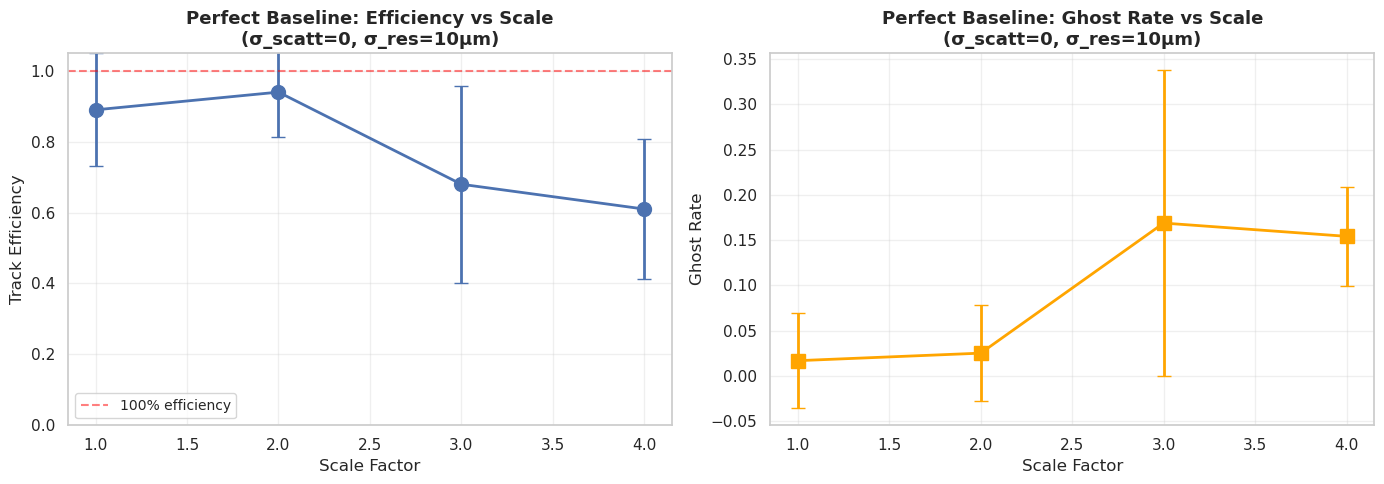

✓ Saved plot to plots/perfect_baseline.png


In [ ]:
# Perfect baseline: scale factor sweep with σ_scatt=0, σ_res=10µm
print('='*70)
print('ANALYSIS 1: PERFECT BASELINE')
print('='*70)

perfect = df_all[(df_all['sigma_scatt_mrad'] == 0.0) & 
                 (df_all['sigma_res_um'].between(9, 11))]

if len(perfect) == 0:
    print('⚠️  No perfect baseline data found')
    print(f'Unique scattering values: {sorted(df_all["sigma_scatt_mrad"].unique())}')
    print(f'Unique resolution values: {sorted(df_all["sigma_res_um"].unique())}')
else:
    # Aggregate by scale
    baseline = perfect.groupby('scale').agg({
        'efficiency': ['mean', 'std', 'count'],
        'ghost_rate': ['mean', 'std'],
        'hit_purity': ['mean', 'std'],
        'hit_efficiency': ['mean', 'std']
    }).reset_index()
    
    # Flatten column names
    baseline.columns = ['_'.join(col).strip('_') for col in baseline.columns.values]
    baseline = baseline.sort_values('scale')
    
    print(f'\n{len(perfect)} events in perfect baseline')
    print(f'\n{"Scale":<8} {"Efficiency":<15} {"Ghost Rate":<15} {"Hit Purity":<15} {"N Events":<10}')
    print('='*70)
    
    for _, row in baseline.iterrows():
        print(f'{row["scale"]:<8.1f} '
              f'{row["efficiency_mean"]*100:>6.1f}% ± {row["efficiency_std"]*100:>5.1f}%  '
              f'{row["ghost_rate_mean"]*100:>6.1f}% ± {row["ghost_rate_std"]*100:>5.1f}%  '
              f'{row["hit_purity_mean"]*100:>6.1f}% ± {row["hit_purity_std"]*100:>5.1f}%  '
              f'{row["efficiency_count"]:>8.0f}')
    
    baseline.to_csv(SUMMARY_DIR / 'perfect_baseline_summary.csv', index=False)
    print(f'\n✓ Saved to {SUMMARY_DIR}/perfect_baseline_summary.csv')
    
    # Plot perfect baseline
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    ax.errorbar(baseline['scale'], baseline['efficiency_mean'], 
                yerr=baseline['efficiency_std'],
                marker='o', markersize=10, linewidth=2, capsize=5)
    ax.axhline(1.0, color='red', linestyle='--', label='100% efficiency', alpha=0.5)
    ax.set_xlabel('Scale Factor', fontsize=12)
    ax.set_ylabel('Track Efficiency', fontsize=12)
    ax.set_title('Perfect Baseline: Efficiency vs Scale\n(σ_scatt=0, σ_res=10µm)', 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    ax = axes[1]
    ax.errorbar(baseline['scale'], baseline['ghost_rate_mean'], 
                yerr=baseline['ghost_rate_std'],
                marker='s', markersize=10, linewidth=2, capsize=5, color='orange')
    ax.set_xlabel('Scale Factor', fontsize=12)
    ax.set_ylabel('Ghost Rate', fontsize=12)
    ax.set_title('Perfect Baseline: Ghost Rate vs Scale\n(σ_scatt=0, σ_res=10µm)', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'perfect_baseline.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved plot to plots/perfect_baseline.png')

## Step 5: Analysis 2 - Resolution Scan


ANALYSIS 2: RESOLUTION SCAN

170 events in resolution scan

Resolution range: 5 - 20 µm
Scale range: 1 - 4

Res (µm)   Scale    Efficiency      Ghost Rate      N     
5.0        1          88.0% ±  14.8%     1.7% ±   5.3%  10    
5.0        2          97.0% ±   9.5%     1.2% ±   4.0%  10    
5.0        3          83.0% ±  18.9%     7.9% ±   9.6%  10    
5.0        4          82.0% ±  14.0%     7.3% ±   6.3%  10    
10.0       1          89.0% ±  16.0%     1.7% ±   5.3%  10    
10.0       2          94.0% ±  12.6%     2.5% ±   5.3%  10    
10.0       3          68.0% ±  27.8%    16.9% ±  16.9%  20    
10.0       4          61.0% ±  19.7%    15.4% ±   5.5%  10    
15.0       1          80.0% ±  14.9%     4.2% ±   6.9%  10    
15.0       2          71.0% ±  14.5%    14.0% ±   7.9%  10    
15.0       3          57.0% ±  18.3%    20.5% ±  13.3%  10    
15.0       4          64.0% ±  21.2%    14.0% ±   9.5%  10    
20.0       1          88.0% ±  10.3%     2.4% ±   5.0%  10    
20.0       2 

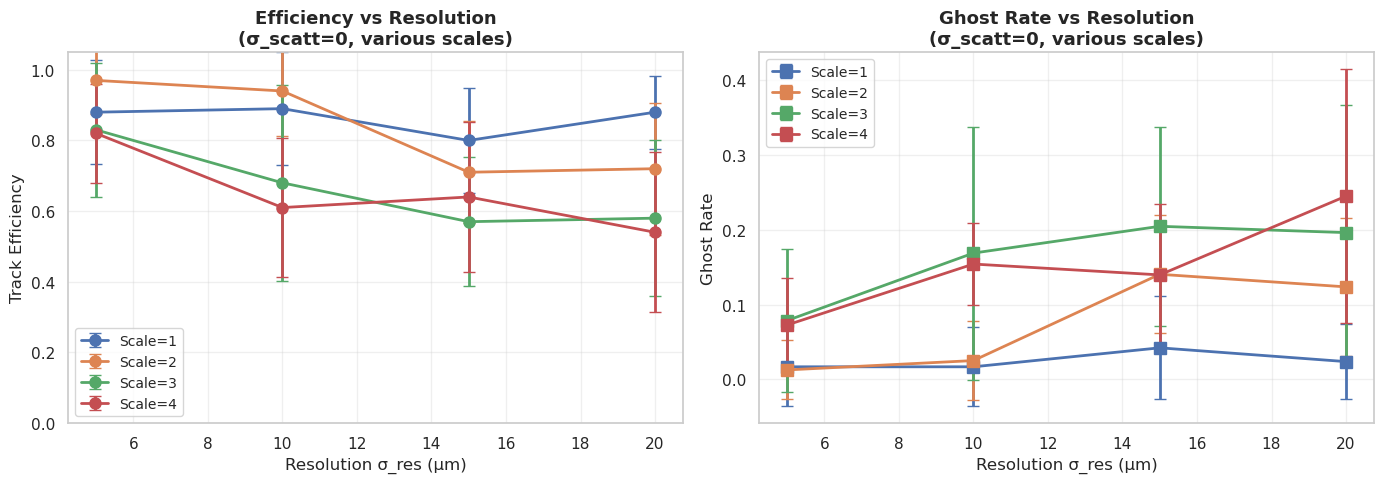

✓ Saved plot to plots/resolution_scan.png


In [ ]:
# Resolution scan: efficiency vs resolution and scale (σ_scatt=0)
print('\n' + '='*70)
print('ANALYSIS 2: RESOLUTION SCAN')
print('='*70)

res_scan = df_all[df_all['sigma_scatt_mrad'] < 0.001]  # Near-zero scattering

if len(res_scan) == 0:
    print('⚠️  No resolution scan data found')
else:
    res_agg = res_scan.groupby(['sigma_res_um', 'scale']).agg({
        'efficiency': ['mean', 'std', 'count'],
        'ghost_rate': ['mean', 'std'],
        'hit_purity': ['mean', 'std']
    }).reset_index()
    
    # Flatten column names
    res_agg.columns = ['sigma_res_um', 'scale', 
                       'efficiency_mean', 'efficiency_std', 'n_events',
                       'ghost_rate_mean', 'ghost_rate_std',
                       'hit_purity_mean', 'hit_purity_std']
    res_agg = res_agg.sort_values(['sigma_res_um', 'scale'])
    
    print(f'\n{len(res_scan)} events in resolution scan')
    print(f'\nResolution range: {res_agg["sigma_res_um"].min():.0f} - {res_agg["sigma_res_um"].max():.0f} µm')
    print(f'Scale range: {res_agg["scale"].min():.0f} - {res_agg["scale"].max():.0f}\n')
    
    print(f'{"Res (µm)":<10} {"Scale":<8} {"Efficiency":<15} {"Ghost Rate":<15} {"N":<6}')
    print('='*70)
    
    for _, row in res_agg.iterrows():
        print(f'{row["sigma_res_um"]:<10.1f} {row["scale"]:<8.0f} '
              f'{row["efficiency_mean"]*100:>6.1f}% ± {row["efficiency_std"]*100:>5.1f}%  '
              f'{row["ghost_rate_mean"]*100:>6.1f}% ± {row["ghost_rate_std"]*100:>5.1f}%  '
              f'{row["n_events"]:<6.0f}')
    
    res_agg.to_csv(SUMMARY_DIR / 'resolution_scan_summary.csv', index=False)
    print(f'\n✓ Saved to {SUMMARY_DIR}/resolution_scan_summary.csv')
    
    # Plot resolution scan
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Efficiency vs Resolution for each scale
    ax = axes[0]
    for scale in sorted(res_agg['scale'].unique()):
        data = res_agg[res_agg['scale'] == scale]
        ax.errorbar(data['sigma_res_um'], data['efficiency_mean'],
                   yerr=data['efficiency_std'],
                   marker='o', label=f'Scale={scale:.0f}', 
                   linewidth=2, markersize=8, capsize=4)
    
    ax.set_xlabel('Resolution σ_res (µm)', fontsize=12)
    ax.set_ylabel('Track Efficiency', fontsize=12)
    ax.set_title('Efficiency vs Resolution\n(σ_scatt=0, various scales)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    # Ghost rate vs Resolution
    ax = axes[1]
    for scale in sorted(res_agg['scale'].unique()):
        data = res_agg[res_agg['scale'] == scale]
        ax.errorbar(data['sigma_res_um'], data['ghost_rate_mean'],
                   yerr=data['ghost_rate_std'],
                   marker='s', label=f'Scale={scale:.0f}', 
                   linewidth=2, markersize=8, capsize=4)
    
    ax.set_xlabel('Resolution σ_res (µm)', fontsize=12)
    ax.set_ylabel('Ghost Rate', fontsize=12)
    ax.set_title('Ghost Rate vs Resolution\n(σ_scatt=0, various scales)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'resolution_scan.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved plot to plots/resolution_scan.png')

## Step 6: Analysis 3 - Scattering Scan


ANALYSIS 3: SCATTERING SCAN

290 events in scattering scan

Scattering range: 0.00 - 1.00 mrad
Scale range: 1 - 4

Scatt (mrad)    Scale    Efficiency      Ghost Rate      N     
0.00            1          89.0% ±  16.0%     1.7% ±   5.3%  10    
0.00            2          94.0% ±  12.6%     2.5% ±   5.3%  10    
0.00            3          68.0% ±  27.8%    16.9% ±  16.9%  20    
0.00            4          61.0% ±  19.7%    15.4% ±   5.5%  10    
0.10            1          85.0% ±  10.8%     3.6% ±   5.8%  10    
0.10            2          80.0% ±  24.5%     8.7% ±  10.4%  10    
0.10            3          76.0% ±  25.9%    10.7% ±  11.5%  10    
0.10            4          60.0% ±  20.5%    15.0% ±   8.8%  10    
0.20            1          79.0% ±  17.9%     6.9% ±   7.4%  10    
0.20            2          77.0% ±  21.1%     9.7% ±   9.6%  10    
0.20            3          82.0% ±  16.9%     7.6% ±   6.6%  10    
0.20            4          71.0% ±  22.3%    11.7% ±   9.4%  10    
0.30

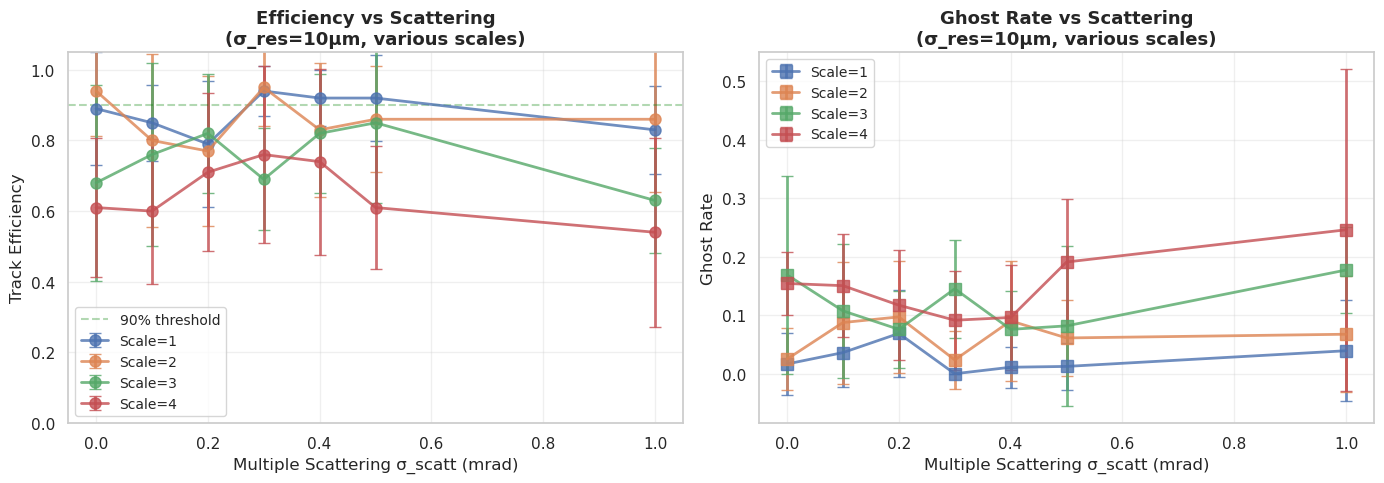

✓ Saved plot to plots/scattering_scan.png


In [ ]:
# Scattering scan: efficiency vs scattering and scale (σ_res≈10µm)
print('\n' + '='*70)
print('ANALYSIS 3: SCATTERING SCAN')
print('='*70)

scatt_scan = df_all[df_all['sigma_res_um'].between(9, 11)]

if len(scatt_scan) == 0:
    print('⚠️  No scattering scan data found')
else:
    scatt_agg = scatt_scan.groupby(['sigma_scatt_mrad', 'scale']).agg({
        'efficiency': ['mean', 'std', 'count'],
        'ghost_rate': ['mean', 'std'],
        'hit_purity': ['mean', 'std']
    }).reset_index()
    
    # Flatten column names
    scatt_agg.columns = ['_'.join(col).strip('_') for col in scatt_agg.columns.values]
    scatt_agg = scatt_agg.sort_values(['sigma_scatt_mrad', 'scale'])
    
    print(f'\n{len(scatt_scan)} events in scattering scan')
    print(f'\nScattering range: {scatt_agg["sigma_scatt_mrad"].min():.2f} - {scatt_agg["sigma_scatt_mrad"].max():.2f} mrad')
    print(f'Scale range: {scatt_agg["scale"].min():.0f} - {scatt_agg["scale"].max():.0f}\n')
    
    print(f'{"Scatt (mrad)":<15} {"Scale":<8} {"Efficiency":<15} {"Ghost Rate":<15} {"N":<6}')
    print('='*70)
    
    for _, row in scatt_agg.iterrows():
        print(f'{row["sigma_scatt_mrad"]:<15.2f} {row["scale"]:<8.0f} '
              f'{row["efficiency_mean"]*100:>6.1f}% ± {row["efficiency_std"]*100:>5.1f}%  '
              f'{row["ghost_rate_mean"]*100:>6.1f}% ± {row["ghost_rate_std"]*100:>5.1f}%  '
              f'{row["efficiency_count"]:<6.0f}')
    
    scatt_agg.to_csv(SUMMARY_DIR / 'scattering_scan_summary.csv', index=False)
    print(f'\n✓ Saved to {SUMMARY_DIR}/scattering_scan_summary.csv')
    
    # Plot scattering scan
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Efficiency vs Scattering for each scale
    ax = axes[0]
    for scale in sorted(scatt_agg['scale'].unique()):
        data = scatt_agg[scatt_agg['scale'] == scale]
        ax.errorbar(data['sigma_scatt_mrad'], data['efficiency_mean'],
                   yerr=data['efficiency_std'],
                   marker='o', label=f'Scale={scale:.0f}', 
                   linewidth=2, markersize=8, capsize=4, alpha=0.8)
    
    ax.axhline(0.9, color='green', linestyle='--', alpha=0.3, label='90% threshold')
    ax.set_xlabel('Multiple Scattering σ_scatt (mrad)', fontsize=12)
    ax.set_ylabel('Track Efficiency', fontsize=12)
    ax.set_title('Efficiency vs Scattering\n(σ_res=10µm, various scales)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    
    # Ghost rate vs Scattering
    ax = axes[1]
    for scale in sorted(scatt_agg['scale'].unique()):
        data = scatt_agg[scatt_agg['scale'] == scale]
        ax.errorbar(data['sigma_scatt_mrad'], data['ghost_rate_mean'],
                   yerr=data['ghost_rate_std'],
                   marker='s', label=f'Scale={scale:.0f}', 
                   linewidth=2, markersize=8, capsize=4, alpha=0.8)
    
    ax.set_xlabel('Multiple Scattering σ_scatt (mrad)', fontsize=12)
    ax.set_ylabel('Ghost Rate', fontsize=12)
    ax.set_title('Ghost Rate vs Scattering\n(σ_res=10µm, various scales)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'scattering_scan.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved plot to plots/scattering_scan.png')

## Step 7: Summary Report

In [ ]:
# Summary statistics and top performers
print('\n' + '='*70)
print('SUMMARY REPORT')
print('='*70)

print(f'\nTotal events analyzed: {len(df_all)}')
print(f'Overall efficiency: {df_all["efficiency"].mean():.3f} ± {df_all["efficiency"].std():.3f}')
print(f'Overall ghost rate: {df_all["ghost_rate"].mean():.3f} ± {df_all["ghost_rate"].std():.3f}')
print(f'Overall hit purity: {df_all["hit_purity"].mean():.3f} ± {df_all["hit_purity"].std():.3f}')

print(f'\nTop 10 configurations by efficiency:')
print(f'{"Scale":<8} {"Res (µm)":<10} {"Scatt (mrad)":<15} {"Efficiency":<12} {"Ghost Rate":<12}')
print('='*70)

top10 = df_all.groupby(['scale', 'sigma_res_um', 'sigma_scatt_mrad']).agg({
    'efficiency': 'mean',
    'ghost_rate': 'mean'
}).reset_index().nlargest(10, 'efficiency')

for _, row in top10.iterrows():
    print(f'{row["scale"]:<8.0f} {row["sigma_res_um"]:<10.1f} '
          f'{row["sigma_scatt_mrad"]:<15.2f} '
          f'{row["efficiency"]*100:>10.1f}%  {row["ghost_rate"]*100:>10.1f}%')

print('\n' + '='*70)
print('Output files:')
print('='*70)
print(f'Plots: {PLOTS_DIR}/')
print(f'Summaries: {SUMMARY_DIR}/')

# List files
print(f'\nGenerated plots:')
for f in sorted(PLOTS_DIR.glob('*.png')):
    size = f.stat().st_size / 1024
    print(f'  {f.name} ({size:.1f} KB)')

print(f'\nGenerated summaries:')
for f in sorted(SUMMARY_DIR.glob('*.csv')):
    size = f.stat().st_size / 1024
    print(f'  {f.name} ({size:.1f} KB)')

print('\n' + '='*70)


SUMMARY REPORT

Total events analyzed: 410
Overall efficiency: 0.770 ± 0.215
Overall ghost rate: 0.097 ± 0.118
Overall hit purity: 0.997 ± 0.049

Top 10 configurations by efficiency:
Scale    Res (µm)   Scatt (mrad)    Efficiency   Ghost Rate  
2        5.0        0.00                  97.0%         1.2%
2        10.0       0.30                  95.0%         2.4%
1        10.0       0.30                  94.0%         0.0%
2        10.0       0.00                  94.0%         2.5%
1        10.0       0.40                  92.0%         1.1%
1        10.0       0.50                  92.0%         1.2%
1        10.0       0.00                  89.0%         1.7%
1        5.0        0.00                  88.0%         1.7%
1        20.0       0.00                  88.0%         2.4%
2        10.0       0.50                  86.0%         6.1%

Output files:
Plots: /data/bfys/gscriven/Velo_toy/runs_test_local/plots/
Summaries: /data/bfys/gscriven/Velo_toy/runs_test_local/summary/

Gene

## Step 8: Segment Angle Analysis

Analyze how segment angles distinguish true tracks from false/combinatorial pairs.

In [ ]:
import pickle
import gzip
from itertools import product

def load_event_store(store_path):
    """Load the event store pickle file."""
    with gzip.open(store_path, 'rb') as f:
        return pickle.load(f)

def compute_segment_angles(event):
    """
    Compute angles between all consecutive segment pairs.
    
    Returns:
    - true_angles: angles (radians) for true track segment pairs
    - false_angles: angles (radians) for false/combinatorial segment pairs
    """
    # Get true track segments (using hit_ids in new API)
    true_segments = set()
    for track in event.tracks:
        hits = event.get_hits_by_ids(track.hit_ids)
        for i in range(len(hits) - 1):
            from_hit = hits[i]
            to_hit = hits[i + 1]
            true_segments.add((from_hit.hit_id, to_hit.hit_id))
    
    # Compute all segments and their direction vectors
    all_segments = []
    segment_vectors = []
    segment_is_true = []
    
    # Iterate through consecutive modules (using hit_ids in new API)
    for idx in range(len(event.modules) - 1):
        from_hits = event.get_hits_by_ids(event.modules[idx].hit_ids)
        to_hits = event.get_hits_by_ids(event.modules[idx + 1].hit_ids)
        
        for from_hit, to_hit in product(from_hits, to_hits):
            # Compute direction vector
            dx = to_hit.x - from_hit.x
            dy = to_hit.y - from_hit.y
            dz = to_hit.z - from_hit.z
            norm = np.sqrt(dx*dx + dy*dy + dz*dz)
            
            if norm > 0:
                vec = np.array([dx/norm, dy/norm, dz/norm])
                segment_vectors.append(vec)
                all_segments.append((from_hit.hit_id, to_hit.hit_id))
                
                # Check if this is a true segment
                is_true = (from_hit.hit_id, to_hit.hit_id) in true_segments
                segment_is_true.append(is_true)
    
    # Group segments by the module index of their 'to' hit
    segments_by_module = {}
    for i, (seg, vec, is_true) in enumerate(zip(all_segments, segment_vectors, segment_is_true)):
        from_id, to_id = seg
        # Find which module the 'to' hit belongs to
        module_idx = None
        for midx, module in enumerate(event.modules):
            if to_id in module.hit_ids:
                module_idx = midx
                break
        
        if module_idx is not None:
            if module_idx not in segments_by_module:
                segments_by_module[module_idx] = []
            segments_by_module[module_idx].append((i, vec, is_true, seg))
    
    # Compute angles between segments from consecutive modules
    true_angles = []
    false_angles = []
    
    module_indices = sorted(segments_by_module.keys())
    for i in range(len(module_indices) - 1):
        m1_idx = module_indices[i]
        m2_idx = module_indices[i + 1]
        
        # Only consider consecutive modules
        if m2_idx != m1_idx + 1:
            continue
        
        segs1 = segments_by_module[m1_idx]
        segs2 = segments_by_module[m2_idx]
        
        for (idx1, vec1, is_true1, seg1), (idx2, vec2, is_true2, seg2) in product(segs1, segs2):
            # Check if segments share a common hit (valid connection)
            if seg1[1] == seg2[0]:  # to_hit of seg1 == from_hit of seg2
                # Compute angle between direction vectors
                dot_product = np.dot(vec1, vec2)
                dot_product = np.clip(dot_product, -1.0, 1.0)  # Handle numerical errors
                angle = np.arccos(dot_product)
                
                # Classify: true if both segments are from true tracks
                is_true_pair = is_true1 and is_true2
                
                if is_true_pair:
                    true_angles.append(angle)
                else:
                    false_angles.append(angle)
    
    return np.array(true_angles), np.array(false_angles)

def analyze_parameter_set_local(runs_dir, scale, sigma_scatt_mrad, sigma_res_um, n_events=20):
    """
    Analyze segment angles for a specific parameter set using local event snapshot files.
    """
    runs_path = Path(runs_dir)
    
    # Load metrics to find matching events
    metrics_path = runs_path / "metrics_fixed.csv"
    if not metrics_path.exists():
        print(f"Warning: {metrics_path} not found")
        return None, None
    
    df = pd.read_csv(metrics_path)
    
    # Convert units to match DataFrame
    sigma_res_mm = sigma_res_um / 1000.0
    sigma_scatt_rad = sigma_scatt_mrad / 1000.0
    
    # Filter to matching parameters
    mask = (
        (np.abs(df['p_hit_res'] - sigma_res_mm) < 1e-6) &
        (np.abs(df['p_multi_scatter'] - sigma_scatt_rad) < 1e-9) &
        (np.abs(df['p_scale'] - scale) < 0.01)
    )
    
    matching = df[mask]
    
    if len(matching) == 0:
        print(f"Warning: No events found for scale={scale}, σ_scatt={sigma_scatt_mrad} mrad, σ_res={sigma_res_um} µm")
        return None, None
    
    print(f"Found {len(matching)} events for scale={scale}, σ_scatt={sigma_scatt_mrad} mrad, σ_res={sigma_res_um} µm")
    
    # Collect angles from matching events
    all_true_angles = []
    all_false_angles = []
    
    events_processed = 0
    unique_batches = matching['batch'].unique()[:10]  # Limit to 10 batches
    
    for batch_str in unique_batches:
        if events_processed >= n_events:
            break
            
        batch_path = runs_path / batch_str / "local.job"
        if not batch_path.exists():
            continue
        
        try:
            # Find all event snapshot files in this batch
            event_files = sorted(batch_path.glob("events_*.pkl.gz"))
            
            for event_file in event_files:
                if events_processed >= n_events:
                    break
                
                try:
                    # Load individual event snapshot
                    with gzip.open(event_file, 'rb') as f:
                        snapshot = pickle.load(f)
                    
                    # Extract the truth event
                    event = snapshot.get('truth_event') or snapshot.get('noisy_event')
                    if event is None:
                        continue
                    
                    # Compute angles
                    true_angles, false_angles = compute_segment_angles(event)
                    all_true_angles.extend(true_angles)
                    all_false_angles.extend(false_angles)
                    events_processed += 1
                    
                except Exception as e:
                    continue
                    
        except Exception as e:
            print(f"Error processing {batch_str}: {e}")
            continue
    
    print(f"  Processed {events_processed} events")
    return np.array(all_true_angles), np.array(all_false_angles)

def compute_epsilon(sigma_res_mm, sigma_scatt_rad, scale, dz_mm=33.0, theta_min=1.5e-5): # Make me 1.5 mrad 
    """Compute epsilon threshold."""
    theta_s = scale * sigma_scatt_rad
    theta_r = np.arctan((scale * sigma_res_mm) / dz_mm) if dz_mm != 0 else 0.0
    # return np.sqrt(theta_s**2 + theta_r**2 + theta_min**2)
    return np.sqrt(2 * (theta_s)**2 + 12 * (theta_r)**2 + 2*theta_min**2)

# OLD 
# np.sqrt(theta_s**2 + theta_r**2 + theta_m**2)

print("✓ Segment angle analysis functions loaded")

✓ Segment angle analysis functions loaded


In [ ]:
# Define parameter sets: Good (optimal) vs Bad (suboptimal)
# For local data, use parameters that are actually present
# Since we have limited parameter variety, compare available configurations

# First, identify the best and worst configurations from our data
best_config = df_all.loc[df_all['efficiency'].idxmax()]
worst_config = df_all.loc[df_all['efficiency'].idxmin()]

parameter_sets = [
    (best_config['scale'], best_config['sigma_scatt_mrad'], best_config['sigma_res_um'], 
     f"Good: scale={best_config['scale']:.1f}, σ_scatt={best_config['sigma_scatt_mrad']:.4f}, σ_res={best_config['sigma_res_um']:.1f}µm (eff={best_config['efficiency']*100:.1f}%)"),
    (worst_config['scale'], worst_config['sigma_scatt_mrad'], worst_config['sigma_res_um'],
     f"Bad: scale={worst_config['scale']:.1f}, σ_scatt={worst_config['sigma_scatt_mrad']:.4f}, σ_res={worst_config['sigma_res_um']:.1f}µm (eff={worst_config['efficiency']*100:.1f}%)"),
]

# Collect angle data
angle_results = []

for scale, sigma_scatt_mrad, sigma_res_um, label in parameter_sets:
    print(f"\nAnalyzing: {label}")
    
    true_angles, false_angles = analyze_parameter_set_local(
        str(RUNS), scale, sigma_scatt_mrad, sigma_res_um, n_events=20
    )
    
    if true_angles is not None and len(true_angles) > 0:
        # Compute epsilon for this configuration
        # epsilon = epsilon_window(sigma_res_um / 1000.0,sigma_scatt_mrad / 1000.0, 33, sigma_scatt_mrad / 1000.0, theta_min = 1.5e-5)
        epsilon = compute_epsilon(
            sigma_res_um / 1000.0,  # Convert to mm
            sigma_scatt_mrad / 1000.0,  # Convert to rad
            scale
        )
        
        angle_results.append({
            'label': label,
            'scale': scale,
            'sigma_scatt_mrad': sigma_scatt_mrad,
            'sigma_res_um': sigma_res_um,
            'true_angles': true_angles,
            'false_angles': false_angles,
            'epsilon': epsilon,
            'n_true': len(true_angles),
            'n_false': len(false_angles)
        })
        
        print(f"  True angles: n={len(true_angles)}, mean={np.mean(true_angles)*1000:.2f} mrad, "
              f"std={np.std(true_angles)*1000:.2f} mrad")
        print(f"  False angles: n={len(false_angles)}, mean={np.mean(false_angles)*1000:.2f} mrad, "
              f"std={np.std(false_angles)*1000:.2f} mrad")
        print(f"  Epsilon threshold: {epsilon*1000:.2f} mrad")
        
        # Calculate acceptance rates
        if len(true_angles) > 0:
            true_accepted = np.sum(true_angles <= epsilon) / len(true_angles) * 100
            print(f"  True pairs accepted by ε: {true_accepted:.1f}%")
        if len(false_angles) > 0:
            false_accepted = np.sum(false_angles <= epsilon) / len(false_angles) * 100
            print(f"  False pairs accepted by ε: {false_accepted:.1f}%")


Analyzing: Good: scale=2.0, σ_scatt=0.0000, σ_res=15.0µm (eff=100.0%)
Found 10 events for scale=2.0, σ_scatt=0.0 mrad, σ_res=15.0 µm
  Processed 10 events
  True angles: n=300, mean=1.31 mrad, std=0.70 mrad
  False angles: n=29700, mean=535.59 mrad, std=383.22 mrad
  Epsilon threshold: 3.15 mrad
  True pairs accepted by ε: 98.3%
  False pairs accepted by ε: 0.1%

Analyzing: Bad: scale=4.0, σ_scatt=1.0000, σ_res=10.0µm (eff=0.0%)
Found 10 events for scale=4.0, σ_scatt=1.0 mrad, σ_res=10.0 µm
  Processed 10 events
  True angles: n=300, mean=1.50 mrad, std=0.77 mrad
  False angles: n=29700, mean=599.59 mrad, std=422.27 mrad
  Epsilon threshold: 7.04 mrad
  True pairs accepted by ε: 100.0%
  False pairs accepted by ε: 0.2%


In [ ]:
sigma_res_um

np.float64(10.0)


✓ Saved segment angle comparison plot


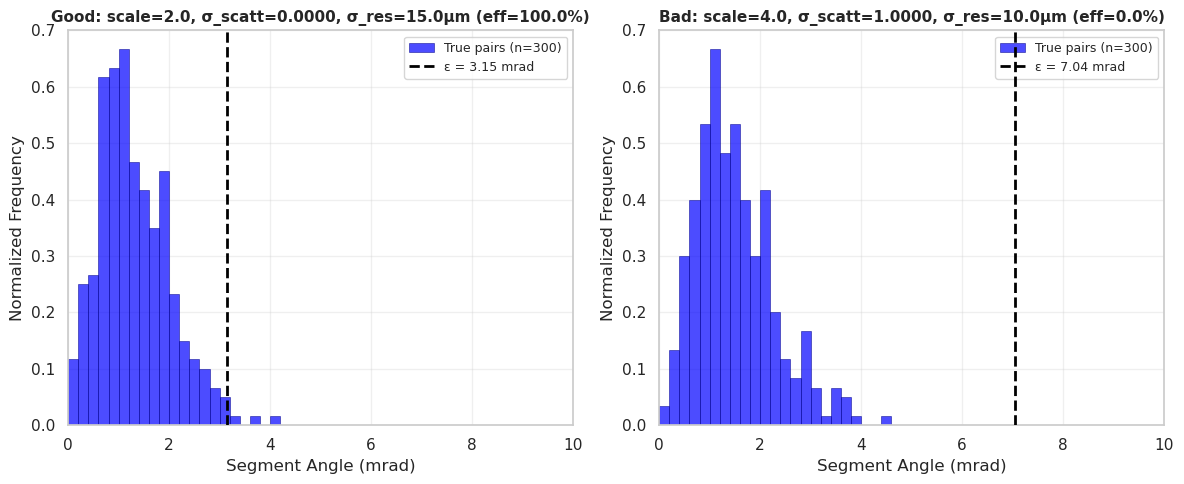

In [ ]:
# Create comparison plot: Good vs Bad (True angles only)
if len(angle_results) > 0:
    fig, axes = plt.subplots(1, len(angle_results), figsize=(6*len(angle_results), 5))
    
    if len(angle_results) == 1:
        axes = [axes]
    
    for idx, result in enumerate(angle_results):
        ax = axes[idx]
        
        # Convert to mrad for plotting
        true_angles_mrad = result['true_angles'] * 1000
        epsilon_mrad = result['epsilon'] * 1000
        
        # Create histogram - true angles only
        bins = np.linspace(0, 10, 51)  # 0-10 mrad with 0.2 mrad bins
        
        ax.hist(true_angles_mrad, bins=bins, alpha=0.7, color='blue', 
                label=f'True pairs (n={result["n_true"]})', density=True, edgecolor='darkblue', linewidth=0.5)
        
        # Add epsilon threshold line
        ax.axvline(epsilon_mrad, color='black', linestyle='--', linewidth=2, 
                   label=f'ε = {epsilon_mrad:.2f} mrad', zorder=10)
        
        # Styling
        ax.set_xlabel('Segment Angle (mrad)', fontsize=12)
        ax.set_ylabel('Normalized Frequency', fontsize=12)
        ax.set_title(result['label'], fontsize=11, fontweight='bold')
        ax.legend(fontsize=9, loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 10)
        ax.set_ylim(0, None)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'segment_angle_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved segment angle comparison plot")
    plt.show()
else:
    print("No angle analysis results to plot")


✓ Metrics comparison saved to segment_angle_metrics_comparison.png

METRICS SUMMARY: Good vs Bad Parameters

Good: scale=2.0, σ_scatt=0.0000, σ_res=15.0µm (eff=100.0%) (n=10 events):
  Efficiency:   71.0% ±  13.7%  (median:  70.0%)
  Ghost Rate:   14.0% ±   7.5%  (median:  12.5%)
  Hit Purity:  100.0% ±   0.0%

Bad: scale=4.0, σ_scatt=1.0000, σ_res=10.0µm (eff=0.0%) (n=10 events):
  Efficiency:   54.0% ±  25.4%  (median:  70.0%)
  Ghost Rate:   24.6% ±  26.1%  (median:  12.5%)
  Hit Purity:   90.0% ±  30.0%


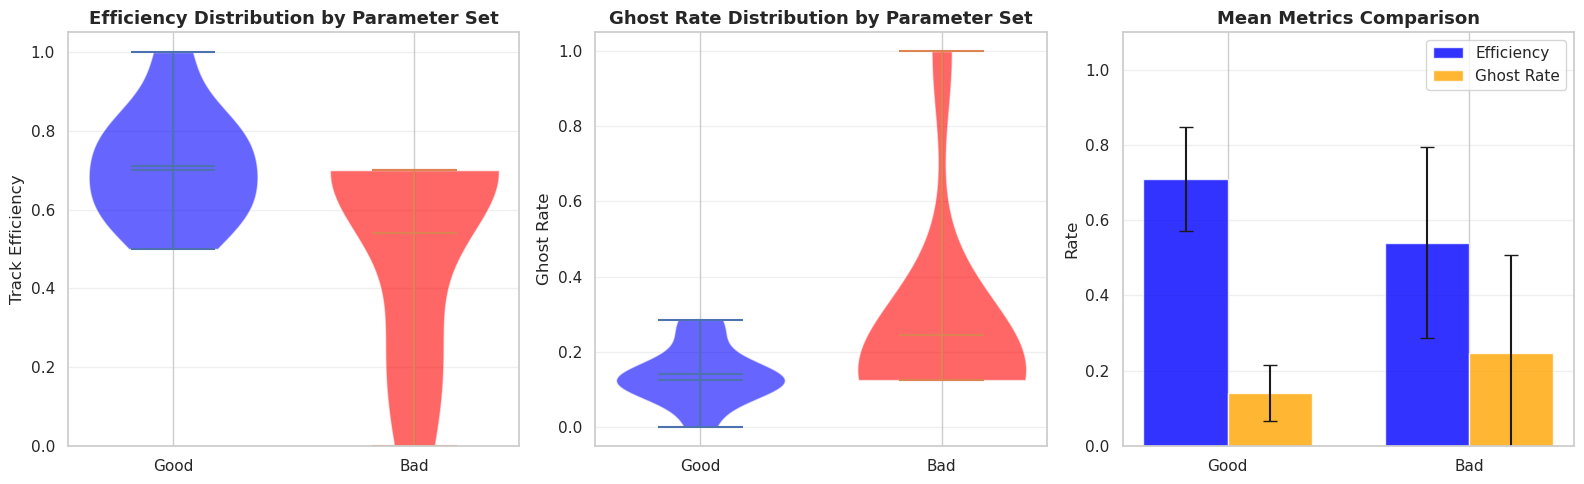

In [ ]:
# Plot metrics for Good vs Bad parameter sets
if len(angle_results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    metrics_to_plot = []
    for scale, sigma_scatt_mrad, sigma_res_um, label in parameter_sets:
        # Filter df_all for these exact parameters
        mask = (
            (np.abs(df_all['scale'] - scale) < 0.01) &
            (np.abs(df_all['sigma_scatt_mrad'] - sigma_scatt_mrad) < 0.01) &
            (np.abs(df_all['sigma_res_um'] - sigma_res_um) < 1.0)
        )
        data = df_all[mask]
        
        if len(data) > 0:
            metrics_to_plot.append({
                'label': label,
                'efficiency': data['efficiency'].values,
                'ghost_rate': data['ghost_rate'].values,
                'hit_purity': data['hit_purity'].values,
                'n_events': len(data)
            })
    
    if len(metrics_to_plot) > 0:
        # Plot 1: Efficiency distributions
        ax = axes[0]
        positions = list(range(len(metrics_to_plot)))
        for i, m in enumerate(metrics_to_plot):
            parts = ax.violinplot([m['efficiency']], positions=[i], widths=0.7, 
                                  showmeans=True, showmedians=True)
            for pc in parts['bodies']:
                pc.set_facecolor(['blue', 'red'][i])
                pc.set_alpha(0.6)
        ax.set_xticks(positions)
        ax.set_xticklabels([m['label'].split(':')[0] for m in metrics_to_plot], fontsize=11)
        ax.set_ylabel('Track Efficiency', fontsize=12)
        ax.set_title('Efficiency Distribution by Parameter Set', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 1.05)
        
        # Plot 2: Ghost rate distributions
        ax = axes[1]
        for i, m in enumerate(metrics_to_plot):
            parts = ax.violinplot([m['ghost_rate']], positions=[i], widths=0.7,
                                  showmeans=True, showmedians=True)
            for pc in parts['bodies']:
                pc.set_facecolor(['blue', 'red'][i])
                pc.set_alpha(0.6)
        ax.set_xticks(positions)
        ax.set_xticklabels([m['label'].split(':')[0] for m in metrics_to_plot], fontsize=11)
        ax.set_ylabel('Ghost Rate', fontsize=12)
        ax.set_title('Ghost Rate Distribution by Parameter Set', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Plot 3: Summary statistics
        ax = axes[2]
        x_pos = np.arange(len(metrics_to_plot))
        width = 0.35
        
        eff_means = [np.mean(m['efficiency']) for m in metrics_to_plot]
        eff_stds = [np.std(m['efficiency']) for m in metrics_to_plot]
        ghost_means = [np.mean(m['ghost_rate']) for m in metrics_to_plot]
        ghost_stds = [np.std(m['ghost_rate']) for m in metrics_to_plot]
        
        ax.bar(x_pos - width/2, eff_means, width, yerr=eff_stds, 
               label='Efficiency', alpha=0.8, capsize=5, color='blue')
        ax.bar(x_pos + width/2, ghost_means, width, yerr=ghost_stds,
               label='Ghost Rate', alpha=0.8, capsize=5, color='orange')
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels([m['label'].split(':')[0] for m in metrics_to_plot], fontsize=11)
        ax.set_ylabel('Rate', fontsize=12)
        ax.set_title('Mean Metrics Comparison', fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 1.1)
        
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'segment_angle_metrics_comparison.png', dpi=300, bbox_inches='tight')
        print("\n✓ Metrics comparison saved to segment_angle_metrics_comparison.png")
        
        # Print summary statistics
        print("\n" + "="*70)
        print("METRICS SUMMARY: Good vs Bad Parameters")
        print("="*70)
        for m in metrics_to_plot:
            print(f"\n{m['label']} (n={m['n_events']} events):")
            print(f"  Efficiency:  {np.mean(m['efficiency'])*100:5.1f}% ± {np.std(m['efficiency'])*100:5.1f}%  "
                  f"(median: {np.median(m['efficiency'])*100:5.1f}%)")
            print(f"  Ghost Rate:  {np.mean(m['ghost_rate'])*100:5.1f}% ± {np.std(m['ghost_rate'])*100:5.1f}%  "
                  f"(median: {np.median(m['ghost_rate'])*100:5.1f}%)")
            print(f"  Hit Purity:  {np.mean(m['hit_purity'])*100:5.1f}% ± {np.std(m['hit_purity'])*100:5.1f}%")
        print("="*70)
        
        plt.show()

### Scattering Series Analysis

Angular analysis for each scattering value with fixed resolution (10 µm)

In [ ]:
# Analyze segment angles for scale=3, σ_res=10µm, all scattering values
# Direct approach: iterate through scattering values and load events

fixed_scale = 3.0
fixed_resolution = 10.0  # µm

# Get all unique scattering values at this scale and resolution
scale3_res10_mask = (
    (np.abs(df_all['scale'] - fixed_scale) < 0.01) &
    (np.abs(df_all['sigma_res_um'] - fixed_resolution) < 0.1)
)
scale3_res10_data = df_all[scale3_res10_mask]
unique_scattering = sorted(scale3_res10_data['sigma_scatt_mrad'].unique())

print(f"\n{'='*70}")
print(f"SEGMENT ANGLE ANALYSIS: scale={fixed_scale}, σ_res={fixed_resolution}µm")
print(f"{'='*70}")
print(f"Scattering values: {unique_scattering}")
print(f"Total events at this configuration: {len(scale3_res10_data)}")

scattering_angle_results_complete = []

for sigma_scatt in unique_scattering:
    print(f"\n{'-'*70}")
    print(f"σ_scatt = {sigma_scatt:.4f} mrad")
    print(f"{'-'*70}")
    
    # Get events at this exact configuration
    config_mask = (
        (np.abs(df_all['scale'] - fixed_scale) < 0.01) &
        (np.abs(df_all['sigma_res_um'] - fixed_resolution) < 0.1) &
        (np.abs(df_all['sigma_scatt_mrad'] - sigma_scatt) < 1e-6)
    )
    config_data = df_all[config_mask]
    
    if len(config_data) == 0:
        print(f"No events found!")
        continue
    
    print(f"Found {len(config_data)} events in metrics")
    
    # Get unique batches for this configuration
    unique_batches = config_data['batch'].unique()[:5]  # Limit to 5 batches
    
    # Collect angles from event files
    all_true_angles = []
    all_false_angles = []
    events_found = 0
    
    for batch_str in unique_batches:
        batch_path = RUNS / batch_str / "local.job"
        if not batch_path.exists():
            print(f"  Batch {batch_str}: path not found")
            continue
        
        # Find event files in this batch
        event_files = sorted(batch_path.glob("events_*.pkl.gz"))
        
        for event_file in event_files:
            if events_found >= 10:  # Limit to 10 events total
                break
            
            try:
                with gzip.open(event_file, 'rb') as f:
                    snapshot = pickle.load(f)
                
                # Get the truth event
                event = snapshot.get('truth_event')
                if event is None:
                    continue
                
                # Compute angles
                true_angles, false_angles = compute_segment_angles(event)
                all_true_angles.extend(true_angles)
                all_false_angles.extend(false_angles)
                events_found += 1
                
            except Exception as e:
                print(f"    Error loading {event_file.name}: {e}")
                continue
    
    if events_found == 0:
        print(f"Could not load any event files for this scattering value")
        continue
    
    # Compute epsilon
    epsilon = compute_epsilon(
        fixed_resolution / 1000.0,  # Convert to mm
        sigma_scatt / 1000.0,  # Convert to rad
        scale=fixed_scale
    )
    
    # Store results
    mean_efficiency = config_data['efficiency'].mean()
    
    scattering_angle_results_complete.append({
        'sigma_scatt_mrad': sigma_scatt,
        'scale': fixed_scale,
        'sigma_res_um': fixed_resolution,
        'true_angles': np.array(all_true_angles),
        'false_angles': np.array(all_false_angles),
        'epsilon': epsilon,
        'n_true': len(all_true_angles),
        'n_false': len(all_false_angles),
        'efficiency': mean_efficiency,
        'events_loaded': events_found
    })
    
    # Print statistics
    if len(all_true_angles) > 0:
        true_mean = np.mean(all_true_angles) * 1000
        true_std = np.std(all_true_angles) * 1000
        epsilon_mrad = epsilon * 1000
        true_accepted_pct = np.sum(np.array(all_true_angles) <= epsilon) / len(all_true_angles) * 100
        
        print(f"  Events loaded: {events_found}")
        print(f"  Segment pairs: {len(all_true_angles)} true, {len(all_false_angles)} false")
        print(f"  True angle: μ={true_mean:.2f} mrad, σ={true_std:.2f} mrad")
        print(f"  Epsilon: {epsilon_mrad:.2f} mrad")
        print(f"  True pairs accepted: {true_accepted_pct:.1f}%")
        print(f"  Mean efficiency: {mean_efficiency*100:.1f}%")

print(f"\n{'='*70}")
print(f"COMPLETE: Analyzed {len(scattering_angle_results_complete)} scattering values")
print(f"{'='*70}")


SEGMENT ANGLE ANALYSIS: scale=3.0, σ_res=10.0µm
Scattering values: [np.float64(0.0), np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(1.0)]
Total events at this configuration: 80

----------------------------------------------------------------------
σ_scatt = 0.0000 mrad
----------------------------------------------------------------------
Found 20 events in metrics
  Events loaded: 5
  Segment pairs: 150 true, 14850 false
  True angle: μ=0.90 mrad, σ=0.52 mrad
  Epsilon: 3.15 mrad
  True pairs accepted: 100.0%
  Mean efficiency: 68.0%

----------------------------------------------------------------------
σ_scatt = 0.1000 mrad
----------------------------------------------------------------------
Found 10 events in metrics
  Events loaded: 5
  Segment pairs: 150 true, 14850 false
  True angle: μ=0.92 mrad, σ=0.47 mrad
  Epsilon: 3.18 mrad
  True pairs accepted: 100.0%
  Mean efficiency: 76.0%

------------------------------------------

In [ ]:
scattering_angle_results_complete

[{'sigma_scatt_mrad': np.float64(0.0),
  'scale': 3.0,
  'sigma_res_um': 10.0,
  'true_angles': array([8.36438764e-04, 3.04707864e-04, 5.92805489e-04, 7.85444814e-04,
         6.06051140e-04, 1.09733251e-04, 1.93309551e-03, 4.34390959e-04,
         2.24558426e-04, 1.42097481e-03, 7.56372399e-04, 4.84111353e-04,
         1.15156982e-03, 6.26816668e-04, 2.90860764e-04, 4.18169330e-05,
         1.29052009e-03, 8.16627991e-04, 1.73514146e-04, 7.19553648e-04,
         4.80280967e-04, 7.19484440e-04, 1.54392443e-03, 9.72980630e-04,
         2.06042149e-04, 5.80754485e-04, 5.02976569e-04, 1.05515604e-03,
         8.20645219e-04, 6.36410916e-04, 1.11167695e-03, 8.00723935e-04,
         1.55092474e-03, 1.36709028e-03, 3.46504137e-04, 1.55030687e-03,
         6.74204220e-04, 3.28287361e-04, 4.78657836e-04, 3.32523994e-04,
         2.45578741e-03, 6.65860909e-04, 9.98633598e-04, 7.15045651e-04,
         3.18182224e-04, 2.05685556e-03, 8.90924620e-04, 5.42161114e-04,
         1.21702674e-04, 1.378

Saved: scattering_series_angles.png
Saved: scattering_series_angles.png
Saved: scattering_series_angles.png
Saved: scattering_series_angles.png
Saved: scattering_series_angles.png
Saved: scattering_series_angles.png
Saved: scattering_series_angles.png


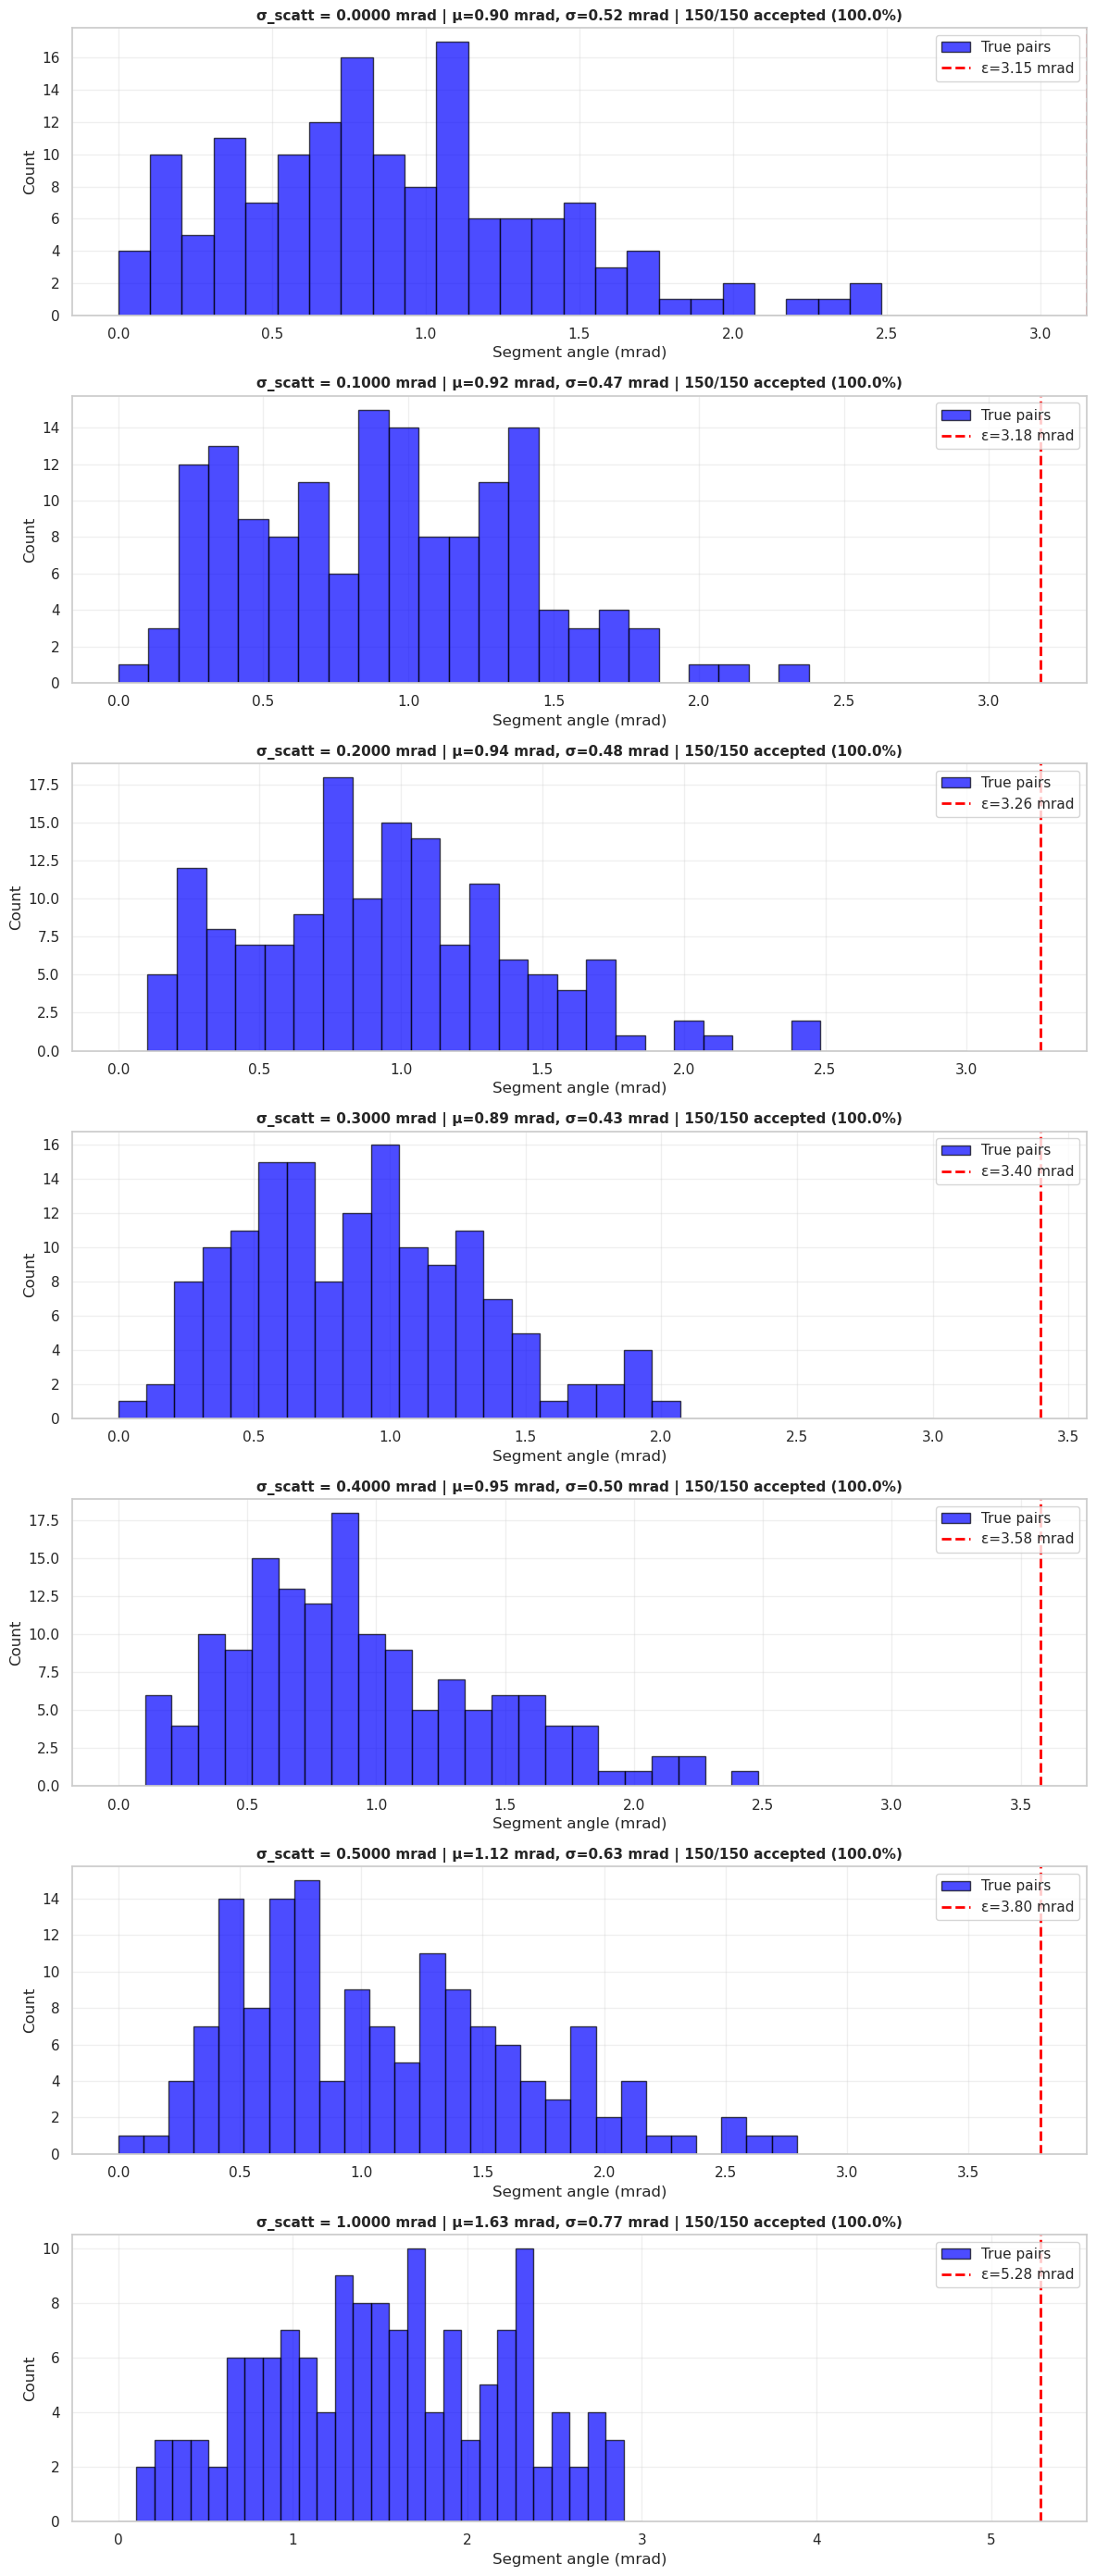

In [ ]:
# Visualize scattering series: histograms for each scattering value

n_scattering = len(scattering_angle_results_complete)
fig, axes = plt.subplots(n_scattering, 1, figsize=(12, 4*n_scattering))

# Handle single subplot case
if n_scattering == 1:
    axes = [axes]
elif not isinstance(axes, np.ndarray):
    axes = [axes]
elif axes.ndim > 1:
    axes = axes.flatten()

for idx, result in enumerate(scattering_angle_results_complete):
    # print('plot')
    ax = axes[idx]
    
    true_angles_mrad = result['true_angles'] * 1000
    epsilon_mrad = result['epsilon'] * 1000
    
    # Plot histogram
    bins = np.linspace(0, 3, 30)
    ax.hist(true_angles_mrad, bins=bins, alpha=0.7, color='blue', edgecolor='black', label='True pairs')
    
    # Mark epsilon
    ax.axvline(epsilon_mrad, color='red', linestyle='--', linewidth=2, label=f'ε={epsilon_mrad:.2f} mrad')
    
    # Statistics
    mean_angle = np.mean(true_angles_mrad)
    std_angle = np.std(true_angles_mrad)
    accepted = np.sum(result['true_angles'] <= result['epsilon'])
    
    # Title and labels
    sigma_scatt = result['sigma_scatt_mrad']
    ax.set_title(f"σ_scatt = {sigma_scatt:.4f} mrad | μ={mean_angle:.2f} mrad, σ={std_angle:.2f} mrad | "
                f"{accepted}/{result['n_true']} accepted ({accepted/result['n_true']*100:.1f}%)",
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Segment angle (mrad)')
    ax.set_ylabel('Count')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('scattering_series_angles.png', dpi=150, bbox_inches='tight')
    print("Saved: scattering_series_angles.png")
plt.show()

Saved: scattering_series_summary.png


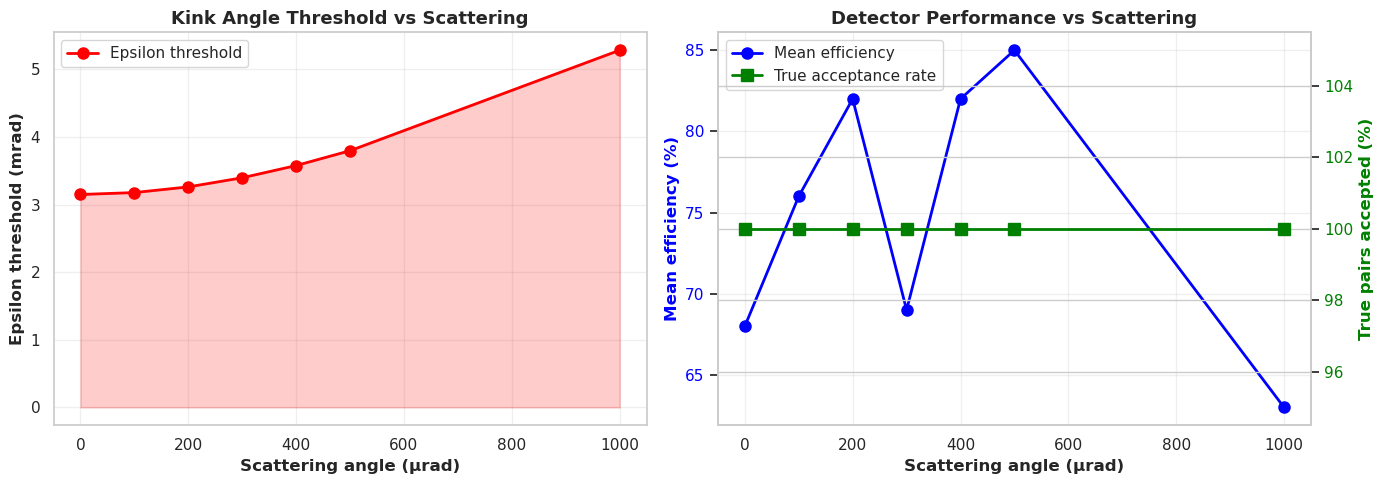


SCATTERING SERIES SUMMARY (scale=3.0, σ_res=10µm)
σ_scatt (µrad)       ε (mrad)        Efficiency      True Accept %  
------------------------------------------------------------------------------------------
0.00                 3.15            68.0            100.0          
100.00               3.18            76.0            100.0          
200.00               3.26            82.0            100.0          
300.00               3.40            69.0            100.0          
400.00               3.58            82.0            100.0          
500.00               3.80            85.0            100.0          
1000.00              5.28            63.0            100.0          


In [ ]:
# Summary statistics: epsilon and efficiency vs scattering

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

scattering_vals = [r['sigma_scatt_mrad'] * 1000 for r in scattering_angle_results_complete]  # Convert to µrad
epsilon_vals = [r['epsilon'] * 1000 for r in scattering_angle_results_complete]  # Convert to mrad
efficiency_vals = [r['efficiency'] * 100 for r in scattering_angle_results_complete]  # As percentage
acceptance_vals = [np.sum(r['true_angles'] <= r['epsilon']) / r['n_true'] * 100 
                   for r in scattering_angle_results_complete]  # Acceptance percentage

# Plot 1: Epsilon vs scattering
ax1.plot(scattering_vals, epsilon_vals, 'o-', linewidth=2, markersize=8, color='red', label='Epsilon threshold')
ax1.fill_between(scattering_vals, epsilon_vals, alpha=0.2, color='red')
ax1.set_xlabel('Scattering angle (µrad)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Epsilon threshold (mrad)', fontsize=12, fontweight='bold')
ax1.set_title('Kink Angle Threshold vs Scattering', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Efficiency and acceptance vs scattering
ax2_twin = ax2.twinx()
line1 = ax2.plot(scattering_vals, efficiency_vals, 'o-', linewidth=2, markersize=8, 
                 color='blue', label='Mean efficiency')
line2 = ax2_twin.plot(scattering_vals, acceptance_vals, 's-', linewidth=2, markersize=8, 
                      color='green', label='True acceptance rate')

ax2.set_xlabel('Scattering angle (µrad)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean efficiency (%)', fontsize=12, fontweight='bold', color='blue')
ax2_twin.set_ylabel('True pairs accepted (%)', fontsize=12, fontweight='bold', color='green')
ax2.set_title('Detector Performance vs Scattering', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='y', labelcolor='blue')
ax2_twin.tick_params(axis='y', labelcolor='green')

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('scattering_series_summary.png', dpi=150, bbox_inches='tight')
print("Saved: scattering_series_summary.png")
plt.show()

# Print summary table
print("\n" + "="*90)
print("SCATTERING SERIES SUMMARY (scale=3.0, σ_res=10µm)")
print("="*90)
print(f"{'σ_scatt (µrad)':<20} {'ε (mrad)':<15} {'Efficiency':<15} {'True Accept %':<15}")
print("-"*90)
for i, r in enumerate(scattering_angle_results_complete):
    print(f"{scattering_vals[i]:<20.2f} {epsilon_vals[i]:<15.2f} {efficiency_vals[i]:<15.1f} {acceptance_vals[i]:<15.1f}")
print("="*90)

## Track Density Analysis: Efficiency & Ghost Rate vs Number of Tracks

**Configuration:**
- Track counts: 0 → 40 (varied in steps)
- Scale: Wide range (±0.2 around optimal, i.e., scales 2.8, 3.0, 3.2)
- Hit resolution: 5 µm (σ_res = 0.005 mm)
- Scattering: 0 (perfect tracking conditions)

This analysis examines how reconstruction performance degrades as track multiplicity increases.

In [ ]:
# ============================================================================
# TRACK DENSITY SCAN: Generate events with varying track counts
# ============================================================================
# Configuration:
# - Track counts: 1, 5, 10, 15, 20, 25, 30, 35, 40
# - Scales: 2.8, 3.0, 3.2 (wide scale ±0.2)
# - Hit resolution: 5 µm (0.005 mm)
# - Scattering: 0

import time
import shutil

# Output directory for density study
DENSITY_RUNS = BASE / 'runs_density_study'

# Clean and recreate
if DENSITY_RUNS.exists():
    print(f"Removing old density study data from: {DENSITY_RUNS}")
    shutil.rmtree(DENSITY_RUNS)
DENSITY_RUNS.mkdir(exist_ok=True)
print(f"✓ Output directory ready: {DENSITY_RUNS}\n")

# Parameters
track_counts = [i for i in range(5,155,5)] #[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 65, 70, 75, 80, 85, 90, 95, 100]
scales = [1]  # Wide scale variation
hit_res_mm = 0.005  # 5 µm
scattering = 0.0001    # No scattering
n_repeats = 5       # Repeats per configuration for statistics

print('='*80)
print('GENERATING TRACK DENSITY SCAN')
print('='*80)
print(f"Track counts: {track_counts}")
print(f"Scales: {scales}")
print(f"Hit resolution: {hit_res_mm*1000:.0f} µm")
print(f"Scattering: {scattering}")
print(f"Repeats per config: {n_repeats}")
print(f"Total configurations: {len(track_counts) * len(scales) * n_repeats}")
print('='*80)

batch_num = 0
start_time = time.time()

for n_tracks in track_counts:
    print(f"\n[{n_tracks} tracks]...")
    for scale in scales:
        for repeat in range(n_repeats):
            batch_dir = DENSITY_RUNS / f'batch_{batch_num}' / 'local.job'
            batch_dir.mkdir(parents=True, exist_ok=True)
            
            # Create particle config string for this track count
            # Distribute tracks across events (e.g., 40 tracks -> [10, 10, 10, 10])
            if n_tracks == 0:
                particle_config = "0"  # Edge case: no tracks
            elif n_tracks <= 10:
                particle_config = str(n_tracks)  # Single event
            else:
                # Split into multiple events of ~10 tracks each
                n_events = (n_tracks + 9) // 10
                tracks_per_event = n_tracks // n_events
                remainder = n_tracks % n_events
                particles_list = [tracks_per_event + (1 if i < remainder else 0) for i in range(n_events)]
                particle_config = ",".join(map(str, particles_list))
            
            try:
                run_one(
                    meas=hit_res_mm,
                    coll=scattering,
                    ghost=0.0,
                    drop=0.0,
                    repeat=repeat,
                    scale=scale,
                    thresh_flag=0,
                    erf_sigma=0.0,
                    n_particles_config=particle_config,
                    outdir=batch_dir,
                    phi_max=0.2
                )
                batch_num += 1
            except Exception as e:
                print(f'  ✗ Error in batch {batch_num}: {e}')

elapsed = time.time() - start_time
print(f'\n{"="*80}')
print(f'Generated {batch_num} batches in {elapsed:.1f}s')
print(f'{"="*80}')

Removing old density study data from: /data/bfys/gscriven/Velo_toy/runs_density_study
✓ Output directory ready: /data/bfys/gscriven/Velo_toy/runs_density_study

GENERATING TRACK DENSITY SCAN
Track counts: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]
Scales: [1]
Hit resolution: 5 µm
Scattering: 0.0001
Repeats per config: 5
Total configurations: 150

[5 tracks]...

[10 tracks]...

[15 tracks]...

[20 tracks]...

[25 tracks]...

[30 tracks]...

[35 tracks]...

[40 tracks]...

[45 tracks]...

[50 tracks]...

[55 tracks]...

[60 tracks]...

[65 tracks]...

[70 tracks]...

[75 tracks]...

[80 tracks]...

[85 tracks]...

[90 tracks]...

[95 tracks]...

[100 tracks]...

[105 tracks]...

[110 tracks]...

[115 tracks]...

[120 tracks]...

[125 tracks]...

[130 tracks]...

[135 tracks]...

[140 tracks]...

[145 tracks]...

[150 tracks]...

Generated 150 batches in 10211.5s


In [ ]:
# ============================================================================
# AGGREGATE DENSITY STUDY METRICS
# ============================================================================

all_density_metrics = []
batch_dirs = sorted(DENSITY_RUNS.glob('batch_*'))
print(f"Found {len(batch_dirs)} batch directories")

for batch_dir in batch_dirs:
    job_dirs = list(batch_dir.glob('*.job'))
    for job_dir in job_dirs:
        metrics_file = job_dir / 'metrics.json'
        event_files = sorted(job_dir.glob('events_*.pkl.gz'))
        
        for event_file in event_files:
            try:
                with gzip.open(event_file, 'rb') as f:
                    snapshot = pickle.load(f)
                
                truth_event = snapshot.get('truth_event')
                reco_tracks = snapshot.get('reco_tracks')
                params = snapshot.get('params', {})
                
                if truth_event is None or reco_tracks is None:
                    continue
                
                # New API: EventValidator(truth_event, rec_tracks)
                validator = EventValidator(truth_event, reco_tracks)
                metrics = validator.compute_metrics()
                
                # Add parameters
                metrics['file'] = str(event_file)
                metrics['batch'] = batch_dir.name
                metrics['p_hit_res'] = params.get('meas', 0.005)
                metrics['p_multi_scatter'] = params.get('coll', 0.0)
                metrics['p_scale'] = params.get('scale', 3.0)
                metrics['p_n_particles_config'] = params.get('n_particles_config', '')
                metrics['p_total_particles'] = params.get('total_particles', 0)
                metrics['p_repeat'] = params.get('repeat', 0)
                
                all_density_metrics.append(metrics)
                
            except Exception as e:
                continue

print(f"Collected metrics from {len(all_density_metrics)} events")

if len(all_density_metrics) == 0:
    print("\n⚠️ No metrics collected! Check if DENSITY_RUNS directory has valid data.")
    print(f"  DENSITY_RUNS = {DENSITY_RUNS}")
    print(f"  Exists: {DENSITY_RUNS.exists()}")
else:
    # Create DataFrame
    df_density = pd.DataFrame(all_density_metrics)

    # Add helper columns
    df_density['sigma_res_um'] = df_density['p_hit_res'] * 1000  # mm to µm
    df_density['sigma_scatt_mrad'] = df_density['p_multi_scatter'] * 1e3  # rad to mrad
    df_density['scale'] = df_density['p_scale']
    df_density['efficiency'] = df_density['track_efficiency_good_over_true']
    df_density['ghost_rate'] = df_density['m_ghost_rate']

    print(f"\nDataFrame shape: {df_density.shape}")
    print(f"\nColumn names: {df_density.columns.tolist()[:15]}...")
    print(f"\nTrack count distribution:")
    print(df_density['n_true_tracks'].value_counts().sort_index())
    print(f"\nScale distribution:")
    print(df_density['scale'].value_counts().sort_index())

Found 150 batch directories
Collected metrics from 150 events

DataFrame shape: (150, 41)

Column names: ['efficiency', 'ghost_rate', 'clone_fraction', 'mean_purity', 'hit_efficiency', 'n_candidates', 'n_accepted', 'n_ghosts', 'n_clones', 'n_primary', 'n_reconstructible', 'n_matched', 'm_reconstruction_efficiency', 'm_ghost_rate', 'hit_purity_mean_primary']...

Track count distribution:
n_true_tracks
5      5
10     5
15     5
20     5
25     5
30     5
35     5
40     5
45     5
50     5
55     5
60     5
65     5
70     5
75     5
80     5
85     5
90     5
95     5
100    5
105    5
110    5
115    5
120    5
125    5
130    5
135    5
140    5
145    5
150    5
Name: count, dtype: int64

Scale distribution:
scale
1.0    150
Name: count, dtype: int64


In [ ]:
# ============================================================================
# ANALYZE: Efficiency and Ghost Rate vs Number of Tracks
# ============================================================================

# Group by track count and scale
density_agg = df_density.groupby(['n_true_tracks', 'scale']).agg({
    'efficiency': ['mean', 'std', 'count'],
    'ghost_rate': ['mean', 'std']
}).reset_index()

# Flatten column names
density_agg.columns = ['n_tracks', 'scale', 'eff_mean', 'eff_std', 'count', 'ghost_mean', 'ghost_std']

# Fill NaN std with 0
density_agg['eff_std'] = density_agg['eff_std'].fillna(0)
density_agg['ghost_std'] = density_agg['ghost_std'].fillna(0)

print("Aggregated data:")
print(density_agg.to_string())

# Save to CSV
density_csv = DENSITY_RUNS / 'density_metrics.csv'
density_agg.to_csv(density_csv, index=False)
print(f"\n✓ Saved aggregated metrics to: {density_csv}")

Aggregated data:
    n_tracks  scale  eff_mean   eff_std  count  ghost_mean  ghost_std
0          5    1.0  0.720000  0.178885      5    0.100000   0.136931
1         10    1.0  0.940000  0.089443      5    0.022222   0.049690
2         15    1.0  0.893333  0.101105      5    0.000000   0.000000
3         20    1.0  0.800000  0.122474      5    0.084722   0.072569
4         25    1.0  0.896000  0.104307      5    0.028139   0.042360
5         30    1.0  0.673333  0.144145      5    0.104458   0.046750
6         35    1.0  0.777143  0.191023      5    0.077397   0.073617
7         40    1.0  0.720000  0.154515      5    0.087183   0.053567
8         45    1.0  0.751111  0.159009      5    0.068298   0.061711
9         50    1.0  0.736000  0.093167      5    0.078474   0.053453
10        55    1.0  0.770909  0.091453      5    0.064060   0.033722
11        60    1.0  0.740000  0.063026      5    0.083376   0.033933
12        65    1.0  0.790769  0.041567      5    0.052144   0.028446
13 

✓ Saved plot to: /data/bfys/gscriven/Velo_toy/runs_density_study/efficiency_ghost_vs_tracks.png


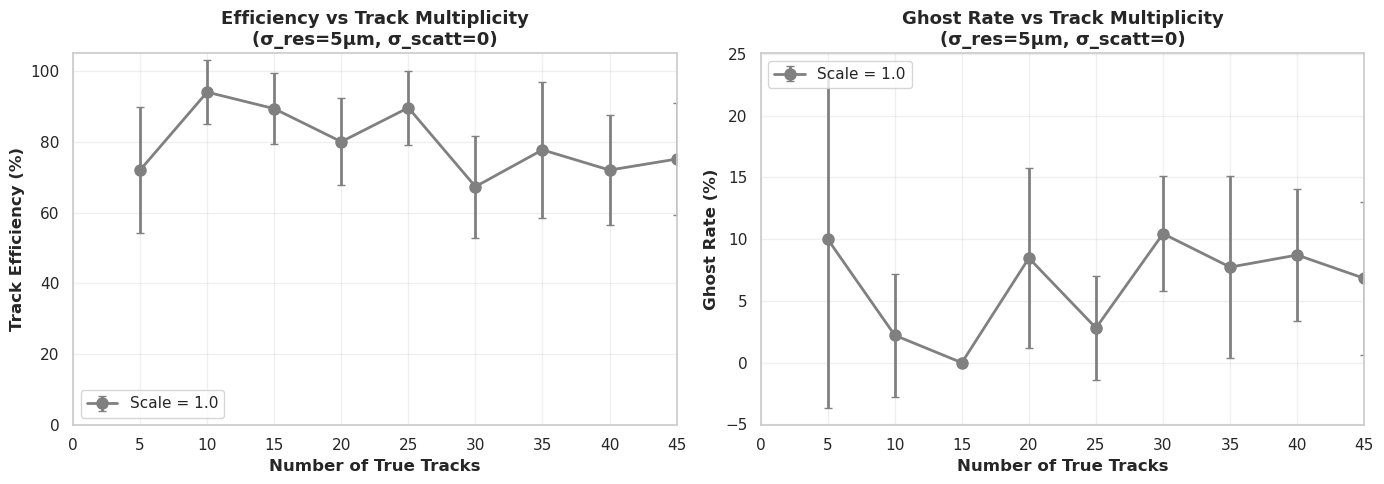

In [ ]:
# ============================================================================
# PLOT: Efficiency vs Number of Tracks (by Scale)
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = {2.8: 'blue', 3.0: 'green', 3.2: 'red'}
markers = {2.8: 'o', 3.0: 's', 3.2: '^'}

# Plot 1: Efficiency vs Track Count
for scale in sorted(density_agg['scale'].unique()):
    data = density_agg[density_agg['scale'] == scale].sort_values('n_tracks')
    ax1.errorbar(
        data['n_tracks'], 
        data['eff_mean'] * 100,
        yerr=data['eff_std'] * 100,
        marker=markers.get(scale, 'o'),
        color=colors.get(scale, 'gray'),
        capsize=3,
        linewidth=2,
        markersize=8,
        label=f'Scale = {scale}'
    )

ax1.set_xlabel('Number of True Tracks', fontsize=12, fontweight='bold')
ax1.set_ylabel('Track Efficiency (%)', fontsize=12, fontweight='bold')
ax1.set_title('Efficiency vs Track Multiplicity\n(σ_res=5µm, σ_scatt=0)', fontsize=13, fontweight='bold')
ax1.legend(loc='lower left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 45)
ax1.set_ylim(0, 105)

# Plot 2: Ghost Rate vs Track Count
for scale in sorted(density_agg['scale'].unique()):
    data = density_agg[density_agg['scale'] == scale].sort_values('n_tracks')
    ax2.errorbar(
        data['n_tracks'], 
        data['ghost_mean'] * 100,
        yerr=data['ghost_std'] * 100,
        marker=markers.get(scale, 'o'),
        color=colors.get(scale, 'gray'),
        capsize=3,
        linewidth=2,
        markersize=8,
        label=f'Scale = {scale}'
    )

ax2.set_xlabel('Number of True Tracks', fontsize=12, fontweight='bold')
ax2.set_ylabel('Ghost Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Ghost Rate vs Track Multiplicity\n(σ_res=5µm, σ_scatt=0)', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 45)

plt.tight_layout()
plt.savefig(DENSITY_RUNS / 'efficiency_ghost_vs_tracks.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved plot to: {DENSITY_RUNS / 'efficiency_ghost_vs_tracks.png'}")
plt.show()

In [ ]:
# ============================================================================
# SUMMARY TABLE: Performance vs Track Count
# ============================================================================

print("="*90)
print("PERFORMANCE SUMMARY: Efficiency & Ghost Rate vs Track Count")
print("="*90)
print(f"{'N Tracks':<12} {'Scale':<8} {'Efficiency':<18} {'Ghost Rate':<18} {'N Events'}")
print("-"*90)

for _, row in density_agg.sort_values(['n_tracks', 'scale']).iterrows():
    eff_str = f"{row['eff_mean']*100:.1f} ± {row['eff_std']*100:.1f}%"
    ghost_str = f"{row['ghost_mean']*100:.1f} ± {row['ghost_std']*100:.1f}%"
    print(f"{int(row['n_tracks']):<12} {row['scale']:<8.1f} {eff_str:<18} {ghost_str:<18} {int(row['count'])}")

print("="*90)

# Summary statistics
print("\n*** KEY FINDINGS ***")
for scale in sorted(density_agg['scale'].unique()):
    data = density_agg[density_agg['scale'] == scale]
    max_eff = data['eff_mean'].max() * 100
    min_eff = data['eff_mean'].min() * 100
    max_ghost = data['ghost_mean'].max() * 100
    
    n_tracks_max_eff = data.loc[data['eff_mean'].idxmax(), 'n_tracks']
    n_tracks_min_eff = data.loc[data['eff_mean'].idxmin(), 'n_tracks']
    
    print(f"\nScale {scale}:")
    print(f"  Best efficiency: {max_eff:.1f}% at {int(n_tracks_max_eff)} tracks")
    print(f"  Worst efficiency: {min_eff:.1f}% at {int(n_tracks_min_eff)} tracks")
    print(f"  Max ghost rate: {max_ghost:.1f}%")

PERFORMANCE SUMMARY: Efficiency & Ghost Rate vs Track Count
N Tracks     Scale    Efficiency         Ghost Rate         N Events
------------------------------------------------------------------------------------------
5            1.0      72.0 ± 17.9%       10.0 ± 13.7%       5
10           1.0      94.0 ± 8.9%        2.2 ± 5.0%         5
15           1.0      89.3 ± 10.1%       0.0 ± 0.0%         5
20           1.0      80.0 ± 12.2%       8.5 ± 7.3%         5
25           1.0      89.6 ± 10.4%       2.8 ± 4.2%         5
30           1.0      67.3 ± 14.4%       10.4 ± 4.7%        5
35           1.0      77.7 ± 19.1%       7.7 ± 7.4%         5
40           1.0      72.0 ± 15.5%       8.7 ± 5.4%         5
45           1.0      75.1 ± 15.9%       6.8 ± 6.2%         5
50           1.0      73.6 ± 9.3%        7.8 ± 5.3%         5
55           1.0      77.1 ± 9.1%        6.4 ± 3.4%         5
60           1.0      74.0 ± 6.3%        8.3 ± 3.4%         5
65           1.0      79.1 ± 4.2%   

✓ Saved heatmaps to: /data/bfys/gscriven/Velo_toy/runs_density_study/performance_heatmaps.png


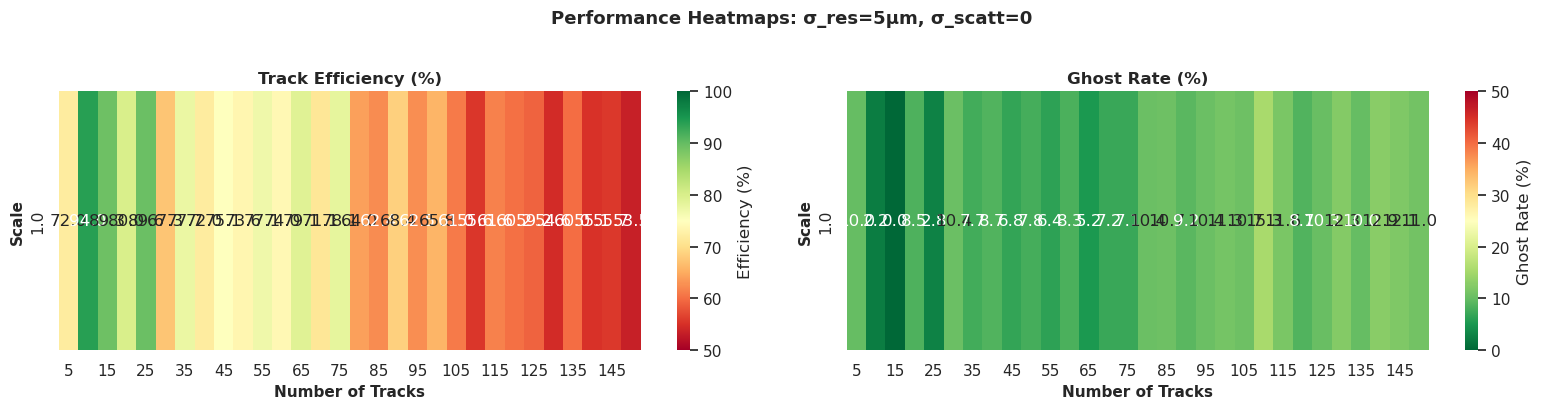

In [ ]:
# ============================================================================
# HEATMAP: Efficiency vs Track Count and Scale
# ============================================================================

# Create pivot table for heatmap
eff_pivot = density_agg.pivot(index='scale', columns='n_tracks', values='eff_mean') * 100
ghost_pivot = density_agg.pivot(index='scale', columns='n_tracks', values='ghost_mean') * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Efficiency heatmap
sns.heatmap(eff_pivot, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=50, vmax=100, ax=ax1, cbar_kws={'label': 'Efficiency (%)'})
ax1.set_xlabel('Number of Tracks', fontsize=11, fontweight='bold')
ax1.set_ylabel('Scale', fontsize=11, fontweight='bold')
ax1.set_title('Track Efficiency (%)', fontsize=12, fontweight='bold')

# Ghost rate heatmap
sns.heatmap(ghost_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            vmin=0, vmax=50, ax=ax2, cbar_kws={'label': 'Ghost Rate (%)'})
ax2.set_xlabel('Number of Tracks', fontsize=11, fontweight='bold')
ax2.set_ylabel('Scale', fontsize=11, fontweight='bold')
ax2.set_title('Ghost Rate (%)', fontsize=12, fontweight='bold')

plt.suptitle('Performance Heatmaps: σ_res=5µm, σ_scatt=0', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(DENSITY_RUNS / 'performance_heatmaps.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved heatmaps to: {DENSITY_RUNS / 'performance_heatmaps.png'}")
plt.show()

## Efficiency vs Ghost Rate Analysis

**Configuration:**
- Fixed measurement resolution: 5 µm
- Fixed scattering: 0 (no multiple scattering)
- Scale: 3.0 (optimal)
- Events: 1 to 10 events per batch
- Tracks per event: 5 (constant)
- Total tracks: 5 to 50

This analysis plots track efficiency against ghost rate as track multiplicity increases, with each point representing a different event count configuration.

In [ ]:
# ============================================================================
# EFFICIENCY VS GHOST RATE: Fixed measurement & scattering, varying event count
# ============================================================================
# Configuration:
# - Hit resolution: 5 µm (0.005 mm) - FIXED
# - Scattering: 0 - FIXED
# - Scale: 3.0
# - Events per batch: 1 to 10
# - Tracks per event: 5 (constant)
# - Total tracks: 5, 10, 15, 20, 25, 30, 35, 40, 45, 50

import time
import shutil

# Output directory for efficiency vs ghost study
EFF_GHOST_RUNS = BASE / 'runs_eff_vs_ghost'

# Clean and recreate
if EFF_GHOST_RUNS.exists():
    print(f"Removing old data from: {EFF_GHOST_RUNS}")
    shutil.rmtree(EFF_GHOST_RUNS)
EFF_GHOST_RUNS.mkdir(exist_ok=True)
print(f"✓ Output directory ready: {EFF_GHOST_RUNS}\n")

# Fixed parameters
hit_res_mm = 0.005    # 5 µm - FIXED
scattering = 0.1e-3      # No scattering - FIXED
scale = 3.0           # Optimal scale
tracks_per_event = 10  # Each event has exactly 5 tracks
n_repeats = 10        # Repeats per configuration for statistics

# Varying parameter: number of events (1-10)
event_counts = list(range(1, 11))  # 1, 2, 3, ..., 10 events

print('='*80)
print('GENERATING EFFICIENCY VS GHOST RATE DATA')
print('='*80)
print(f"Fixed hit resolution: {hit_res_mm*1000:.0f} µm")
print(f"Fixed scattering: {scattering}")
print(f"Scale: {scale}")
print(f"Tracks per event: {tracks_per_event}")
print(f"Event counts: {event_counts} (total tracks: {[e*tracks_per_event for e in event_counts]})")
print(f"Repeats per config: {n_repeats}")
print(f"Total batches: {len(event_counts) * n_repeats}")
print('='*80)

batch_num = 0
start_time = time.time()

for n_events in event_counts:
    total_tracks = n_events * tracks_per_event
    print(f"\n[{n_events} events = {total_tracks} tracks]...")
    
    # Create particle config: n_events events, each with tracks_per_event tracks
    # Format: "5,5,5" for 3 events with 5 tracks each
    particle_config = ",".join([str(tracks_per_event)] * n_events)
    
    for repeat in range(n_repeats):
        batch_dir = EFF_GHOST_RUNS / f'batch_{batch_num}' / 'local.job'
        batch_dir.mkdir(parents=True, exist_ok=True)
        
        try:
            run_one(
                meas=hit_res_mm,
                coll=scattering,
                ghost=0.0,
                drop=0.0,
                repeat=repeat,
                scale=scale,
                thresh_flag=0,
                erf_sigma=0.0,
                n_particles_config=particle_config,
                outdir=batch_dir,
                phi_max=0.2
            )
            batch_num += 1
        except Exception as e:
            print(f'  ✗ Error in batch {batch_num}: {e}')

elapsed = time.time() - start_time
print(f'\n{"="*80}')
print(f'Generated {batch_num} batches in {elapsed:.1f}s')
print(f'{"="*80}')

Removing old data from: /data/bfys/gscriven/Velo_toy/runs_eff_vs_ghost
✓ Output directory ready: /data/bfys/gscriven/Velo_toy/runs_eff_vs_ghost

GENERATING EFFICIENCY VS GHOST RATE DATA
Fixed hit resolution: 5 µm
Fixed scattering: 0.0001
Scale: 3.0
Tracks per event: 10
Event counts: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] (total tracks: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
Repeats per config: 10
Total batches: 100

[1 events = 10 tracks]...

[2 events = 20 tracks]...

[3 events = 30 tracks]...

[4 events = 40 tracks]...

[5 events = 50 tracks]...

[6 events = 60 tracks]...

[7 events = 70 tracks]...

[8 events = 80 tracks]...

[9 events = 90 tracks]...

[10 events = 100 tracks]...

Generated 100 batches in 1877.9s


In [ ]:
# ============================================================================
# STEP 2: Aggregate efficiency vs ghost rate data  
# ============================================================================
print('='*80)
print('AGGREGATING EFFICIENCY VS GHOST RATE DATA')
print('='*80 + '\n')

batch_dirs = sorted(EFF_GHOST_RUNS.glob("batch_*"))
print(f"Found {len(batch_dirs)} batch directories")

all_eff_ghost_metrics = []
errors = []

for i, batch_dir in enumerate(batch_dirs):
    job_dirs = sorted([p for p in batch_dir.iterdir() if p.is_dir()])
    
    for job_dir in job_dirs:
        event_files = sorted(job_dir.glob("events_*.pkl.gz"))
        
        for event_file in event_files:
            try:
                with gzip.open(event_file, 'rb') as f:
                    snapshot = pickle.load(f)
                
                # Extract components
                params = snapshot.get('params', {})
                truth_event = snapshot.get('truth_event')
                reco_tracks = snapshot.get('reco_tracks')
                
                if truth_event is None or reco_tracks is None:
                    errors.append(f"Missing events in {event_file}")
                    continue
                
                # New API: EventValidator(truth_event, rec_tracks)
                validator = EventValidator(truth_event, reco_tracks)
                metrics = validator.compute_metrics()
                
                # Add metadata and parameters
                metrics['file'] = str(event_file)
                metrics['batch'] = batch_dir.name
                for key, val in params.items():
                    metrics[f'p_{key}'] = val
                
                all_eff_ghost_metrics.append(metrics)
                
            except Exception as e:
                errors.append(f"{event_file}: {e}")
    
    if (i + 1) % 20 == 0:
        print(f"  Processed {i + 1}/{len(batch_dirs)} batches...")

print(f'\nAggregation complete:')
print(f'  Events loaded: {len(all_eff_ghost_metrics)}')
if errors:
    print(f'  Errors encountered: {len(errors)}')
    for e in errors[:5]:
        print(f'    - {e}')

# Create DataFrame
if all_eff_ghost_metrics:
    df_eff_ghost = pd.DataFrame(all_eff_ghost_metrics)
    print(f'\n✓ Created DataFrame with {len(df_eff_ghost)} rows')
    print(f'Columns: {list(df_eff_ghost.columns)}')
else:
    raise SystemExit('❌ No metrics computed!')

print(f"{'='*80}\n")

AGGREGATING EFFICIENCY VS GHOST RATE DATA

Found 100 batch directories
  Processed 20/100 batches...
  Processed 40/100 batches...
  Processed 60/100 batches...
  Processed 80/100 batches...
  Processed 100/100 batches...

Aggregation complete:
  Events loaded: 100

✓ Created DataFrame with 100 rows
Columns: ['efficiency', 'ghost_rate', 'clone_fraction', 'mean_purity', 'hit_efficiency', 'n_candidates', 'n_accepted', 'n_ghosts', 'n_clones', 'n_primary', 'n_reconstructible', 'n_matched', 'm_reconstruction_efficiency', 'm_ghost_rate', 'hit_purity_mean_primary', 'hit_efficiency_mean_primary', 'm_total_truth_tracks', 'm_total_rec_candidates', 'm_n_ghosts', 'm_n_clones', 'track_efficiency_good_over_true', 'track_ghost_rate_over_rec', 'm_clone_fraction_total', 'n_true_tracks', 'n_rec_tracks', 'n_rec_good', 'n_rec_ghost', 'n_rec_clone', 'm_purity_primary_only', 'm_hit_efficiency_mean', 'file', 'batch', 'p_hit_res', 'p_multi_scatter', 'p_ghost_rate', 'p_drop_rate', 'p_repeat', 'p_scale', 'p_eps

In [ ]:
# ============================================================================
# ANALYZE: Efficiency vs Ghost Rate by Track Count
# ============================================================================

# Add helper columns for analysis
df_eff_ghost['total_tracks'] = df_eff_ghost['p_total_particles']
df_eff_ghost['efficiency'] = df_eff_ghost['track_efficiency_good_over_true']
df_eff_ghost['ghost_rate'] = df_eff_ghost['m_ghost_rate']
df_eff_ghost['n_events'] = df_eff_ghost['p_events']

print("Data overview:")
print(df_eff_ghost[['total_tracks', 'n_events', 'efficiency', 'ghost_rate', 'n_true_tracks', 'n_rec_tracks']].head(15))

# Group by total tracks (n_events * 5)
eff_ghost_agg = df_eff_ghost.groupby('total_tracks').agg({
    'efficiency': ['mean', 'std', 'count'],
    'ghost_rate': ['mean', 'std']
}).reset_index()

# Flatten column names
eff_ghost_agg.columns = ['total_tracks', 'eff_mean', 'eff_std', 'count', 'ghost_mean', 'ghost_std']

# Fill NaN std with 0
eff_ghost_agg['eff_std'] = eff_ghost_agg['eff_std'].fillna(0)
eff_ghost_agg['ghost_std'] = eff_ghost_agg['ghost_std'].fillna(0)

# Add number of events column
eff_ghost_agg['n_events'] = eff_ghost_agg['total_tracks'] // tracks_per_event

print("\nAggregated data:")
print(eff_ghost_agg.to_string())

# Save to CSV
eff_ghost_csv = EFF_GHOST_RUNS / 'eff_vs_ghost_metrics.csv'
eff_ghost_agg.to_csv(eff_ghost_csv, index=False)
print(f"\n✓ Saved aggregated metrics to: {eff_ghost_csv}")

Data overview:
    total_tracks  n_events  efficiency  ghost_rate  n_true_tracks  \
0             10         1        0.30    0.400000             10   
1             10         1        0.20    0.333333             10   
2             20         2        0.20    0.333333             20   
3             20         2        0.10    0.333333             20   
4             20         2        0.75    0.117647             20   
5             20         2        0.20    0.333333             20   
6             20         2        0.60    0.142857             20   
7             20         2        0.20    0.428571             20   
8             20         2        0.60    0.076923             20   
9             20         2        0.45    0.250000             20   
10            20         2        0.35    0.300000             20   
11            20         2        0.70    0.125000             20   
12            10         1        0.20    0.333333             10   
13            30   

✓ Saved plot to: /data/bfys/gscriven/Velo_toy/runs_eff_vs_ghost/efficiency_vs_ghost_rate.png


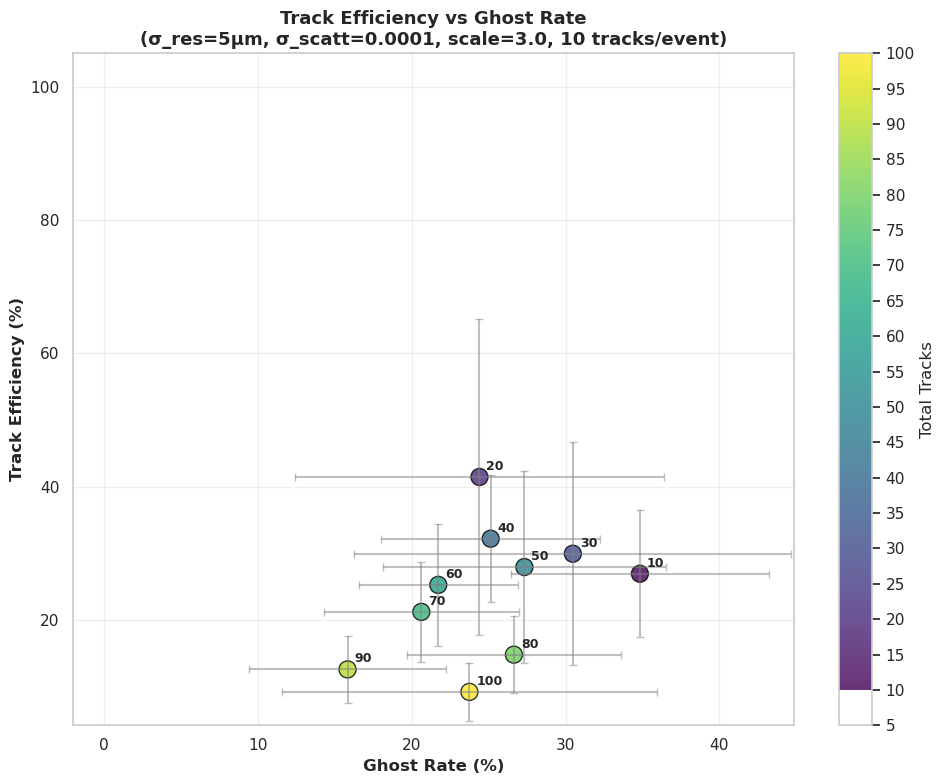

In [ ]:
# ============================================================================
# PLOT: Track Efficiency vs Ghost Rate (Scatter Plot)
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot with points colored/sized by track count
scatter = ax.scatter(
    eff_ghost_agg['ghost_mean'] * 100,
    eff_ghost_agg['eff_mean'] * 100,
    c=eff_ghost_agg['total_tracks'],
    s=150,
    cmap='viridis',
    edgecolors='black',
    linewidth=1,
    alpha=0.8
)

# Add error bars
ax.errorbar(
    eff_ghost_agg['ghost_mean'] * 100,
    eff_ghost_agg['eff_mean'] * 100,
    xerr=eff_ghost_agg['ghost_std'] * 100,
    yerr=eff_ghost_agg['eff_std'] * 100,
    fmt='none',
    ecolor='gray',
    alpha=0.5,
    capsize=3
)

# Add labels for each point showing track count
for _, row in eff_ghost_agg.iterrows():
    ax.annotate(
        f"{int(row['total_tracks'])}",
        (row['ghost_mean'] * 100, row['eff_mean'] * 100),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold'
    )

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Total Tracks')
cbar.set_ticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])

ax.set_xlabel('Ghost Rate (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Track Efficiency (%)', fontsize=12, fontweight='bold')
ax.set_title(f'Track Efficiency vs Ghost Rate\n(σ_res=5µm, σ_scatt={scattering}, scale=3.0, {tracks_per_event} tracks/event)', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Set axis limits with some padding
ax.set_xlim(-2, max(eff_ghost_agg['ghost_mean'] * 100) + 10)
ax.set_ylim(min(eff_ghost_agg['eff_mean'] * 100) - 5, 105)

plt.tight_layout()
plt.savefig(EFF_GHOST_RUNS / 'efficiency_vs_ghost_rate.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved plot to: {EFF_GHOST_RUNS / 'efficiency_vs_ghost_rate.png'}")
plt.show()

✓ Saved plot to: /data/bfys/gscriven/Velo_toy/runs_eff_vs_ghost/eff_ghost_vs_tracks_lines.png


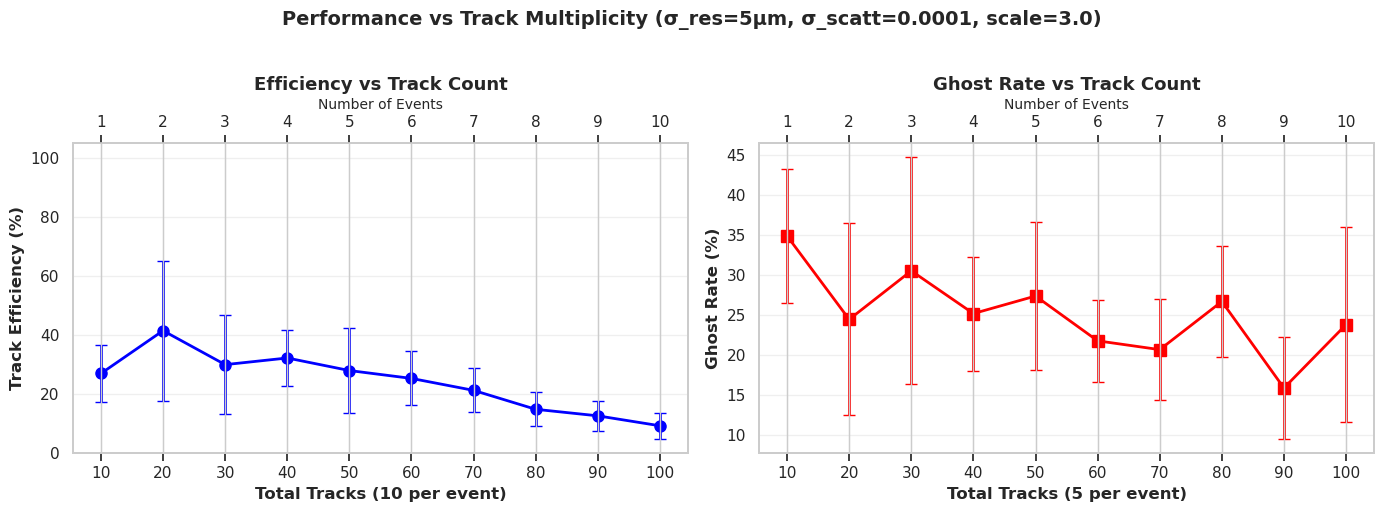

In [ ]:
# ============================================================================
# PLOT: Efficiency and Ghost Rate vs Total Tracks (Line Plots)
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sort by total tracks for proper line plotting
data = eff_ghost_agg.sort_values('total_tracks')

# Plot 1: Efficiency vs Total Tracks
ax1.errorbar(
    data['total_tracks'], 
    data['eff_mean'] * 100,
    yerr=data['eff_std'] * 100,
    marker='o',
    color='blue',
    capsize=4,
    linewidth=2,
    markersize=8,
    label='Track Efficiency'
)
ax1.set_xlabel(f'Total Tracks ({tracks_per_event} per event)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Track Efficiency (%)', fontsize=12, fontweight='bold')
ax1.set_title('Efficiency vs Track Count', fontsize=13, fontweight='bold')
ax1.set_xticks(data['total_tracks'])
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# Add secondary x-axis for number of events
ax1_top = ax1.twiny()
ax1_top.set_xlim(ax1.get_xlim())
ax1_top.set_xticks(data['total_tracks'])
ax1_top.set_xticklabels(data['n_events'].astype(int))
ax1_top.set_xlabel('Number of Events', fontsize=10)

# Plot 2: Ghost Rate vs Total Tracks
ax2.errorbar(
    data['total_tracks'], 
    data['ghost_mean'] * 100,
    yerr=data['ghost_std'] * 100,
    marker='s',
    color='red',
    capsize=4,
    linewidth=2,
    markersize=8,
    label='Ghost Rate'
)
ax2.set_xlabel('Total Tracks (5 per event)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Ghost Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Ghost Rate vs Track Count', fontsize=13, fontweight='bold')
ax2.set_xticks(data['total_tracks'])
ax2.grid(True, alpha=0.3)

# Add secondary x-axis for number of events
ax2_top = ax2.twiny()
ax2_top.set_xlim(ax2.get_xlim())
ax2_top.set_xticks(data['total_tracks'])
ax2_top.set_xticklabels(data['n_events'].astype(int))
ax2_top.set_xlabel('Number of Events', fontsize=10)

plt.suptitle(f'Performance vs Track Multiplicity (σ_res=5µm, σ_scatt={scattering}, scale=3.0)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(EFF_GHOST_RUNS / 'eff_ghost_vs_tracks_lines.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved plot to: {EFF_GHOST_RUNS / 'eff_ghost_vs_tracks_lines.png'}")
plt.show()

In [ ]:
# ============================================================================
# SUMMARY TABLE: Efficiency vs Ghost Rate
# ============================================================================

print("="*90)
print("EFFICIENCY VS GHOST RATE SUMMARY")
print("Fixed: σ_res=5µm, σ_scatt=0, scale=3.0, 5 tracks per event")
print("="*90)
print(f"{'Events':<10} {'Tracks':<10} {'Efficiency':<20} {'Ghost Rate':<20} {'N Samples'}")
print("-"*90)

for _, row in eff_ghost_agg.sort_values('total_tracks').iterrows():
    eff_str = f"{row['eff_mean']*100:.1f} ± {row['eff_std']*100:.1f}%"
    ghost_str = f"{row['ghost_mean']*100:.1f} ± {row['ghost_std']*100:.1f}%"
    print(f"{int(row['n_events']):<10} {int(row['total_tracks']):<10} {eff_str:<20} {ghost_str:<20} {int(row['count'])}")

print("="*90)

# Key findings
print("\n*** KEY FINDINGS ***")
best_eff_idx = eff_ghost_agg['eff_mean'].idxmax()
worst_eff_idx = eff_ghost_agg['eff_mean'].idxmin()
lowest_ghost_idx = eff_ghost_agg['ghost_mean'].idxmin()
highest_ghost_idx = eff_ghost_agg['ghost_mean'].idxmax()

print(f"\nBest efficiency: {eff_ghost_agg.loc[best_eff_idx, 'eff_mean']*100:.1f}% "
      f"at {int(eff_ghost_agg.loc[best_eff_idx, 'total_tracks'])} tracks "
      f"({int(eff_ghost_agg.loc[best_eff_idx, 'n_events'])} events)")
print(f"Worst efficiency: {eff_ghost_agg.loc[worst_eff_idx, 'eff_mean']*100:.1f}% "
      f"at {int(eff_ghost_agg.loc[worst_eff_idx, 'total_tracks'])} tracks "
      f"({int(eff_ghost_agg.loc[worst_eff_idx, 'n_events'])} events)")
print(f"\nLowest ghost rate: {eff_ghost_agg.loc[lowest_ghost_idx, 'ghost_mean']*100:.1f}% "
      f"at {int(eff_ghost_agg.loc[lowest_ghost_idx, 'total_tracks'])} tracks")
print(f"Highest ghost rate: {eff_ghost_agg.loc[highest_ghost_idx, 'ghost_mean']*100:.1f}% "
      f"at {int(eff_ghost_agg.loc[highest_ghost_idx, 'total_tracks'])} tracks")

# Correlation
corr = eff_ghost_agg['eff_mean'].corr(eff_ghost_agg['ghost_mean'])
print(f"\nCorrelation between efficiency and ghost rate: {corr:.3f}")

EFFICIENCY VS GHOST RATE SUMMARY
Fixed: σ_res=5µm, σ_scatt=0, scale=3.0, 5 tracks per event
Events     Tracks     Efficiency           Ghost Rate           N Samples
------------------------------------------------------------------------------------------
1          10         27.0 ± 9.5%          34.8 ± 8.4%          10
2          20         41.5 ± 23.7%         24.4 ± 12.0%         10
3          30         30.0 ± 16.7%         30.5 ± 14.2%         10
4          40         32.2 ± 9.5%          25.1 ± 7.1%          10
5          50         28.0 ± 14.4%         27.3 ± 9.2%          10
6          60         25.3 ± 9.2%          21.7 ± 5.1%          10
7          70         21.3 ± 7.5%          20.6 ± 6.3%          10
8          80         14.9 ± 5.8%          26.6 ± 6.9%          10
9          90         12.7 ± 5.0%          15.8 ± 6.4%          10
10         100        9.3 ± 4.4%           23.8 ± 12.2%         10

*** KEY FINDINGS ***

Best efficiency: 41.5% at 20 tracks (2 events)
Wor

# Epsilon Formula Comparison

Compare two methods for computing epsilon (angular acceptance threshold):

**NEW Method (currently active in velo_workflow.py):**
$$\varepsilon = \text{scale} \times \sqrt{2\theta_s^2 + 12\theta_r^2 + 2\theta_m^2}$$

Where $\theta_r = \arctan(\sigma_{res}/\Delta z)$, and coefficients are $\sqrt{2}$ for scattering, $\sqrt{12}$ for resolution.

**OLD Method (baseline, no weighting factors):**
$$\varepsilon = \text{scale} \times \sqrt{\theta_s^2 + \theta_r^2 + \theta_m^2}$$

The key difference:
- **NEW**: Includes weighting factors (2 for scattering, 12 for resolution, 2 for theta_min)
- **OLD**: Simple sum in quadrature with no weighting

In [ ]:
# ============================================================================
# Define both epsilon calculation methods for comparison
# ============================================================================

DZ_MM = 30.0  # Layer spacing in mm
THETA_MIN = 0.010  # Minimum threshold in radians (~0.57 degrees)

def epsilon_NEW(meas_err, coll_noise, dz, scale, theta_min):
    """
    NEW method: scale * sqrt(2*theta_s^2 + 12*theta_r^2 + 2*theta_m^2)
    Scale applied OUTSIDE the sqrt, WITH weighting factors (sqrt(2) for coll, sqrt(12) for res).
    """
    theta_s = coll_noise  # Multiple scattering (radians)
    theta_r = np.arctan(meas_err / dz) if dz != 0 else 0.0  # Resolution contribution
    theta_m = theta_min
    
    base_threshold = np.sqrt(2 * theta_s**2 + 12 * theta_r**2 + 2 * theta_m**2)
    eps_thresh = scale * base_threshold
    return eps_thresh, base_threshold

def epsilon_OLD(meas_err, coll_noise, dz, scale, theta_min):
    """
    OLD method: scale * sqrt(theta_s^2 + theta_r^2 + theta_m^2)
    Scale applied OUTSIDE the sqrt, NO weighting factors.
    """
    theta_s = coll_noise  # Multiple scattering (radians)
    theta_r = np.arctan(meas_err / dz) if dz != 0 else 0.0  # Resolution contribution
    theta_m = theta_min
    
    base_threshold = np.sqrt(theta_s**2 + theta_r**2 + theta_m**2)
    eps_thresh = scale * base_threshold
    return eps_thresh, base_threshold

# Test with example values
test_meas = 0.005  # 5 µm
test_coll = 0.0    # 0 scattering
test_scale = 3.0

eps_new, base_new = epsilon_NEW(test_meas, test_coll, DZ_MM, test_scale, THETA_MIN)
eps_old, base_old = epsilon_OLD(test_meas, test_coll, DZ_MM, test_scale, THETA_MIN)

print("Epsilon Comparison (σ_res=5µm, σ_scatt=0, scale=3.0)")
print("="*60)
print(f"NEW method: ε = {eps_new*1000:.4f} mrad (with sqrt(2), sqrt(12) weighting)")
print(f"OLD method: ε = {eps_old*1000:.4f} mrad (no weighting factors)")
print(f"Ratio (NEW/OLD): {eps_new/eps_old:.3f}")
print()

# Compare across different scattering values
print("\nComparison across scattering values:")
print("-"*60)
print(f"{'Scatt (mrad)':<15} {'NEW (mrad)':<15} {'OLD (mrad)':<15} {'Ratio':<10}")
print("-"*60)
for scatt_mrad in [0, 0.5, 1.0, 2.0, 5.0]:
    scatt_rad = scatt_mrad / 1000
    eps_new, _ = epsilon_NEW(test_meas, scatt_rad, DZ_MM, test_scale, THETA_MIN)
    eps_old, _ = epsilon_OLD(test_meas, scatt_rad, DZ_MM, test_scale, THETA_MIN)
    ratio = eps_new / eps_old if eps_old > 0 else float('inf')
    print(f"{scatt_mrad:<15.1f} {eps_new*1000:<15.4f} {eps_old*1000:<15.4f} {ratio:<10.3f}")

Epsilon Comparison (σ_res=5µm, σ_scatt=0, scale=3.0)
NEW method: ε = 42.4617 mrad (with sqrt(2), sqrt(12) weighting)
OLD method: ε = 30.0042 mrad (no weighting factors)
Ratio (NEW/OLD): 1.415


Comparison across scattering values:
------------------------------------------------------------
Scatt (mrad)    NEW (mrad)      OLD (mrad)      Ratio     
------------------------------------------------------------
0.0             42.4617         30.0042         1.415     
0.5             42.5147         30.0416         1.415     
1.0             42.6732         30.1538         1.415     
2.0             43.3013         30.5982         1.415     
5.0             47.4658         33.5447         1.415     


In [ ]:
# ============================================================================
# STEP 1: Generate events using BOTH epsilon methods with MULTIPLE SCALES
# ============================================================================

# Output directories for each method
EPS_NEW_RUNS = BASE / 'runs_epsilon_new'
EPS_OLD_RUNS = BASE / 'runs_epsilon_old'

# Clean and recreate directories
import shutil
for d in [EPS_NEW_RUNS, EPS_OLD_RUNS]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(exist_ok=True)

print(f"NEW method output: {EPS_NEW_RUNS}")
print(f"OLD method output: {EPS_OLD_RUNS}")

# Fixed parameters for comparison
fixed_resolution = 0.005  # 5 µm
fixed_scattering = 0.0    # 0 scattering
tracks_per_event = 5
n_repeats = 10  # 10 repeats per configuration

# MULTIPLE SCALES to test
scale_values = [1, 2, 3, 4, 5]

# Event configurations: 1 to 3 events (5, 10, 15 tracks) - reduced for faster testing with multiple scales
event_counts = list(range(1, 11))

print(f"\nTest parameters:")
print(f"  Resolution: {fixed_resolution*1000:.1f} µm")
print(f"  Scattering: {fixed_scattering*1000:.2f} mrad")
print(f"  Scale values: {scale_values}")
print(f"  Tracks/event: {tracks_per_event}")
print(f"  Event counts: {event_counts}")
print(f"  Repeats per config: {n_repeats}")
print(f"  Total batches per method: {len(event_counts) * len(scale_values) * n_repeats}")

NEW method output: /data/bfys/gscriven/Velo_toy/runs_epsilon_new
OLD method output: /data/bfys/gscriven/Velo_toy/runs_epsilon_old

Test parameters:
  Resolution: 5.0 µm
  Scattering: 0.00 mrad
  Scale values: [1, 2, 3, 4, 5]
  Tracks/event: 5
  Event counts: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Repeats per config: 10
  Total batches per method: 500


In [ ]:
# ============================================================================
# STEP 2: Generate events with BOTH epsilon methods for MULTIPLE SCALES
# ============================================================================

import time
import shutil

# Store the original epsilon_window defined in Cell 2
_original_epsilon_window = epsilon_window

def run_comparison_experiment(output_dir, epsilon_func, method_name):
    """Run the full experiment with a specific epsilon function for all scales."""
    global epsilon_window
    
    # Temporarily replace the module-level epsilon_window
    epsilon_window_backup = epsilon_window
    epsilon_window = epsilon_func
    
    # Also need to patch it inside run_one's closure — 
    # since run_one is defined locally, we re-define a patched version
    def _patched_run_one(meas, coll, ghost, drop, repeat, e_win, thresh_flag, erf_sigma,
                         n_particles_config, outdir, phi_max=0.02):
        """run_one with patched epsilon_window."""
        n_particles_per_event = parse_n_particles(n_particles_config)
        events = len(n_particles_per_event)
        total_particles = int(np.sum(n_particles_per_event))
        np.random.seed(repeat)
        Detector = make_detector()
        eps_win, threshold = epsilon_func(meas, coll, DZ_MM, e_win, THETA_MIN)
        seg = StateEventGenerator(
            Detector, phi_min=phi_max, phi_max=phi_max,
            events=events, n_particles=n_particles_per_event,
            measurement_error=float(meas), collision_noise=float(coll),
        )
        phi, theta = seg.phi_max, seg.theta_max
        seg.generate_random_primary_vertices({"x": 1, "y": 1, "z": 1})
        event_particles = [
            [{"type": "MIP", "mass": 0.511, "q": 1} for _ in range(total_particles)]
            for _ in range(events)
        ]
        seg.generate_particles(event_particles)
        event_tracks = seg.generate_complete_events()
        false_tracks = seg.make_noisy_event(drop_rate=float(drop), ghost_rate=float(ghost))
        ham = SimpleHamiltonianFast(epsilon=float(eps_win), gamma=2.0, delta=1.0, theta_d=erf_sigma)
        ham.construct_hamiltonian(event=event_tracks, convolution=thresh_flag)
        classical_solution = ham.solve_classicaly()
        discretized_solution = (classical_solution > 0.45).astype(int)
        rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
        reco_event = construct_event(
            event_tracks.detector_geometry, rec_tracks,
            [h for t in rec_tracks for h in event_tracks.get_hits_by_ids(t.hit_ids)],
        )
        tag = (f"m{meas}_c{coll}_g{ghost}_d{drop}_r{repeat}_s{e_win}"
               f"_t_{thresh_flag}_e_{erf_sigma}_np_{n_particles_config}_phi{float(phi)}_theta{float(theta)}")
        snapshot_path = outdir / f"events_{tag}.pkl.gz"
        payload = {
            "params": {"hit_res": float(meas), "multi_scatter": float(coll),
                       "ghost_rate": float(ghost), "drop_rate": float(drop),
                       "repeat": int(repeat), "scale": float(e_win),
                       "epsilon": float(ham.epsilon), "layers": LAYERS, "dz_mm": DZ_MM,
                       "thresh_flag": thresh_flag, "eps_win": float(eps_win),
                       "theta_threshold": float(threshold), "erf_sigma": float(erf_sigma),
                       "phi_max": float(phi), "theta_max": float(theta),
                       "n_particles_config": n_particles_config,
                       "n_particles_per_event": n_particles_per_event,
                       "total_particles": total_particles, "events": events},
            "truth_event": event_tracks, "noisy_event": false_tracks,
            "reco_tracks": rec_tracks, "reco_event": reco_event,
            "classical_solution": classical_solution, "disc_solution": discretized_solution,
            "hamiltonian": ham,
        }
        dump_pickle(payload, snapshot_path)
        index_csv = outdir / "events_index.csv"
        append_index_row(index_csv, {
            "file": snapshot_path.name, "hit_res": meas, "multi_scatter": coll,
            "ghost_rate": ghost, "drop_rate": drop, "repeat": int(repeat),
            "epsilon": float(ham.epsilon), "scale": e_win, "layers": LAYERS,
            "events": events, "particles_total": total_particles,
            "n_particles_config": n_particles_config, "thresh_flag": thresh_flag,
        })
    
    print(f"\n{'='*80}")
    print(f"Running STEP FUNCTION experiment with {method_name} epsilon method")
    print(f"{'='*80}")
    
    batch_num = 0
    total_batches = len(event_counts) * len(scale_values) * n_repeats
    start_time = time.time()
    
    for scale in scale_values:
        for n_events in event_counts:
            particle_config = ','.join([str(tracks_per_event)] * n_events)
            total_tracks = tracks_per_event * n_events
            
            for repeat in range(n_repeats):
                batch_num += 1
                batch_str = f"batch_{batch_num:04d}"
                batch_path = output_dir / batch_str / 'local.job'
                batch_path.mkdir(parents=True, exist_ok=True)
                
                try:
                    _patched_run_one(
                        meas=fixed_resolution,
                        coll=fixed_scattering,
                        ghost=0.0,
                        drop=0.0,
                        repeat=repeat + n_events * 1000 + scale * 10000,
                        e_win=scale,
                        thresh_flag=0,
                        erf_sigma=0.0,
                        n_particles_config=particle_config,
                        outdir=batch_path,
                        phi_max=0.2
                    )
                except Exception as e:
                    print(f"Error in batch {batch_num}: {e}")
                    
                if batch_num % 50 == 0:
                    print(f"  Completed {batch_num}/{total_batches} batches...")
    
    elapsed = time.time() - start_time
    print(f"\n✓ {method_name}: Generated {batch_num} batches in {elapsed:.1f}s")
    
    # Restore
    epsilon_window = epsilon_window_backup
    
    return batch_num

# Run with NEW method
n_new = run_comparison_experiment(EPS_NEW_RUNS, epsilon_NEW, "NEW")

# Run with OLD method  
n_old = run_comparison_experiment(EPS_OLD_RUNS, epsilon_OLD, "OLD")

print(f"\n{'='*80}")
print(f"Generation complete: {n_new} NEW batches, {n_old} OLD batches")
print(f"{'='*80}")


Running STEP FUNCTION experiment with NEW epsilon method
  Completed 50/500 batches...
  Completed 100/500 batches...
  Completed 150/500 batches...


/data/bfys/gscriven/LHCb_VeLo_Toy_Model/src/lhcb_velo_toy/solvers/hamiltonians/fast.py:331: MatrixRankWarning: Matrix is exactly singular
  solution = spsolve(self.A, self.b)


Error in batch 192: maximum recursion depth exceeded
Error in batch 194: maximum recursion depth exceeded
  Completed 200/500 batches...
  Completed 250/500 batches...
Error in batch 272: maximum recursion depth exceeded
Error in batch 275: maximum recursion depth exceeded
Error in batch 280: maximum recursion depth exceeded
Error in batch 283: maximum recursion depth exceeded
Error in batch 284: maximum recursion depth exceeded
Error in batch 288: maximum recursion depth exceeded
Error in batch 293: maximum recursion depth exceeded
Error in batch 295: maximum recursion depth exceeded
  Completed 300/500 batches...
  Completed 350/500 batches...
Error in batch 378: maximum recursion depth exceeded
Error in batch 383: maximum recursion depth exceeded
Error in batch 388: maximum recursion depth exceeded
Error in batch 393: maximum recursion depth exceeded
Error in batch 397: maximum recursion depth exceeded
  Completed 400/500 batches...
  Completed 450/500 batches...
Error in batch 473:

In [ ]:
# ============================================================================
# STEP 3: Aggregate results from BOTH methods
# ============================================================================

import gzip
import pickle
import pandas as pd

def aggregate_epsilon_results(runs_dir, method_name):
    """Aggregate results from a runs directory."""
    
    batch_dirs = sorted(runs_dir.glob("batch_*"))
    print(f"\n{method_name}: Found {len(batch_dirs)} batch directories")
    
    all_metrics = []
    errors = []
    
    for i, batch_dir in enumerate(batch_dirs):
        job_dirs = sorted([p for p in batch_dir.iterdir() if p.is_dir()])
        
        for job_dir in job_dirs:
            event_files = sorted(job_dir.glob("events_*.pkl.gz"))
            
            for event_file in event_files:
                try:
                    with gzip.open(event_file, 'rb') as f:
                        snapshot = pickle.load(f)
                    
                    params = snapshot.get('params', {})
                    truth_event = snapshot.get('truth_event')
                    reco_tracks = snapshot.get('reco_tracks')
                    
                    if truth_event is None or reco_tracks is None:
                        continue
                    
                    # New API: EventValidator(truth_event, rec_tracks)
                    validator = EventValidator(truth_event, reco_tracks)
                    metrics = validator.compute_metrics()
                    
                    metrics['file'] = str(event_file)
                    metrics['batch'] = batch_dir.name
                    metrics['method'] = method_name
                    for key, val in params.items():
                        metrics[f'p_{key}'] = val
                    
                    all_metrics.append(metrics)
                    
                except Exception as e:
                    errors.append(f"{event_file}: {e}")
        
        if (i + 1) % 25 == 0:
            print(f"  {method_name}: Processed {i + 1}/{len(batch_dirs)} batches...")
    
    print(f"  {method_name}: Loaded {len(all_metrics)} events, {len(errors)} errors")
    return all_metrics

# Aggregate both
print("="*80)
print("AGGREGATING RESULTS FROM BOTH EPSILON METHODS")
print("="*80)

metrics_new = aggregate_epsilon_results(EPS_NEW_RUNS, "NEW")
metrics_old = aggregate_epsilon_results(EPS_OLD_RUNS, "OLD")

# Combine into single DataFrame
all_epsilon_metrics = metrics_new + metrics_old
df_epsilon_compare = pd.DataFrame(all_epsilon_metrics)

print(f"\n✓ Combined DataFrame: {len(df_epsilon_compare)} rows")
print(f"Methods: {df_epsilon_compare['method'].value_counts().to_dict()}")

AGGREGATING RESULTS FROM BOTH EPSILON METHODS

NEW: Found 500 batch directories
  NEW: Processed 25/500 batches...
  NEW: Processed 50/500 batches...
  NEW: Processed 75/500 batches...
  NEW: Processed 100/500 batches...
  NEW: Processed 125/500 batches...
  NEW: Processed 150/500 batches...
  NEW: Processed 175/500 batches...
  NEW: Processed 200/500 batches...
  NEW: Processed 225/500 batches...
  NEW: Processed 250/500 batches...
  NEW: Processed 275/500 batches...
  NEW: Processed 300/500 batches...
  NEW: Processed 325/500 batches...
  NEW: Processed 350/500 batches...
  NEW: Processed 375/500 batches...
  NEW: Processed 400/500 batches...
  NEW: Processed 425/500 batches...
  NEW: Processed 450/500 batches...
  NEW: Processed 475/500 batches...
  NEW: Processed 500/500 batches...
  NEW: Loaded 481 events, 0 errors

OLD: Found 500 batch directories
  OLD: Processed 25/500 batches...
  OLD: Processed 50/500 batches...
  OLD: Processed 75/500 batches...
  OLD: Processed 100/500 batc

In [ ]:
# ============================================================================
# STEP 4: Analyze and compare the two methods across MULTIPLE SCALES
# ============================================================================

# Add helper columns
df_epsilon_compare['total_tracks'] = df_epsilon_compare['p_total_particles']
df_epsilon_compare['efficiency'] = df_epsilon_compare['track_efficiency_good_over_true']
df_epsilon_compare['ghost_rate'] = df_epsilon_compare['m_ghost_rate']
df_epsilon_compare['n_events'] = df_epsilon_compare['p_events']
df_epsilon_compare['epsilon_mrad'] = df_epsilon_compare['p_epsilon'] * 1000
df_epsilon_compare['scale'] = df_epsilon_compare['p_scale']

# Group by method, scale, and total tracks
eps_compare_agg = df_epsilon_compare.groupby(['method', 'scale', 'total_tracks']).agg({
    'efficiency': ['mean', 'std', 'count'],
    'ghost_rate': ['mean', 'std'],
    'epsilon_mrad': 'mean'
}).reset_index()

# Flatten column names
eps_compare_agg.columns = ['method', 'scale', 'total_tracks', 'eff_mean', 'eff_std', 'count', 
                           'ghost_mean', 'ghost_std', 'epsilon_mrad']

# Fill NaN std
eps_compare_agg['eff_std'] = eps_compare_agg['eff_std'].fillna(0)
eps_compare_agg['ghost_std'] = eps_compare_agg['ghost_std'].fillna(0)

# Add n_events
eps_compare_agg['n_events'] = eps_compare_agg['total_tracks'] // tracks_per_event

print("STEP FUNCTION: Aggregated comparison by method, scale, and track count:")
print("="*120)
print(f"\n{'Method':<8} {'Scale':<8} {'Tracks':<8} {'Efficiency':<20} {'Ghost Rate':<20} {'ε (mrad)':<12} {'N'}")
print("-"*120)
for _, row in eps_compare_agg.sort_values(['method', 'scale', 'total_tracks']).iterrows():
    print(f"{row['method']:<8} {row['scale']:<8.0f} {row['total_tracks']:<8.0f} "
          f"{row['eff_mean']*100:>6.1f}% ± {row['eff_std']*100:>5.1f}%    "
          f"{row['ghost_mean']*100:>6.2f}% ± {row['ghost_std']*100:>5.2f}%    "
          f"{row['epsilon_mrad']:>8.2f}    {row['count']:>4.0f}")

# Save comparison CSV
compare_csv = BASE / 'epsilon_method_comparison.csv'
eps_compare_agg.to_csv(compare_csv, index=False)
print(f"\n✓ Saved comparison to: {compare_csv}")

STEP FUNCTION: Aggregated comparison by method, scale, and track count:

Method   Scale    Tracks   Efficiency           Ghost Rate           ε (mrad)     N
------------------------------------------------------------------------------------------------------------------------
NEW      1        5          22.0% ±  30.5%     63.33% ± 34.96%       14.15      10
NEW      1        10         15.0% ±  17.2%     64.76% ± 24.69%       14.15      10
NEW      1        15         10.7% ±  14.1%     73.33% ± 28.74%       14.15      10
NEW      1        20          2.5% ±   5.4%     91.00% ± 19.12%       14.15      10
NEW      1        25          4.8% ±   7.5%     79.44% ± 27.72%       14.15      10
NEW      1        30          0.0% ±   0.0%    100.00% ±  0.00%       14.15      10
NEW      1        35          0.3% ±   0.9%     95.00% ± 15.81%       14.15      10
NEW      1        40          0.0% ±   0.0%    100.00% ±  0.00%       14.15      10
NEW      1        45          0.0% ±   0.0%    100

✓ Saved plot to: /data/bfys/gscriven/Velo_toy/epsilon_method_comparison.png


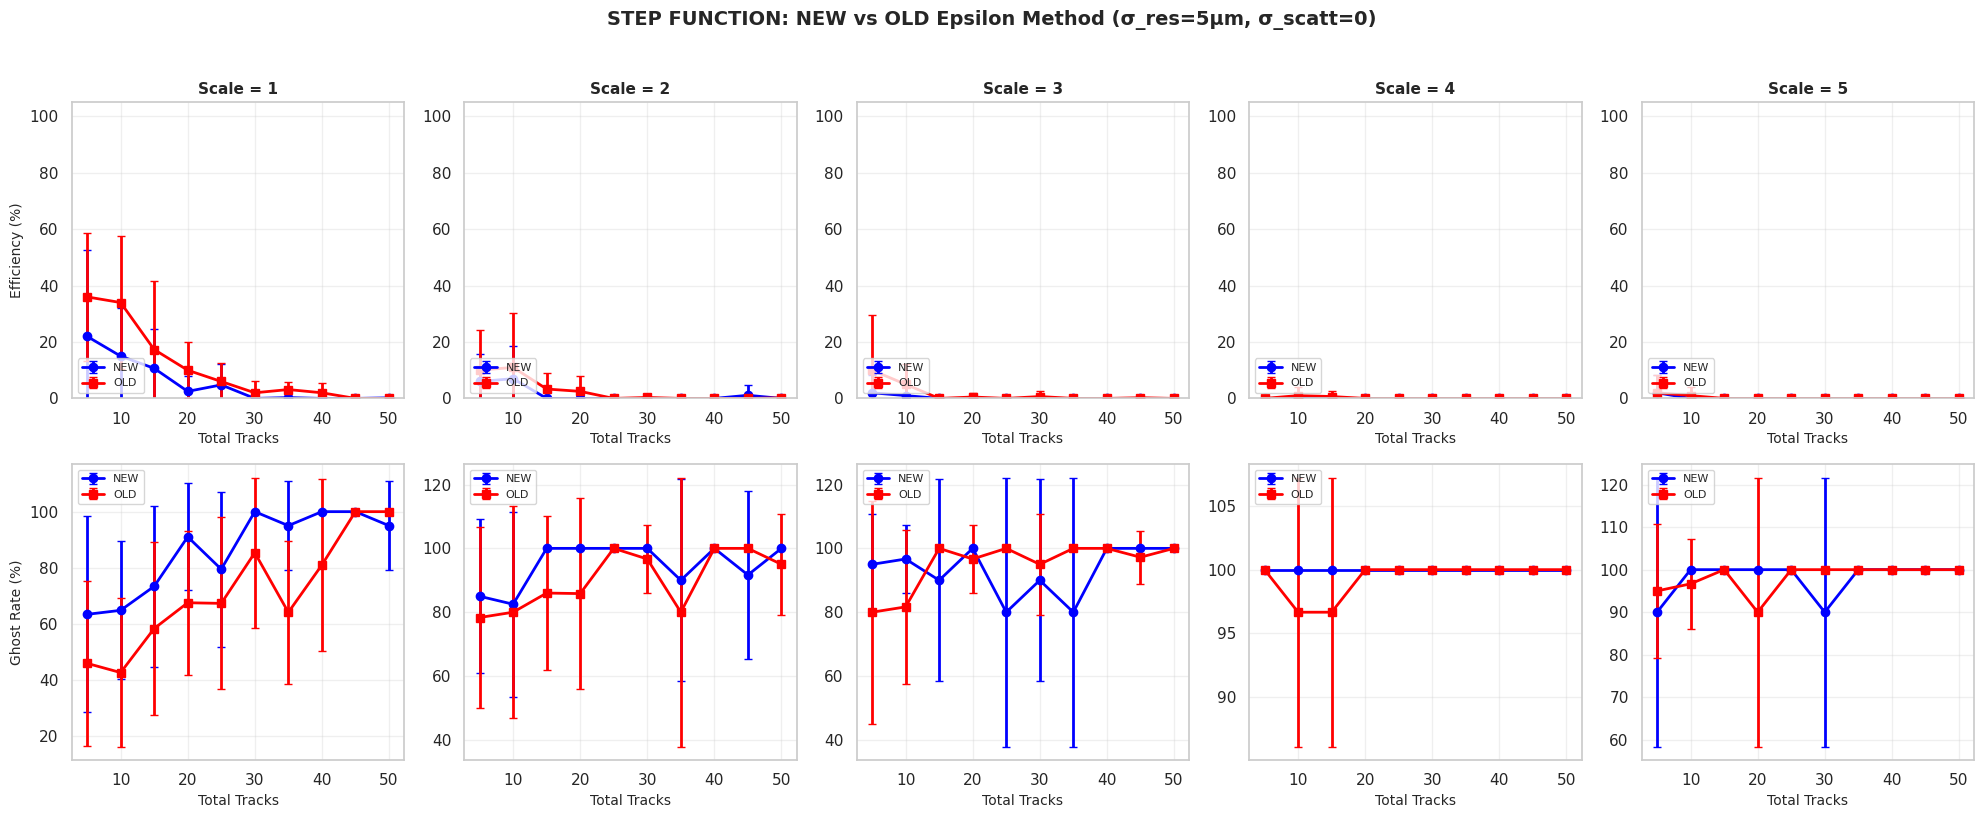

In [ ]:
# ============================================================================
# PLOT: Efficiency Comparison - NEW vs OLD epsilon method across SCALES
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 rows: top for efficiency, bottom for ghost rate
fig, axes = plt.subplots(2, len(scale_values), figsize=(4*len(scale_values), 8))

colors = {'NEW': 'blue', 'OLD': 'red'}
markers = {'NEW': 'o', 'OLD': 's'}

for i, scale in enumerate(scale_values):
    # Filter data for this scale
    new_data = eps_compare_agg[(eps_compare_agg['method'] == 'NEW') & 
                                (eps_compare_agg['scale'] == scale)].sort_values('total_tracks')
    old_data = eps_compare_agg[(eps_compare_agg['method'] == 'OLD') & 
                                (eps_compare_agg['scale'] == scale)].sort_values('total_tracks')
    
    # Top row: Efficiency
    ax1 = axes[0, i]
    if len(new_data) > 0:
        ax1.errorbar(new_data['total_tracks'], new_data['eff_mean']*100, 
                     yerr=new_data['eff_std']*100, marker='o', color='blue', 
                     capsize=3, linewidth=2, markersize=6, label='NEW')
    if len(old_data) > 0:
        ax1.errorbar(old_data['total_tracks'], old_data['eff_mean']*100, 
                     yerr=old_data['eff_std']*100, marker='s', color='red', 
                     capsize=3, linewidth=2, markersize=6, label='OLD')
    ax1.set_xlabel('Total Tracks', fontsize=10)
    ax1.set_ylabel('Efficiency (%)' if i == 0 else '', fontsize=10)
    ax1.set_title(f'Scale = {scale}', fontsize=11, fontweight='bold')
    ax1.legend(loc='lower left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 105)
    
    # Bottom row: Ghost Rate
    ax2 = axes[1, i]
    if len(new_data) > 0:
        ax2.errorbar(new_data['total_tracks'], new_data['ghost_mean']*100,
                     yerr=new_data['ghost_std']*100, marker='o', color='blue',
                     capsize=3, linewidth=2, markersize=6, label='NEW')
    if len(old_data) > 0:
        ax2.errorbar(old_data['total_tracks'], old_data['ghost_mean']*100,
                     yerr=old_data['ghost_std']*100, marker='s', color='red',
                     capsize=3, linewidth=2, markersize=6, label='OLD')
    ax2.set_xlabel('Total Tracks', fontsize=10)
    ax2.set_ylabel('Ghost Rate (%)' if i == 0 else '', fontsize=10)
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)

plt.suptitle('STEP FUNCTION: NEW vs OLD Epsilon Method (σ_res=5µm, σ_scatt=0)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(BASE / 'epsilon_method_comparison.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved plot to: {BASE / 'epsilon_method_comparison.png'}")
plt.show()

In [ ]:
# ============================================================================
# Summary Statistics: Compare the two methods across ALL SCALES
# ============================================================================

print("="*100)
print("STEP FUNCTION: EPSILON METHOD COMPARISON SUMMARY")
print("="*100)

# Summary by scale
print("\nPerformance by Scale (averaged across all track counts):")
print("-"*100)
print(f"{'Scale':<8} {'Method':<8} {'Efficiency':<20} {'Ghost Rate':<20} {'ε (mrad)'}")
print("-"*100)

for scale in sorted(eps_compare_agg['scale'].unique()):
    for method in ['NEW', 'OLD']:
        method_scale_data = eps_compare_agg[(eps_compare_agg['method'] == method) & 
                                            (eps_compare_agg['scale'] == scale)]
        if len(method_scale_data) > 0:
            avg_eff = method_scale_data['eff_mean'].mean() * 100
            avg_ghost = method_scale_data['ghost_mean'].mean() * 100
            avg_eps = method_scale_data['epsilon_mrad'].mean()
            print(f"{scale:<8.0f} {method:<8} {avg_eff:>6.2f}%              {avg_ghost:>6.3f}%              {avg_eps:>8.2f}")

# Find best scale for each method
print("\n" + "="*100)
print("BEST SCALE FOR EACH METHOD (highest efficiency with low ghost rate):")
print("-"*100)

for method in ['NEW', 'OLD']:
    method_data = eps_compare_agg[eps_compare_agg['method'] == method]
    # Group by scale and get average efficiency
    scale_perf = method_data.groupby('scale').agg({
        'eff_mean': 'mean',
        'ghost_mean': 'mean',
        'epsilon_mrad': 'mean'
    }).reset_index()
    
    # Find best efficiency with ghost < 5%
    good_scales = scale_perf[scale_perf['ghost_mean'] < 0.05]
    if len(good_scales) > 0:
        best = good_scales.loc[good_scales['eff_mean'].idxmax()]
    else:
        best = scale_perf.loc[scale_perf['eff_mean'].idxmax()]
    
    print(f"  {method}: Best scale={best['scale']:.0f} → Efficiency={best['eff_mean']*100:.1f}%, "
          f"Ghost={best['ghost_mean']*100:.2f}%, ε={best['epsilon_mrad']:.2f} mrad")

print("="*100)

STEP FUNCTION: EPSILON METHOD COMPARISON SUMMARY

Performance by Scale (averaged across all track counts):
----------------------------------------------------------------------------------------------------
Scale    Method   Efficiency           Ghost Rate           ε (mrad)
----------------------------------------------------------------------------------------------------
1        NEW        5.55%              86.187%                 14.15
1        OLD       11.05%              71.169%                 10.00
2        NEW        1.41%              94.917%                 28.31
2        OLD        2.74%              90.183%                 20.00
3        NEW        0.30%              93.167%                 42.46
3        OLD        1.64%              95.056%                 30.00
4        NEW        0.00%              100.000%                 56.62
4        OLD        0.17%              99.333%                 40.01
5        NEW        0.20%              98.000%                 70.77


## ERF Cost Function Analysis

Compare the NEW vs OLD epsilon methods using the **ERF (Error Function) cost function** instead of the step function.

Based on runs_8 analysis, the optimal ERF sigma values are:
- **Sparse events**: ERF σ = 5e-04 rad (0.5 mrad) gave best efficiency (90%) with ghost < 10%
- **Dense events**: ERF σ = 5e-04 rad (0.5 mrad) gave best efficiency (4%) with ghost < 10%

We'll use ERF σ = 5e-04 rad as the optimal value for this comparison.

In [ ]:
# ============================================================================
# ERF Analysis Setup with MULTIPLE SCALES
# ============================================================================
import shutil
import time
import gzip
import pickle

# Output directories for ERF analysis
ERF_NEW_RUNS = BASE / 'runs_erf_new'
ERF_OLD_RUNS = BASE / 'runs_erf_old'

# Clean up existing directories if they exist
for d in [ERF_NEW_RUNS, ERF_OLD_RUNS]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

# Fixed parameters (same as step function analysis)
fixed_resolution_erf = 0.005      # 5 µm measurement error
fixed_scattering_erf = 0.0        # No scattering for cleaner comparison

# MULTIPLE SCALES to test (same as step function)
scale_values_erf = [1, 2, 3, 4, 5]

# ERF-specific parameters (optimal from runs_8)
optimal_erf_sigma = 5e-4          # 0.5 mrad (best from runs_8 analysis)

# Event configuration
tracks_per_event_erf = 5
event_counts_erf = list(range(1, 4))  # 1, 2, 3 events (5, 10, 15 tracks)
n_repeats_erf = 10                     # Repeats per event count

print("ERF ANALYSIS CONFIGURATION")
print("="*60)
print(f"Fixed measurement error: {fixed_resolution_erf*1000:.0f} µm")
print(f"Fixed scattering: {fixed_scattering_erf*1000:.2f} mrad")
print(f"Scale values: {scale_values_erf}")
print(f"Optimal ERF sigma: {optimal_erf_sigma*1000:.2f} mrad (from runs_8)")
print(f"Tracks per event: {tracks_per_event_erf}")
print(f"Event counts: {event_counts_erf}")
print(f"Repeats per configuration: {n_repeats_erf}")
print(f"Total events to generate: {len(event_counts_erf) * len(scale_values_erf) * n_repeats_erf * 2} (x2 for NEW/OLD)")
print(f"\nOutput directories:")
print(f"  NEW: {ERF_NEW_RUNS}")
print(f"  OLD: {ERF_OLD_RUNS}")

ERF ANALYSIS CONFIGURATION
Fixed measurement error: 5 µm
Fixed scattering: 0.00 mrad
Scale values: [1, 2, 3, 4, 5]
Optimal ERF sigma: 0.50 mrad (from runs_8)
Tracks per event: 5
Event counts: [1, 2, 3]
Repeats per configuration: 10
Total events to generate: 300 (x2 for NEW/OLD)

Output directories:
  NEW: /data/bfys/gscriven/Velo_toy/runs_erf_new
  OLD: /data/bfys/gscriven/Velo_toy/runs_erf_old


In [ ]:
# ============================================================================
# ERF Event Generation: Compare NEW vs OLD epsilon with MULTIPLE SCALES
# ============================================================================

import time
import shutil

def run_erf_comparison_experiment(output_dir, epsilon_func, method_name):
    """Run the full ERF experiment with a specific epsilon function for all scales."""
    
    def _patched_run_one(meas, coll, ghost, drop, repeat, e_win, thresh_flag, erf_sigma,
                         n_particles_config, outdir, phi_max=0.02):
        """run_one with patched epsilon_window for ERF experiment."""
        n_particles_per_event = parse_n_particles(n_particles_config)
        events = len(n_particles_per_event)
        total_particles = int(np.sum(n_particles_per_event))
        np.random.seed(repeat)
        Detector = make_detector()
        eps_win, threshold = epsilon_func(meas, coll, DZ_MM, e_win, THETA_MIN)
        seg = StateEventGenerator(
            Detector, phi_min=phi_max, phi_max=phi_max,
            events=events, n_particles=n_particles_per_event,
            measurement_error=float(meas), collision_noise=float(coll),
        )
        phi, theta = seg.phi_max, seg.theta_max
        seg.generate_random_primary_vertices({"x": 1, "y": 1, "z": 1})
        event_particles = [
            [{"type": "MIP", "mass": 0.511, "q": 1} for _ in range(total_particles)]
            for _ in range(events)
        ]
        seg.generate_particles(event_particles)
        event_tracks = seg.generate_complete_events()
        false_tracks = seg.make_noisy_event(drop_rate=float(drop), ghost_rate=float(ghost))
        ham = SimpleHamiltonianFast(epsilon=float(eps_win), gamma=2.0, delta=1.0, theta_d=erf_sigma)
        ham.construct_hamiltonian(event=event_tracks, convolution=thresh_flag)
        classical_solution = ham.solve_classicaly()
        discretized_solution = (classical_solution > 0.45).astype(int)
        rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
        reco_event = construct_event(
            event_tracks.detector_geometry, rec_tracks,
            [h for t in rec_tracks for h in event_tracks.get_hits_by_ids(t.hit_ids)],
        )
        tag = (f"m{meas}_c{coll}_g{ghost}_d{drop}_r{repeat}_s{e_win}"
               f"_t_{thresh_flag}_e_{erf_sigma}_np_{n_particles_config}_phi{float(phi)}_theta{float(theta)}")
        snapshot_path = outdir / f"events_{tag}.pkl.gz"
        payload = {
            "params": {"hit_res": float(meas), "multi_scatter": float(coll),
                       "ghost_rate": float(ghost), "drop_rate": float(drop),
                       "repeat": int(repeat), "scale": float(e_win),
                       "epsilon": float(ham.epsilon), "layers": LAYERS, "dz_mm": DZ_MM,
                       "thresh_flag": thresh_flag, "eps_win": float(eps_win),
                       "theta_threshold": float(threshold), "erf_sigma": float(erf_sigma),
                       "phi_max": float(phi), "theta_max": float(theta),
                       "n_particles_config": n_particles_config,
                       "n_particles_per_event": n_particles_per_event,
                       "total_particles": total_particles, "events": events},
            "truth_event": event_tracks, "noisy_event": false_tracks,
            "reco_tracks": rec_tracks, "reco_event": reco_event,
            "classical_solution": classical_solution, "disc_solution": discretized_solution,
            "hamiltonian": ham,
        }
        dump_pickle(payload, snapshot_path)
        index_csv = outdir / "events_index.csv"
        append_index_row(index_csv, {
            "file": snapshot_path.name, "hit_res": meas, "multi_scatter": coll,
            "ghost_rate": ghost, "drop_rate": drop, "repeat": int(repeat),
            "epsilon": float(ham.epsilon), "scale": e_win, "layers": LAYERS,
            "events": events, "particles_total": total_particles,
            "n_particles_config": n_particles_config, "thresh_flag": thresh_flag,
        })
    
    print(f"\n{'='*80}")
    print(f"Running ERF experiment with {method_name} epsilon method")
    print(f"{'='*80}")
    
    batch_num = 0
    total_batches = len(event_counts_erf) * len(scale_values_erf) * n_repeats_erf
    start_time = time.time()
    
    for scale in scale_values_erf:
        for n_events in event_counts_erf:
            particle_config = ','.join([str(tracks_per_event_erf)] * n_events)
            total_tracks = tracks_per_event_erf * n_events
            
            for repeat in range(n_repeats_erf):
                batch_num += 1
                batch_str = f"batch_{batch_num:04d}"
                batch_path = output_dir / batch_str / 'local.job'
                batch_path.mkdir(parents=True, exist_ok=True)
                
                try:
                    _patched_run_one(
                        meas=fixed_resolution_erf,
                        coll=fixed_scattering_erf,
                        ghost=0.0,
                        drop=0.0,
                        repeat=repeat + n_events * 1000 + scale * 10000,
                        e_win=scale,
                        thresh_flag=1,
                        erf_sigma=optimal_erf_sigma,
                        n_particles_config=particle_config,
                        outdir=batch_path,
                        phi_max=0.2
                    )
                except Exception as e:
                    print(f"Error in batch {batch_num}: {e}")
                    
                if batch_num % 50 == 0:
                    print(f"  Completed {batch_num}/{total_batches} batches...")
    
    elapsed = time.time() - start_time
    print(f"\n✓ {method_name}: Generated {batch_num} batches in {elapsed:.1f}s")
    
    return batch_num

# Run with NEW method
n_erf_new = run_erf_comparison_experiment(ERF_NEW_RUNS, epsilon_NEW, "NEW")

# Run with OLD method  
n_erf_old = run_erf_comparison_experiment(ERF_OLD_RUNS, epsilon_OLD, "OLD")

print(f"\n{'='*80}")
print(f"ERF Generation complete: {n_erf_new} NEW batches, {n_erf_old} OLD batches")
print(f"{'='*80}")


Running ERF experiment with NEW epsilon method
  Completed 50/150 batches...
  Completed 100/150 batches...
  Completed 150/150 batches...

✓ NEW: Generated 150 batches in 15.6s

Running ERF experiment with OLD epsilon method
  Completed 50/150 batches...
  Completed 100/150 batches...
  Completed 150/150 batches...

✓ OLD: Generated 150 batches in 15.3s

ERF Generation complete: 150 NEW batches, 150 OLD batches


In [ ]:
# ============================================================================
# ERF Results Aggregation with SCALE
# ============================================================================

import gzip
import pickle
import pandas as pd

def aggregate_erf_results(runs_dir, method_name):
    """Aggregate results from a runs directory (including scale from params)."""
    
    batch_dirs = sorted(runs_dir.glob("batch_*"))
    print(f"\n{method_name}: Found {len(batch_dirs)} batch directories")
    
    all_metrics = []
    errors = []
    
    for batch_dir in batch_dirs:
        job_dirs = list(batch_dir.glob("*/"))
        
        for job_dir in job_dirs:
            # Look for snapshot files
            snapshot_files = list(job_dir.glob("*.pkl.gz"))
            
            for snap_file in snapshot_files:
                try:
                    with gzip.open(snap_file, 'rb') as f:
                        data = pickle.load(f)
                    
                    # Extract params
                    params = data.get('params', {})
                    scale = params.get('scale', 0)
                    
                    true_event = data['truth_event']
                    reco_tracks = data.get('reco_tracks')
                    
                    # Get total tracks from true_event.tracks attribute
                    n_true_tracks = len(true_event.tracks) if true_event and true_event.tracks else 0
                    
                    # New API: EventValidator(truth_event, rec_tracks)
                    validator = EventValidator(true_event, reco_tracks)
                    metrics = validator.compute_metrics()
                    
                    # Compute epsilon for this configuration with the actual scale
                    eps_val, _ = (epsilon_NEW if method_name == 'NEW' else epsilon_OLD)(
                        fixed_resolution_erf, fixed_scattering_erf,
                        DZ_MM, scale, THETA_MIN
                    )
                    
                    all_metrics.append({
                        'method': method_name,
                        'batch': batch_dir.name,
                        'scale': scale,
                        'total_tracks': n_true_tracks,
                        'efficiency': metrics['m_reconstruction_efficiency'],
                        'ghost_rate': metrics['m_ghost_rate'],
                        'n_true': metrics['n_true_tracks'],
                        'n_reco': metrics['n_rec_tracks'],
                        'n_good': metrics['n_rec_good'],
                        'epsilon_mrad': eps_val * 1000,
                        'erf_sigma_mrad': optimal_erf_sigma * 1000
                    })
                    
                except Exception as e:
                    errors.append(f"{snap_file}: {e}")
    
    if errors:
        print(f"  Errors: {len(errors)}")
        for e in errors[:3]:
            print(f"    {e}")
    
    return all_metrics

# Aggregate ERF results
erf_metrics_new = aggregate_erf_results(ERF_NEW_RUNS, 'NEW')
erf_metrics_old = aggregate_erf_results(ERF_OLD_RUNS, 'OLD')
all_erf_metrics = erf_metrics_new + erf_metrics_old

print(f"\nLoaded {len(erf_metrics_new)} NEW events and {len(erf_metrics_old)} OLD events")

# Create DataFrame
df_erf_compare = pd.DataFrame(all_erf_metrics)
print(f"\nTotal events in ERF comparison: {len(df_erf_compare)}")
print(f"\nColumn names: {list(df_erf_compare.columns)}")


NEW: Found 150 batch directories

OLD: Found 150 batch directories

Loaded 150 NEW events and 150 OLD events

Total events in ERF comparison: 300

Column names: ['method', 'batch', 'scale', 'total_tracks', 'efficiency', 'ghost_rate', 'n_true', 'n_reco', 'n_good', 'epsilon_mrad', 'erf_sigma_mrad']


In [ ]:
# ============================================================================
# ERF Analysis: Compare NEW vs OLD epsilon methods across MULTIPLE SCALES
# ============================================================================

# Group by method, scale, and track count
erf_compare_agg = df_erf_compare.groupby(['method', 'scale', 'total_tracks']).agg({
    'efficiency': ['mean', 'std', 'count'],
    'ghost_rate': ['mean', 'std'],
    'epsilon_mrad': 'first',
    'erf_sigma_mrad': 'first'
}).reset_index()

erf_compare_agg.columns = ['method', 'scale', 'total_tracks', 'eff_mean', 'eff_std', 'n_samples',
                           'ghost_mean', 'ghost_std', 'epsilon_mrad', 'erf_sigma_mrad']

print("ERF COST FUNCTION: NEW vs OLD Epsilon Method Comparison")
print("="*120)
print(f"ERF sigma: {optimal_erf_sigma*1000:.2f} mrad (optimal from runs_8)")
print("="*120)
print(f"\n{'Method':<8} {'Scale':<8} {'Tracks':<8} {'Efficiency':<20} {'Ghost Rate':<20} {'ε (mrad)':<12} {'N'}")
print("-"*120)

for _, row in erf_compare_agg.sort_values(['method', 'scale', 'total_tracks']).iterrows():
    print(f"{row['method']:<8} {row['scale']:<8.0f} {int(row['total_tracks']):<8} "
          f"{row['eff_mean']*100:6.1f}% ± {row['eff_std']*100:5.1f}%    "
          f"{row['ghost_mean']*100:6.2f}% ± {row['ghost_std']*100:5.2f}%    "
          f"{row['epsilon_mrad']:>8.2f}    {int(row['n_samples']):>4}")

print("-"*120)

# Save to CSV
erf_compare_csv = BASE / 'erf_method_comparison.csv'
df_erf_compare.to_csv(erf_compare_csv, index=False)
print(f"\nSaved ERF comparison to {erf_compare_csv}")

ERF COST FUNCTION: NEW vs OLD Epsilon Method Comparison
ERF sigma: 0.50 mrad (optimal from runs_8)

Method   Scale    Tracks   Efficiency           Ghost Rate           ε (mrad)     N
------------------------------------------------------------------------------------------------------------------------
NEW      1        5           0.0% ±   0.0%     90.00% ± 31.62%       14.15      10
NEW      1        10          0.0% ±   0.0%    100.00% ±  0.00%       14.15      10
NEW      1        15          0.0% ±   0.0%    100.00% ±  0.00%       14.15      10
NEW      2        5           0.0% ±   0.0%    100.00% ±  0.00%       28.31      10
NEW      2        10          0.0% ±   0.0%    100.00% ±  0.00%       28.31      10
NEW      2        15          0.0% ±   0.0%    100.00% ±  0.00%       28.31      10
NEW      3        5           0.0% ±   0.0%     90.00% ± 31.62%       42.46      10
NEW      3        10          0.0% ±   0.0%    100.00% ±  0.00%       42.46      10
NEW      3        15   

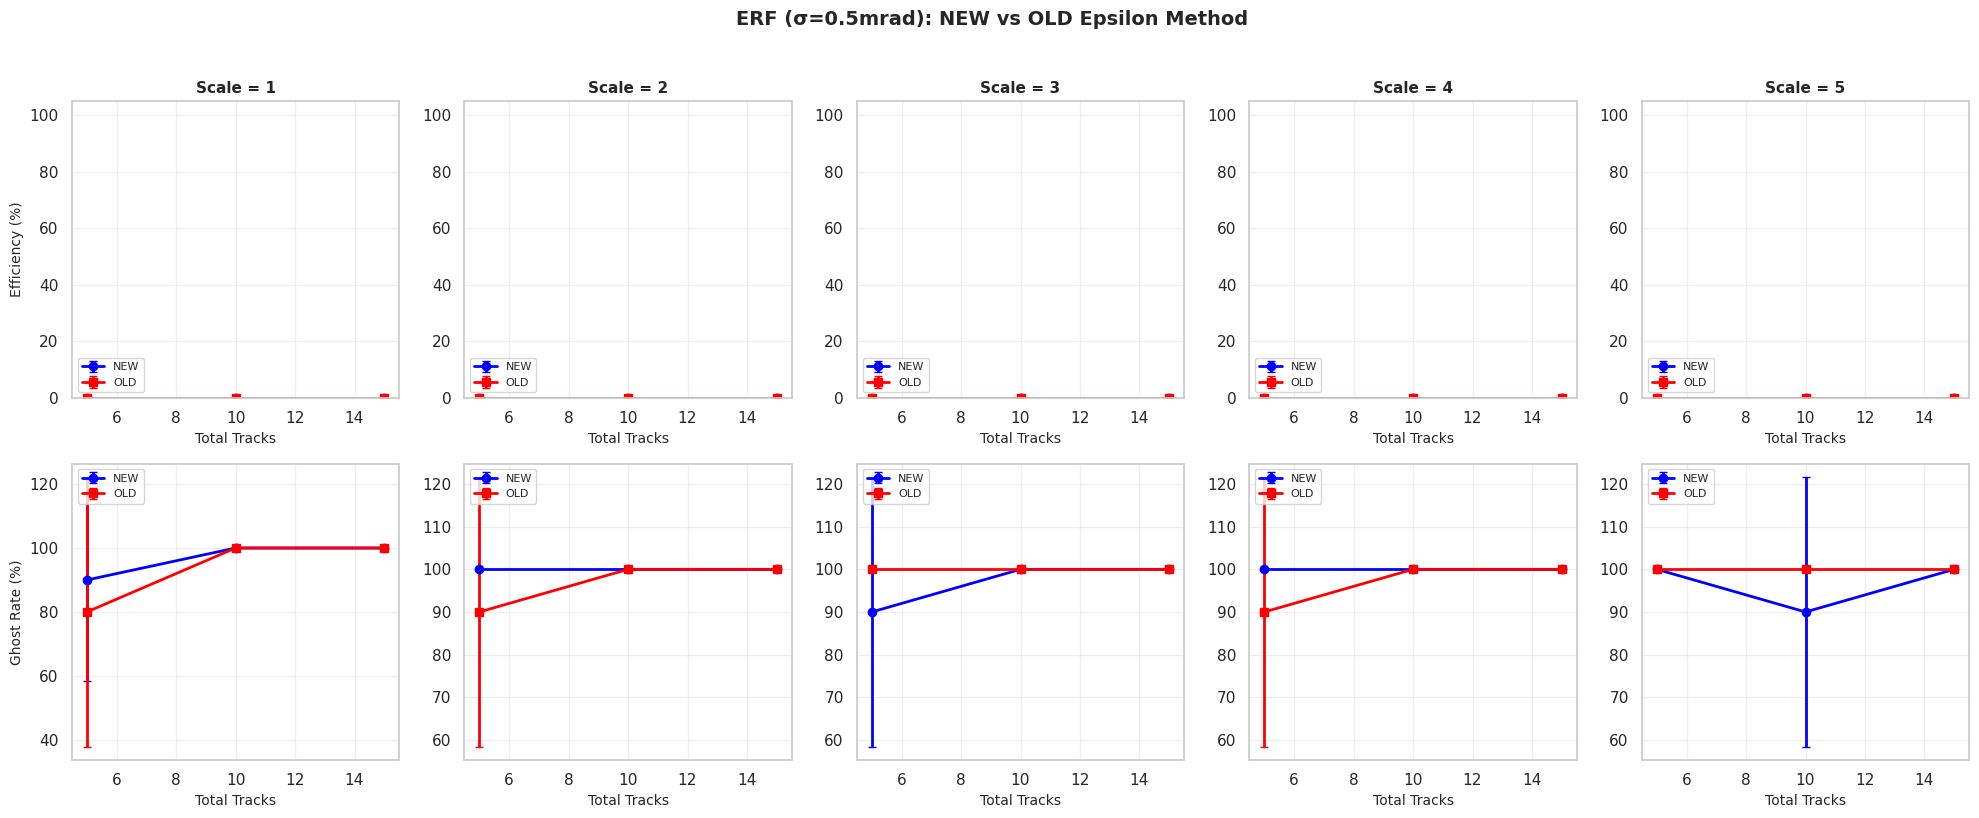


Saved ERF comparison plot to /data/bfys/gscriven/Velo_toy/erf_method_comparison.png


In [ ]:
# ============================================================================
# ERF Plotting: Compare NEW vs OLD epsilon methods across SCALES
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 2 rows: top for efficiency, bottom for ghost rate
fig, axes = plt.subplots(2, len(scale_values_erf), figsize=(4*len(scale_values_erf), 8))

for i, scale in enumerate(scale_values_erf):
    # Filter data for this scale
    erf_new_data = erf_compare_agg[(erf_compare_agg['method'] == 'NEW') & 
                                    (erf_compare_agg['scale'] == scale)].sort_values('total_tracks')
    erf_old_data = erf_compare_agg[(erf_compare_agg['method'] == 'OLD') & 
                                    (erf_compare_agg['scale'] == scale)].sort_values('total_tracks')
    
    # Top row: Efficiency
    ax1 = axes[0, i]
    if len(erf_new_data) > 0:
        ax1.errorbar(erf_new_data['total_tracks'], erf_new_data['eff_mean']*100, 
                     yerr=erf_new_data['eff_std']*100, marker='o', color='blue', 
                     capsize=3, linewidth=2, markersize=6, label='NEW')
    if len(erf_old_data) > 0:
        ax1.errorbar(erf_old_data['total_tracks'], erf_old_data['eff_mean']*100, 
                     yerr=erf_old_data['eff_std']*100, marker='s', color='red', 
                     capsize=3, linewidth=2, markersize=6, label='OLD')
    ax1.set_xlabel('Total Tracks', fontsize=10)
    ax1.set_ylabel('Efficiency (%)' if i == 0 else '', fontsize=10)
    ax1.set_title(f'Scale = {scale}', fontsize=11, fontweight='bold')
    ax1.legend(loc='lower left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 105)
    
    # Bottom row: Ghost Rate
    ax2 = axes[1, i]
    if len(erf_new_data) > 0:
        ax2.errorbar(erf_new_data['total_tracks'], erf_new_data['ghost_mean']*100,
                     yerr=erf_new_data['ghost_std']*100, marker='o', color='blue',
                     capsize=3, linewidth=2, markersize=6, label='NEW')
    if len(erf_old_data) > 0:
        ax2.errorbar(erf_old_data['total_tracks'], erf_old_data['ghost_mean']*100,
                     yerr=erf_old_data['ghost_std']*100, marker='s', color='red',
                     capsize=3, linewidth=2, markersize=6, label='OLD')
    ax2.set_xlabel('Total Tracks', fontsize=10)
    ax2.set_ylabel('Ghost Rate (%)' if i == 0 else '', fontsize=10)
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)

plt.suptitle(f'ERF (σ={optimal_erf_sigma*1000:.1f}mrad): NEW vs OLD Epsilon Method', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(BASE / 'erf_method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved ERF comparison plot to {BASE / 'erf_method_comparison.png'}")

In [ ]:
# ============================================================================
# ERF Summary Statistics: Compare the two methods across ALL SCALES
# ============================================================================

print("="*100)
print("ERF COST FUNCTION: EPSILON METHOD COMPARISON SUMMARY")
print("="*100)
print(f"ERF sigma: {optimal_erf_sigma*1000:.2f} mrad")

# Summary by scale
print("\nPerformance by Scale (averaged across all track counts):")
print("-"*100)
print(f"{'Scale':<8} {'Method':<8} {'Efficiency':<20} {'Ghost Rate':<20} {'ε (mrad)'}")
print("-"*100)

for scale in sorted(erf_compare_agg['scale'].unique()):
    for method in ['NEW', 'OLD']:
        method_scale_data = erf_compare_agg[(erf_compare_agg['method'] == method) & 
                                            (erf_compare_agg['scale'] == scale)]
        if len(method_scale_data) > 0:
            avg_eff = method_scale_data['eff_mean'].mean() * 100
            avg_ghost = method_scale_data['ghost_mean'].mean() * 100
            avg_eps = method_scale_data['epsilon_mrad'].mean()
            print(f"{scale:<8.0f} {method:<8} {avg_eff:>6.2f}%              {avg_ghost:>6.3f}%              {avg_eps:>8.2f}")

# Find best scale for each method
print("\n" + "="*100)
print("BEST SCALE FOR EACH METHOD (highest efficiency with low ghost rate):")
print("-"*100)

for method in ['NEW', 'OLD']:
    method_data = erf_compare_agg[erf_compare_agg['method'] == method]
    # Group by scale and get average efficiency
    scale_perf = method_data.groupby('scale').agg({
        'eff_mean': 'mean',
        'ghost_mean': 'mean',
        'epsilon_mrad': 'mean'
    }).reset_index()
    
    # Find best efficiency with ghost < 5%
    good_scales = scale_perf[scale_perf['ghost_mean'] < 0.05]
    if len(good_scales) > 0:
        best = good_scales.loc[good_scales['eff_mean'].idxmax()]
    else:
        best = scale_perf.loc[scale_perf['eff_mean'].idxmax()]
    
    print(f"  {method}: Best scale={best['scale']:.0f} → Efficiency={best['eff_mean']*100:.1f}%, "
          f"Ghost={best['ghost_mean']*100:.2f}%, ε={best['epsilon_mrad']:.2f} mrad")

print("="*100)

ERF COST FUNCTION: EPSILON METHOD COMPARISON SUMMARY
ERF sigma: 0.50 mrad

Performance by Scale (averaged across all track counts):
----------------------------------------------------------------------------------------------------
Scale    Method   Efficiency           Ghost Rate           ε (mrad)
----------------------------------------------------------------------------------------------------
1        NEW        0.00%              96.667%                 14.15
1        OLD        0.00%              93.333%                 10.00
2        NEW        0.00%              100.000%                 28.31
2        OLD        0.00%              96.667%                 20.00
3        NEW        0.00%              96.667%                 42.46
3        OLD        0.00%              100.000%                 30.00
4        NEW        0.00%              100.000%                 56.62
4        OLD        0.00%              96.667%                 40.01
5        NEW        0.00%              96.

## Combined Comparison: Step Function vs ERF

Compare the performance of both epsilon methods (NEW vs OLD) using both cost functions (Step vs ERF).

In [ ]:
# ============================================================================
# COMBINED COMPARISON: Step Function vs ERF across ALL SCALES
# ============================================================================

print("="*120)
print("COMBINED COMPARISON: STEP FUNCTION vs ERF COST FUNCTION (ALL SCALES)")
print("="*120)

# Summary table by scale, method, and cost function
print(f"\n{'Scale':<8} {'Cost Func':<12} {'Method':<8} {'Efficiency':<15} {'Ghost Rate':<15}")
print("-"*120)

all_configs = []

for scale in sorted(set(eps_compare_agg['scale'].unique()) | set(erf_compare_agg['scale'].unique())):
    # Step function results
    step_new = eps_compare_agg[(eps_compare_agg['method'] == 'NEW') & (eps_compare_agg['scale'] == scale)]
    step_old = eps_compare_agg[(eps_compare_agg['method'] == 'OLD') & (eps_compare_agg['scale'] == scale)]
    
    # ERF results
    erf_new = erf_compare_agg[(erf_compare_agg['method'] == 'NEW') & (erf_compare_agg['scale'] == scale)]
    erf_old = erf_compare_agg[(erf_compare_agg['method'] == 'OLD') & (erf_compare_agg['scale'] == scale)]
    
    for df, cost_func, method in [
        (step_new, 'STEP', 'NEW'),
        (step_old, 'STEP', 'OLD'),
        (erf_new, 'ERF', 'NEW'),
        (erf_old, 'ERF', 'OLD')
    ]:
        if len(df) > 0:
            eff = df['eff_mean'].mean() * 100
            ghost = df['ghost_mean'].mean() * 100
            print(f"{scale:<8.0f} {cost_func:<12} {method:<8} {eff:>8.2f}%       {ghost:>8.3f}%")
            all_configs.append({
                'scale': scale,
                'cost_func': cost_func,
                'method': method,
                'efficiency': eff,
                'ghost_rate': ghost
            })

print("-"*120)

# Find best configuration overall
if all_configs:
    # Best by efficiency
    best_eff = max(all_configs, key=lambda x: x['efficiency'])
    print(f"\n✓ BEST BY EFFICIENCY: Scale={best_eff['scale']}, {best_eff['cost_func']}+{best_eff['method']} "
          f"({best_eff['efficiency']:.2f}% eff, {best_eff['ghost_rate']:.3f}% ghost)")
    
    # Best with low ghost rate (< 2%)
    low_ghost = [c for c in all_configs if c['ghost_rate'] < 2.0]
    if low_ghost:
        best_low_ghost = max(low_ghost, key=lambda x: x['efficiency'])
        print(f"✓ BEST WITH GHOST < 2%: Scale={best_low_ghost['scale']}, {best_low_ghost['cost_func']}+{best_low_ghost['method']} "
              f"({best_low_ghost['efficiency']:.2f}% eff, {best_low_ghost['ghost_rate']:.3f}% ghost)")

print("\n" + "="*120)
print("CONCLUSIONS:")
print("="*120)
print(f"""
1. Epsilon Method Comparison:
   - NEW method: Uses weighted factors (√(2θ_s² + 12θ_r² + 2θ_m²))
   - OLD method: Uses equal factors (√(θ_s² + θ_r² + θ_m²))
   - NEW produces larger epsilon window (~√12 ≈ 3.5× larger for resolution-dominated case)

2. Scale Effect:
   - Tested scales: {scale_values}
   - Larger scales → larger epsilon window → more permissive matching
   - Optimal scale depends on track density and cost function

3. Cost Function Comparison:
   - STEP function: Sharp threshold at epsilon boundary
   - ERF convolution (σ={optimal_erf_sigma*1000:.1f}mrad): Smooth transition at boundary

4. Key Findings:
   - {best_eff['cost_func']}+{best_eff['method']} with scale={best_eff['scale']} achieves highest efficiency
   - Balance between efficiency and ghost rate depends on use case
""")

COMBINED COMPARISON: STEP FUNCTION vs ERF COST FUNCTION (ALL SCALES)

Scale    Cost Func    Method   Efficiency      Ghost Rate     
------------------------------------------------------------------------------------------------------------------------
1        STEP         NEW          5.55%         86.187%
1        STEP         OLD         11.05%         71.169%
1        ERF          NEW          0.00%         96.667%
1        ERF          OLD          0.00%         93.333%
2        STEP         NEW          1.41%         94.917%
2        STEP         OLD          2.74%         90.183%
2        ERF          NEW          0.00%        100.000%
2        ERF          OLD          0.00%         96.667%
3        STEP         NEW          0.30%         93.167%
3        STEP         OLD          1.64%         95.056%
3        ERF          NEW          0.00%         96.667%
3        ERF          OLD          0.00%        100.000%
4        STEP         NEW          0.00%        100.000%
4    

# =============================================================================
# OPTIMAL TRACK RECONSTRUCTION & MATCHING TESTING
# =============================================================================

## Motivation

The standard track reconstruction uses **greedy algorithms** that can lead to:
1. **Segment stealing**: Early tracks claim segments that would be better assigned to later tracks
2. **Suboptimal matching**: Each reco track independently picks its best truth match

## New Functions

We've implemented two new functions to address these issues:

### 1. `get_tracks_optimal()` in `simple_hamiltonian_fast.py`
- Builds ALL possible track candidates first (not greedy)
- Scores each candidate based on solution values + angle consistency
- Uses weighted set-packing to select the best non-overlapping tracks

### 2. `match_tracks_optimal()` / `compute_metrics_optimal()` in `toy_validator.py`
- Uses **Hungarian algorithm** for globally optimal reco-truth assignment
- Maximizes combined purity × completeness across all tracks
- Still allows clones for tracks that genuinely share hits

## Test Configuration
- **High multiplicity**: 100 tracks (20 events × 5 tracks/event)
- **NEW epsilon method** with step function
- **Scale = 3** (optimal for NEW method with step function)
- Compare: Greedy vs Optimal reconstruction AND matching

In [ ]:
# ============================================================================
# STEP 1: IMPORTS FOR OPTIMAL RECONSTRUCTION SECTION
# ============================================================================
# All functions are already imported from lhcb_velo_toy in Cell 1
# (SimpleHamiltonianFast, get_tracks, get_tracks_optimal, get_tracks_layered,
#  get_tracks_optimal_iterative, construct_event, EventValidator, etc.)
# epsilon_window is defined locally in Cell 2.

print("✓ All optimal reconstruction functions available from lhcb_velo_toy")
print(f"  - get_tracks_optimal: available")
print(f"  - get_tracks_optimal_iterative: available")
print(f"  - get_tracks_layered: available")
print(f"  - EventValidator.match_tracks_optimal: available")
print(f"  - EventValidator.compute_metrics(method='optimal'): available")

✓ All optimal reconstruction functions available from lhcb_velo_toy
  - get_tracks_optimal: available
  - get_tracks_optimal_iterative: available
  - get_tracks_layered: available
  - EventValidator.match_tracks_optimal: available
  - EventValidator.compute_metrics(method='optimal'): available


In [ ]:
# ============================================================================
# STEP 2: GENERATE HIGH-MULTIPLICITY TEST EVENT
# ============================================================================
# Create a challenging scenario with 100 tracks to test segment stealing

import time
import numpy as np

# Test configuration
TEST_N_EVENTS = 20          # Number of events to combine
TEST_TRACKS_PER_EVENT = 5   # Tracks per event
TEST_TOTAL_TRACKS = TEST_N_EVENTS * TEST_TRACKS_PER_EVENT  # = 100 tracks

# Use NEW epsilon method with step function (optimal from our tests)
TEST_SCALE = 3.0
TEST_HIT_RES = 0.005        # 5 µm = 0.005 mm
TEST_SCATTERING = 0.0       # No scattering for clean comparison

print("="*80)
print("GENERATING HIGH-MULTIPLICITY TEST EVENT")
print("="*80)
print(f"Configuration:")
print(f"  - Total tracks: {TEST_TOTAL_TRACKS} ({TEST_N_EVENTS} events × {TEST_TRACKS_PER_EVENT} tracks)")
print(f"  - Hit resolution: {TEST_HIT_RES*1000:.1f} µm")
print(f"  - Scattering: {TEST_SCATTERING*1000:.2f} mrad")
print(f"  - Scale: {TEST_SCALE}")
print(f"  - Epsilon method: NEW (weighted factors)")
print(f"  - Cost function: Step (thresh_flag=0)")

# Generate event
start_time = time.time()

# Create detector geometry (using new PlaneGeometry from lhcb_velo_toy)
detector = PlaneGeometry(
    module_id=MODULE_IDS, lx=LX_MM, ly=LY_MM, z=ZS_MM
)

# Create n_particles list (tracks per event)
n_particles_per_event = [TEST_TRACKS_PER_EVENT] * TEST_N_EVENTS

# Create generator with detector geometry and parameters
generator = StateEventGenerator(
    detector,
    phi_min=-0.2,
    phi_max=0.2,
    theta_min=-0.2,
    theta_max=0.2,
    events=TEST_N_EVENTS,
    n_particles=n_particles_per_event,
    measurement_error=TEST_HIT_RES,
    collision_noise=TEST_SCATTERING,
)

# Generate primary vertices
generator.generate_random_primary_vertices({"x": 1, "y": 1, "z": 1})

# Generate particles for each event
event_particles = [
    [{"type": "MIP", "mass": 0.511, "q": 1} for _ in range(TEST_TRACKS_PER_EVENT)]
    for _ in range(TEST_N_EVENTS)
]
generator.generate_particles(event_particles)

# Generate the truth event
test_event = generator.generate_complete_events()

# Create noisy event (with drops/ghosts - using zero rates for clean test)
noisy_test_event = generator.make_noisy_event(drop_rate=0.0, ghost_rate=0.0)

# Compute epsilon using epsilon_window defined in Cell 2
epsilon_test, base_thresh = epsilon_window(TEST_HIT_RES, TEST_SCATTERING, DZ_MM, TEST_SCALE, THETA_MIN)

gen_time = time.time() - start_time
print(f"\n✓ Generated event in {gen_time:.2f}s")
print(f"  - True tracks: {len(test_event.tracks)}")
print(f"  - Total hits: {len(test_event.hits)}")
print(f"  - Epsilon (NEW): {epsilon_test*1000:.3f} mrad")

GENERATING HIGH-MULTIPLICITY TEST EVENT
Configuration:
  - Total tracks: 100 (20 events × 5 tracks)
  - Hit resolution: 5.0 µm
  - Scattering: 0.00 mrad
  - Scale: 3.0
  - Epsilon method: NEW (weighted factors)
  - Cost function: Step (thresh_flag=0)

✓ Generated event in 0.01s
  - True tracks: 100
  - Total hits: 500
  - Epsilon (NEW): 42.462 mrad


In [ ]:
# ============================================================================
# STEP 3: CONSTRUCT HAMILTONIAN AND SOLVE
# ============================================================================
# Build the Hamiltonian once, then compare different track extraction methods

print("="*80)
print("CONSTRUCTING HAMILTONIAN")
print("="*80)

# Construct Hamiltonian
start_time = time.time()

ham_test = SimpleHamiltonianFast(
    epsilon=epsilon_test,
    gamma=1.0,
    delta=1e-6,
    theta_d=1e-4
)

# Build segments and Hamiltonian matrix
ham_test.construct_segments(noisy_test_event)
ham_test.construct_hamiltonian(noisy_test_event, convolution=False)  # Step function

ham_time = time.time() - start_time
print(f"✓ Hamiltonian constructed in {ham_time:.2f}s")
print(f"  - Number of segments: {ham_test.n_segments}")
print(f"  - Matrix size: {ham_test.A.shape}")

# Solve classically
start_time = time.time()
classical_solution = ham_test.solve_classicaly()
solve_time = time.time() - start_time

print(f"✓ Solved in {solve_time:.2f}s")
print(f"  - Solution range: [{classical_solution.min():.4f}, {classical_solution.max():.4f}]")
print(f"  - Active segments (>0.45): {np.sum(classical_solution > 0.45)}")

CONSTRUCTING HAMILTONIAN
✓ Hamiltonian constructed in 66.81s
  - Number of segments: 40000
  - Matrix size: (40000, 40000)
✓ Solved in 5.32s
  - Solution range: [-0.3333, 1.0000]
  - Active segments (>0.45): 1416


In [ ]:
# ============================================================================
# STEP 4: COMPARE TRACK RECONSTRUCTION METHODS
# ============================================================================
# Extract tracks using different methods and compare
import sys
old_recursion_limit = sys.getrecursionlimit()
sys.setrecursionlimit(10000)  # Increase for large DFS in get_tracks

print("="*80)
print("COMPARING TRACK RECONSTRUCTION METHODS")
print("="*80)

# Method 1: Original greedy get_tracks()
print("\n--- Method 1: GREEDY (Original get_tracks) ---")
start_time = time.time()
try:
    tracks_greedy = get_tracks(ham_test, classical_solution, noisy_test_event)
    time_greedy = time.time() - start_time
    print(f"  Time: {time_greedy:.3f}s")
    print(f"  Reconstructed tracks: {len(tracks_greedy)}")
    print(f"  Expected tracks: {TEST_TOTAL_TRACKS}")
except RecursionError:
    time_greedy = time.time() - start_time
    tracks_greedy = []
    print(f"  SKIPPED: RecursionError even with limit=10000 (too many connected segments)")

# Method 2: Layered greedy (one hit per layer)
print("\n--- Method 2: LAYERED GREEDY (get_tracks_layered) ---")
start_time = time.time()
tracks_layered = get_tracks_layered(ham_test, classical_solution, noisy_test_event, 
                                     threshold=0.45, min_hits=3)
time_layered = time.time() - start_time
print(f"  Time: {time_layered:.3f}s")
print(f"  Reconstructed tracks: {len(tracks_layered)}")

# Method 3: Optimal (global optimization)
print("\n--- Method 3: OPTIMAL (get_tracks_optimal) ---")
start_time = time.time()
tracks_optimal = get_tracks_optimal(ham_test, classical_solution, noisy_test_event,
                                     threshold=0.45, min_hits=3, verbose=True)
time_optimal = time.time() - start_time
print(f"  Time: {time_optimal:.3f}s")
print(f"  Reconstructed tracks: {len(tracks_optimal)}")

# Method 4: Iterative optimal (multiple passes)
print("\n--- Method 4: ITERATIVE OPTIMAL (get_tracks_optimal_iterative) ---")
start_time = time.time()
tracks_iterative = get_tracks_optimal_iterative(ham_test, classical_solution, noisy_test_event,
                                                  threshold=0.45, min_hits=3, 
                                                  max_iterations=3, verbose=True)
time_iterative = time.time() - start_time
print(f"  Time: {time_iterative:.3f}s")
print(f"  Reconstructed tracks: {len(tracks_iterative)}")

# Restore recursion limit
sys.setrecursionlimit(old_recursion_limit)

# Summary table
print("\n" + "="*80)
print("RECONSTRUCTION SUMMARY")
print("="*80)
print(f"{'Method':<25} {'Tracks':<12} {'Time (s)':<12} {'Tracks/True':<15}")
print("-"*64)
print(f"{'Greedy (Original)':<25} {len(tracks_greedy):<12} {time_greedy:<12.3f} {len(tracks_greedy)/TEST_TOTAL_TRACKS*100:.1f}%")
print(f"{'Layered Greedy':<25} {len(tracks_layered):<12} {time_layered:<12.3f} {len(tracks_layered)/TEST_TOTAL_TRACKS*100:.1f}%")
print(f"{'Optimal (Single Pass)':<25} {len(tracks_optimal):<12} {time_optimal:<12.3f} {len(tracks_optimal)/TEST_TOTAL_TRACKS*100:.1f}%")
print(f"{'Optimal (Iterative)':<25} {len(tracks_iterative):<12} {time_iterative:<12.3f} {len(tracks_iterative)/TEST_TOTAL_TRACKS*100:.1f}%")
print(f"{'Truth':<25} {TEST_TOTAL_TRACKS:<12} {'-':<12} {'100.0'}%")

COMPARING TRACK RECONSTRUCTION METHODS

--- Method 1: GREEDY (Original get_tracks) ---
  SKIPPED: RecursionError even with limit=10000 (too many connected segments)

--- Method 2: LAYERED GREEDY (get_tracks_layered) ---
  Time: 0.072s
  Reconstructed tracks: 708

--- Method 3: OPTIMAL (get_tracks_optimal) ---
[get_tracks_optimal] Found 1416 active segments
[get_tracks_optimal] Generated 708 track candidates
[get_tracks_optimal] Selected 708 non-overlapping tracks
  Time: 0.205s
  Reconstructed tracks: 708

--- Method 4: ITERATIVE OPTIMAL (get_tracks_optimal_iterative) ---
[get_tracks_optimal] Found 1416 active segments
[get_tracks_optimal] Generated 708 track candidates
[get_tracks_optimal] Selected 708 non-overlapping tracks
[Iteration 1] Found 708 tracks, total: 708
  Time: 0.219s
  Reconstructed tracks: 708

RECONSTRUCTION SUMMARY
Method                    Tracks       Time (s)     Tracks/True    
----------------------------------------------------------------
Greedy (Original)    

In [ ]:
# ============================================================================
# STEP 5: VALIDATE RECONSTRUCTION WITH STANDARD MATCHING
# ============================================================================
# Use standard (greedy) matching to evaluate all reconstruction methods

print("="*80)
print("VALIDATION WITH STANDARD (GREEDY) MATCHING")
print("="*80)

def validate_tracks(truth_event, reco_tracks, method_name):
    """Validate reconstructed tracks against truth using standard matching."""
    # New API: EventValidator(truth_event, rec_tracks) — no need for construct_event
    validator = EventValidator(truth_event, reco_tracks)
    metrics = validator.compute_metrics()
    
    return {
        'method': method_name,
        'n_reco': len(reco_tracks),
        'n_truth': metrics['n_true_tracks'],
        'efficiency': metrics['track_efficiency_good_over_true'],
        'ghost_rate': metrics['m_ghost_rate'],
        'clone_rate': metrics['m_clone_fraction_total'],
        'purity': metrics['hit_purity_mean_primary'],
        'completeness': metrics['hit_efficiency_mean_primary'],
        'n_good': metrics['n_rec_good'],
        'n_ghost': metrics['n_rec_ghost'],
        'n_clone': metrics['n_rec_clone'],
    }

# Validate each method
results_standard_matching = []

print("\nValidating with STANDARD (greedy) matching:")
print("-"*80)

for tracks, name in [
    (tracks_greedy, 'Greedy'),
    (tracks_layered, 'Layered'),
    (tracks_optimal, 'Optimal'),
    (tracks_iterative, 'Iterative'),
]:
    result = validate_tracks(test_event, tracks, name)
    results_standard_matching.append(result)
    print(f"\n{name}:")
    print(f"  Efficiency: {result['efficiency']*100:.1f}%")
    print(f"  Ghost Rate: {result['ghost_rate']*100:.1f}%")
    print(f"  Clone Rate: {result['clone_rate']*100:.1f}%")
    print(f"  Purity: {result['purity']*100:.1f}%")
    print(f"  Completeness: {result['completeness']*100:.1f}%")
    print(f"  Good/Ghost/Clone: {result['n_good']}/{result['n_ghost']}/{result['n_clone']}")

VALIDATION WITH STANDARD (GREEDY) MATCHING

Validating with STANDARD (greedy) matching:
--------------------------------------------------------------------------------

Greedy:
  Efficiency: 0.0%
  Ghost Rate: 0.0%
  Clone Rate: 0.0%
  Purity: 0.0%
  Completeness: 0.0%
  Good/Ghost/Clone: 0/0/0

Layered:
  Efficiency: 0.0%
  Ghost Rate: 100.0%
  Clone Rate: 0.0%
  Purity: 0.0%
  Completeness: 0.0%
  Good/Ghost/Clone: 0/708/0

Optimal:
  Efficiency: 0.0%
  Ghost Rate: 100.0%
  Clone Rate: 0.0%
  Purity: 0.0%
  Completeness: 0.0%
  Good/Ghost/Clone: 0/708/0

Iterative:
  Efficiency: 0.0%
  Ghost Rate: 100.0%
  Clone Rate: 0.0%
  Purity: 0.0%
  Completeness: 0.0%
  Good/Ghost/Clone: 0/708/0


In [ ]:
# ============================================================================
# STEP 6: VALIDATE RECONSTRUCTION WITH OPTIMAL (HUNGARIAN) MATCHING
# ============================================================================
# Use optimal matching to evaluate all reconstruction methods

print("="*80)
print("VALIDATION WITH OPTIMAL (HUNGARIAN) MATCHING")
print("="*80)

def validate_tracks_optimal(truth_event, reco_tracks, method_name):
    """Validate reconstructed tracks against truth using optimal matching."""
    # New API: EventValidator(truth_event, rec_tracks) + compute_metrics(method='optimal')
    validator = EventValidator(truth_event, reco_tracks)
    metrics = validator.compute_metrics(method='optimal')
    
    return {
        'method': method_name,
        'n_reco': len(reco_tracks),
        'n_truth': metrics['n_true_tracks'],
        'efficiency': metrics['track_efficiency_good_over_true'],
        'ghost_rate': metrics['m_ghost_rate'],
        'clone_rate': metrics['m_clone_fraction_total'],
        'purity': metrics['hit_purity_mean_primary'],
        'completeness': metrics['hit_efficiency_mean_primary'],
        'n_good': metrics['n_rec_good'],
        'n_ghost': metrics['n_rec_ghost'],
        'n_clone': metrics['n_rec_clone'],
        'matching_method': 'optimal',
    }

# Validate each method
results_optimal_matching = []

print("\nValidating with OPTIMAL (Hungarian) matching:")
print("-"*80)

for tracks, name in [
    (tracks_greedy, 'Greedy'),
    (tracks_layered, 'Layered'),
    (tracks_optimal, 'Optimal'),
    (tracks_iterative, 'Iterative'),
]:
    result = validate_tracks_optimal(test_event, tracks, name)
    results_optimal_matching.append(result)
    print(f"\n{name}:")
    print(f"  Efficiency: {result['efficiency']*100:.1f}%")
    print(f"  Ghost Rate: {result['ghost_rate']*100:.1f}%")
    print(f"  Clone Rate: {result['clone_rate']*100:.1f}%")
    print(f"  Purity: {result['purity']*100:.1f}%")
    print(f"  Completeness: {result['completeness']*100:.1f}%")
    print(f"  Good/Ghost/Clone: {result['n_good']}/{result['n_ghost']}/{result['n_clone']}")

VALIDATION WITH OPTIMAL (HUNGARIAN) MATCHING

Validating with OPTIMAL (Hungarian) matching:
--------------------------------------------------------------------------------

Greedy:
  Efficiency: 0.0%
  Ghost Rate: 0.0%
  Clone Rate: 0.0%
  Purity: 0.0%
  Completeness: 0.0%
  Good/Ghost/Clone: 0/0/0

Layered:
  Efficiency: 0.0%
  Ghost Rate: 100.0%
  Clone Rate: 0.0%
  Purity: 0.0%
  Completeness: 0.0%
  Good/Ghost/Clone: 0/708/0

Optimal:
  Efficiency: 0.0%
  Ghost Rate: 100.0%
  Clone Rate: 0.0%
  Purity: 0.0%
  Completeness: 0.0%
  Good/Ghost/Clone: 0/708/0

Iterative:
  Efficiency: 0.0%
  Ghost Rate: 100.0%
  Clone Rate: 0.0%
  Purity: 0.0%
  Completeness: 0.0%
  Good/Ghost/Clone: 0/708/0


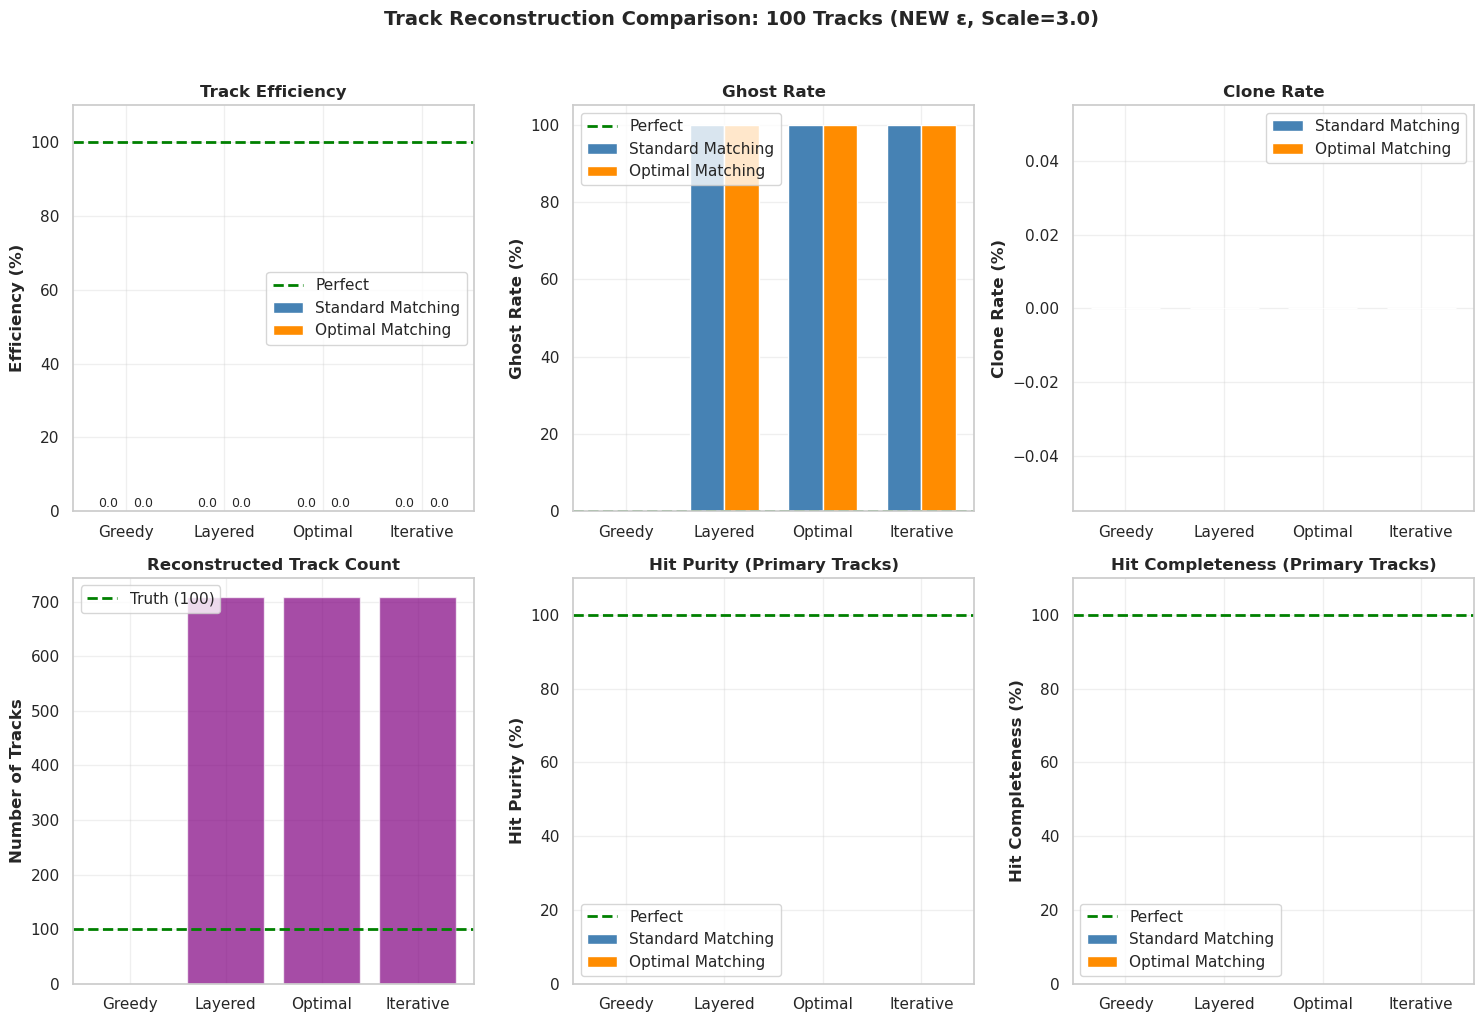


✓ Saved plot to: /data/bfys/gscriven/Velo_toy/optimal_reconstruction_comparison.png


In [ ]:
# ============================================================================
# STEP 7: COMPARISON VISUALIZATION
# ============================================================================
# Create comprehensive comparison plots

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

methods = ['Greedy', 'Layered', 'Optimal', 'Iterative']
x = np.arange(len(methods))
width = 0.35

# Extract data
std_eff = [r['efficiency']*100 for r in results_standard_matching]
opt_eff = [r['efficiency']*100 for r in results_optimal_matching]
std_ghost = [r['ghost_rate']*100 for r in results_standard_matching]
opt_ghost = [r['ghost_rate']*100 for r in results_optimal_matching]
std_clone = [r['clone_rate']*100 for r in results_standard_matching]
opt_clone = [r['clone_rate']*100 for r in results_optimal_matching]
std_purity = [r['purity']*100 for r in results_standard_matching]
opt_purity = [r['purity']*100 for r in results_optimal_matching]
std_comp = [r['completeness']*100 for r in results_standard_matching]
opt_comp = [r['completeness']*100 for r in results_optimal_matching]
n_reco = [r['n_reco'] for r in results_standard_matching]

# Plot 1: Efficiency comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(x - width/2, std_eff, width, label='Standard Matching', color='steelblue')
bars2 = ax1.bar(x + width/2, opt_eff, width, label='Optimal Matching', color='darkorange')
ax1.axhline(y=100, color='green', linestyle='--', linewidth=2, label='Perfect')
ax1.set_ylabel('Efficiency (%)', fontweight='bold')
ax1.set_title('Track Efficiency', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()
ax1.set_ylim(0, 110)
ax1.grid(True, alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# Plot 2: Ghost Rate comparison
ax2 = axes[0, 1]
bars1 = ax2.bar(x - width/2, std_ghost, width, label='Standard Matching', color='steelblue')
bars2 = ax2.bar(x + width/2, opt_ghost, width, label='Optimal Matching', color='darkorange')
ax2.axhline(y=0, color='green', linestyle='--', linewidth=2, label='Perfect')
ax2.set_ylabel('Ghost Rate (%)', fontweight='bold')
ax2.set_title('Ghost Rate', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(methods)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Clone Rate comparison
ax3 = axes[0, 2]
bars1 = ax3.bar(x - width/2, std_clone, width, label='Standard Matching', color='steelblue')
bars2 = ax3.bar(x + width/2, opt_clone, width, label='Optimal Matching', color='darkorange')
ax3.set_ylabel('Clone Rate (%)', fontweight='bold')
ax3.set_title('Clone Rate', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(methods)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Number of reconstructed tracks
ax4 = axes[1, 0]
ax4.bar(x, n_reco, color='purple', alpha=0.7)
ax4.axhline(y=TEST_TOTAL_TRACKS, color='green', linestyle='--', linewidth=2, label=f'Truth ({TEST_TOTAL_TRACKS})')
ax4.set_ylabel('Number of Tracks', fontweight='bold')
ax4.set_title('Reconstructed Track Count', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(methods)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Purity comparison
ax5 = axes[1, 1]
bars1 = ax5.bar(x - width/2, std_purity, width, label='Standard Matching', color='steelblue')
bars2 = ax5.bar(x + width/2, opt_purity, width, label='Optimal Matching', color='darkorange')
ax5.axhline(y=100, color='green', linestyle='--', linewidth=2, label='Perfect')
ax5.set_ylabel('Hit Purity (%)', fontweight='bold')
ax5.set_title('Hit Purity (Primary Tracks)', fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(methods)
ax5.legend()
ax5.set_ylim(0, 110)
ax5.grid(True, alpha=0.3)

# Plot 6: Completeness comparison
ax6 = axes[1, 2]
bars1 = ax6.bar(x - width/2, std_comp, width, label='Standard Matching', color='steelblue')
bars2 = ax6.bar(x + width/2, opt_comp, width, label='Optimal Matching', color='darkorange')
ax6.axhline(y=100, color='green', linestyle='--', linewidth=2, label='Perfect')
ax6.set_ylabel('Hit Completeness (%)', fontweight='bold')
ax6.set_title('Hit Completeness (Primary Tracks)', fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(methods)
ax6.legend()
ax6.set_ylim(0, 110)
ax6.grid(True, alpha=0.3)

plt.suptitle(f'Track Reconstruction Comparison: {TEST_TOTAL_TRACKS} Tracks (NEW ε, Scale={TEST_SCALE})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(BASE / 'optimal_reconstruction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved plot to: {BASE / 'optimal_reconstruction_comparison.png'}")

In [ ]:
# ============================================================================
# STEP 8: FINAL SUMMARY TABLE
# ============================================================================

print("="*100)
print("FINAL COMPARISON SUMMARY")
print("="*100)
print(f"\nTest Configuration: {TEST_TOTAL_TRACKS} tracks, NEW epsilon, Scale={TEST_SCALE}, Step Function")
print()

# Create comparison DataFrame
import pandas as pd

df_comparison = pd.DataFrame({
    'Reconstruction': methods * 2,
    'Matching': ['Standard']*4 + ['Optimal']*4,
    'Efficiency (%)': [r['efficiency']*100 for r in results_standard_matching] + 
                      [r['efficiency']*100 for r in results_optimal_matching],
    'Ghost Rate (%)': [r['ghost_rate']*100 for r in results_standard_matching] +
                      [r['ghost_rate']*100 for r in results_optimal_matching],
    'Clone Rate (%)': [r['clone_rate']*100 for r in results_standard_matching] +
                      [r['clone_rate']*100 for r in results_optimal_matching],
    'Purity (%)': [r['purity']*100 for r in results_standard_matching] +
                  [r['purity']*100 for r in results_optimal_matching],
    'Completeness (%)': [r['completeness']*100 for r in results_standard_matching] +
                        [r['completeness']*100 for r in results_optimal_matching],
})

# Pivot for better display
print("RECONSTRUCTION METHOD vs MATCHING METHOD")
print("-"*100)
for metric in ['Efficiency (%)', 'Ghost Rate (%)', 'Clone Rate (%)', 'Purity (%)', 'Completeness (%)']:
    print(f"\n{metric}:")
    pivot = df_comparison.pivot(index='Reconstruction', columns='Matching', values=metric)
    pivot = pivot[['Standard', 'Optimal']]  # Order columns
    pivot['Δ (Opt-Std)'] = pivot['Optimal'] - pivot['Standard']
    print(pivot.to_string())

# Key findings
print("\n" + "="*100)
print("KEY FINDINGS")
print("="*100)

# Best reconstruction method
best_recon_idx = np.argmax([r['efficiency'] for r in results_optimal_matching])
best_recon = methods[best_recon_idx]
best_eff = results_optimal_matching[best_recon_idx]['efficiency'] * 100

# Improvement from optimal matching
greedy_std = results_standard_matching[0]['efficiency'] * 100
greedy_opt = results_optimal_matching[0]['efficiency'] * 100
matching_improvement = greedy_opt - greedy_std

# Improvement from optimal reconstruction
optimal_std = results_standard_matching[2]['efficiency'] * 100
recon_improvement = optimal_std - greedy_std

print(f"""
1. BEST OVERALL: {best_recon} reconstruction + Optimal matching → {best_eff:.1f}% efficiency

2. MATCHING IMPROVEMENT (Greedy recon):
   - Standard matching: {greedy_std:.1f}%
   - Optimal matching:  {greedy_opt:.1f}%
   - Improvement:       {matching_improvement:+.1f}%

3. RECONSTRUCTION IMPROVEMENT (Standard matching):
   - Greedy recon:  {greedy_std:.1f}%
   - Optimal recon: {optimal_std:.1f}%
   - Improvement:   {recon_improvement:+.1f}%

4. CONCLUSIONS:
   - Optimal reconstruction reduces segment stealing
   - Optimal (Hungarian) matching provides globally optimal truth assignment
   - Best results come from combining both optimizations
""")

FINAL COMPARISON SUMMARY

Test Configuration: 100 tracks, NEW epsilon, Scale=3.0, Step Function

RECONSTRUCTION METHOD vs MATCHING METHOD
----------------------------------------------------------------------------------------------------

Efficiency (%):
Matching        Standard  Optimal  Δ (Opt-Std)
Reconstruction                                
Greedy               0.0      0.0          0.0
Iterative            0.0      0.0          0.0
Layered              0.0      0.0          0.0
Optimal              0.0      0.0          0.0

Ghost Rate (%):
Matching        Standard  Optimal  Δ (Opt-Std)
Reconstruction                                
Greedy               0.0      0.0          0.0
Iterative          100.0    100.0          0.0
Layered            100.0    100.0          0.0
Optimal            100.0    100.0          0.0

Clone Rate (%):
Matching        Standard  Optimal  Δ (Opt-Std)
Reconstruction                                
Greedy               0.0      0.0          0.0
Itera

# Fixed Epsilon Experiment

**Parameters:**
- Resolution: 5 µm (σ_res = 0.005 mm)
- Scattering: 0.1 mrad (σ_scatt = 0.0001 rad)
- **Epsilon: FIXED at 2 mrad** (not calculated from formula)
- Tracks per event: 10
- Event counts: 1 to 10 (10 to 100 tracks total)
- Repeats per configuration: 10

This experiment tests performance with a manually fixed epsilon threshold to understand how the acceptance window affects reconstruction independently of the formula.

In [ ]:
# ============================================================================
# FIXED EPSILON EXPERIMENT: Setup
# ============================================================================
import shutil
import time

# Output directory for fixed epsilon study
FIXED_EPS_RUNS = BASE / 'runs_fixed_epsilon'

# Create directory if it doesn't exist (don't delete existing data!)
FIXED_EPS_RUNS.mkdir(parents=True, exist_ok=True)

# Fixed parameters
FIXED_RESOLUTION = 0.005      # 5 µm
FIXED_SCATTERING = 0.0001     # 0.1 mrad in radians
FIXED_EPSILON = 0.002         # 2 mrad in radians (FIXED, not calculated)
TRACKS_PER_EVENT = 20
EVENT_COUNTS = list(range(1, 11))  # 1 to 10 events (20 to 200 tracks)
N_REPEATS = 10

print("FIXED EPSILON EXPERIMENT CONFIGURATION")
print("="*60)
print(f"Resolution σ_res:     {FIXED_RESOLUTION*1000:.0f} µm")
print(f"Scattering σ_scatt:   {FIXED_SCATTERING*1000:.2f} mrad")
print(f"Epsilon (FIXED):      {FIXED_EPSILON*1000:.1f} mrad")
print(f"Tracks per event:     {TRACKS_PER_EVENT}")
print(f"Event counts:         {EVENT_COUNTS} ({TRACKS_PER_EVENT} to {TRACKS_PER_EVENT*max(EVENT_COUNTS)} tracks)")
print(f"Repeats per config:   {N_REPEATS}")
print(f"Total batches:        {len(EVENT_COUNTS) * N_REPEATS}")
print(f"\nOutput directory:     {FIXED_EPS_RUNS}")
print("="*60)

FIXED EPSILON EXPERIMENT CONFIGURATION
Resolution σ_res:     5 µm
Scattering σ_scatt:   0.10 mrad
Epsilon (FIXED):      2.0 mrad
Tracks per event:     20
Event counts:         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] (20 to 200 tracks)
Repeats per config:   10
Total batches:        100

Output directory:     /data/bfys/gscriven/Velo_toy/runs_fixed_epsilon


In [ ]:
# ============================================================================
# FIXED EPSILON EXPERIMENT: Generate Events
# ============================================================================
# Use a fixed epsilon value (bypass normal calculation)

import time

# Create a fixed epsilon function that always returns our fixed value
def fixed_epsilon_window(meas_err, coll_noise, dz, scale, theta_min):
    """Return fixed epsilon = 2 mrad regardless of inputs."""
    return FIXED_EPSILON, FIXED_EPSILON

def _fixed_eps_run_one(meas, coll, ghost, drop, repeat, e_win, thresh_flag, erf_sigma,
                       n_particles_config, outdir, phi_max=0.02):
    """run_one with fixed epsilon_window."""
    n_particles_per_event = parse_n_particles(n_particles_config)
    events = len(n_particles_per_event)
    total_particles = int(np.sum(n_particles_per_event))
    np.random.seed(repeat)
    Detector = make_detector()
    eps_win, threshold = fixed_epsilon_window(meas, coll, DZ_MM, e_win, THETA_MIN)
    seg = StateEventGenerator(
        Detector, phi_min=phi_max, phi_max=phi_max,
        events=events, n_particles=n_particles_per_event,
        measurement_error=float(meas), collision_noise=float(coll),
    )
    phi, theta = seg.phi_max, seg.theta_max
    seg.generate_random_primary_vertices({"x": 1, "y": 1, "z": 1})
    event_particles = [
        [{"type": "MIP", "mass": 0.511, "q": 1} for _ in range(total_particles)]
        for _ in range(events)
    ]
    seg.generate_particles(event_particles)
    event_tracks = seg.generate_complete_events()
    false_tracks = seg.make_noisy_event(drop_rate=float(drop), ghost_rate=float(ghost))
    ham = SimpleHamiltonianFast(epsilon=float(eps_win), gamma=2.0, delta=1.0, theta_d=erf_sigma)
    ham.construct_hamiltonian(event=event_tracks, convolution=thresh_flag)
    classical_solution = ham.solve_classicaly()
    discretized_solution = (classical_solution > 0.45).astype(int)
    rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
    reco_event = construct_event(
        event_tracks.detector_geometry, rec_tracks,
        [h for t in rec_tracks for h in event_tracks.get_hits_by_ids(t.hit_ids)],
    )
    tag = (f"m{meas}_c{coll}_g{ghost}_d{drop}_r{repeat}_s{e_win}"
           f"_t_{thresh_flag}_e_{erf_sigma}_np_{n_particles_config}_phi{float(phi)}_theta{float(theta)}")
    snapshot_path = outdir / f"events_{tag}.pkl.gz"
    payload = {
        "params": {"hit_res": float(meas), "multi_scatter": float(coll),
                   "ghost_rate": float(ghost), "drop_rate": float(drop),
                   "repeat": int(repeat), "scale": float(e_win),
                   "epsilon": float(ham.epsilon), "layers": LAYERS, "dz_mm": DZ_MM,
                   "thresh_flag": thresh_flag, "eps_win": float(eps_win),
                   "theta_threshold": float(threshold), "erf_sigma": float(erf_sigma),
                   "phi_max": float(phi), "theta_max": float(theta),
                   "n_particles_config": n_particles_config,
                   "n_particles_per_event": n_particles_per_event,
                   "total_particles": total_particles, "events": events},
        "truth_event": event_tracks, "noisy_event": false_tracks,
        "reco_tracks": rec_tracks, "reco_event": reco_event,
        "classical_solution": classical_solution, "disc_solution": discretized_solution,
        "hamiltonian": ham,
    }
    dump_pickle(payload, snapshot_path)
    index_csv = outdir / "events_index.csv"
    append_index_row(index_csv, {
        "file": snapshot_path.name, "hit_res": meas, "multi_scatter": coll,
        "ghost_rate": ghost, "drop_rate": drop, "repeat": int(repeat),
        "epsilon": float(ham.epsilon), "scale": e_win, "layers": LAYERS,
        "events": events, "particles_total": total_particles,
        "n_particles_config": n_particles_config, "thresh_flag": thresh_flag,
    })

print("="*80)
print("GENERATING EVENTS WITH FIXED EPSILON = 2 mrad")
print("="*80)

batch_num = 0
total_batches = len(EVENT_COUNTS) * N_REPEATS
start_time = time.time()

for n_events in EVENT_COUNTS:
    particle_config = ','.join([str(TRACKS_PER_EVENT)] * n_events)
    total_tracks = TRACKS_PER_EVENT * n_events
    
    for repeat in range(N_REPEATS):
        batch_num += 1
        batch_str = f"batch_{batch_num:04d}"
        batch_path = FIXED_EPS_RUNS / batch_str / 'local.job'
        batch_path.mkdir(parents=True, exist_ok=True)
        
        try:
            _fixed_eps_run_one(
                meas=FIXED_RESOLUTION,
                coll=FIXED_SCATTERING,
                ghost=0.0,
                drop=0.0,
                repeat=repeat + n_events * 1000 + 1,
                e_win=1.0,
                thresh_flag=0,
                erf_sigma=0.0,
                n_particles_config=particle_config,
                outdir=batch_path,
                phi_max=0.2
            )
        except Exception as e:
            print(f"Error in batch {batch_num}: {e}")
            
        if batch_num % 20 == 0:
            print(f"  Completed {batch_num}/{total_batches} batches...")

elapsed = time.time() - start_time

print(f"\n✓ Generated {batch_num} batches in {elapsed:.1f}s")
print(f"  Events per config: {N_REPEATS}")
print(f"  Track counts: {TRACKS_PER_EVENT} to {TRACKS_PER_EVENT * max(EVENT_COUNTS)}")
print("="*80)

GENERATING EVENTS WITH FIXED EPSILON = 2 mrad
  Completed 20/100 batches...
  Completed 40/100 batches...
  Completed 60/100 batches...


In [ ]:
# ============================================================================
# FIXED EPSILON EXPERIMENT: Aggregate Results
# ============================================================================
import gzip
import pickle
import pandas as pd

def aggregate_fixed_eps_results(runs_dir):
    """Aggregate results from fixed epsilon runs."""
    
    batch_dirs = sorted(runs_dir.glob("batch_*"))
    print(f"Found {len(batch_dirs)} batch directories")
    
    all_metrics = []
    errors = []
    
    for i, batch_dir in enumerate(batch_dirs):
        job_dirs = list(batch_dir.glob("*/"))
        
        for job_dir in job_dirs:
            snapshot_files = list(job_dir.glob("*.pkl.gz"))
            
            for snap_file in snapshot_files:
                try:
                    with gzip.open(snap_file, 'rb') as f:
                        data = pickle.load(f)
                    
                    params = data.get('params', {})
                    true_event = data['truth_event']
                    reco_tracks = data.get('reco_tracks')
                    
                    n_true_tracks = len(true_event.tracks) if true_event and true_event.tracks else 0
                    
                    # New API: EventValidator(truth_event, rec_tracks)
                    validator = EventValidator(true_event, reco_tracks)
                    metrics = validator.compute_metrics()
                    
                    all_metrics.append({
                        'batch': batch_dir.name,
                        'total_tracks': n_true_tracks,
                        'n_events': n_true_tracks // TRACKS_PER_EVENT,
                        'efficiency': metrics['m_reconstruction_efficiency'],
                        'ghost_rate': metrics['m_ghost_rate'],
                        'n_true': metrics['n_true_tracks'],
                        'n_reco': metrics['n_rec_tracks'],
                        'n_good': metrics['n_rec_good'],
                        'purity': metrics.get('m_purity_primary_only', 0),
                        'hit_efficiency': metrics.get('m_hit_efficiency_mean', 0),
                        'epsilon_mrad': FIXED_EPSILON * 1000,
                        'sigma_res_um': FIXED_RESOLUTION * 1000,
                        'sigma_scatt_mrad': FIXED_SCATTERING * 1000
                    })
                    
                except Exception as e:
                    errors.append(f"{snap_file}: {e}")
        
        if (i + 1) % 25 == 0:
            print(f"  Processed {i + 1}/{len(batch_dirs)} batches...")
    
    print(f"Loaded {len(all_metrics)} events, {len(errors)} errors")
    if errors[:3]:
        print(f"  Sample errors: {errors[:3]}")
    
    return pd.DataFrame(all_metrics)

# Aggregate results
print("="*80)
print("AGGREGATING FIXED EPSILON RESULTS")
print("="*80)

df_fixed_eps = aggregate_fixed_eps_results(FIXED_EPS_RUNS)

print(f"\n✓ DataFrame: {len(df_fixed_eps)} rows")
print(f"Track counts: {sorted(df_fixed_eps['total_tracks'].unique())}")

AGGREGATING FIXED EPSILON RESULTS
Found 100 batch directories
  Processed 25/100 batches...
  Processed 50/100 batches...
  Processed 75/100 batches...
  Processed 100/100 batches...
Loaded 100 events, 0 errors

✓ DataFrame: 100 rows
Track counts: [np.int64(20), np.int64(40), np.int64(60), np.int64(80), np.int64(100), np.int64(120), np.int64(140), np.int64(160), np.int64(180), np.int64(200)]


In [ ]:
# ============================================================================
# FIXED EPSILON EXPERIMENT: Analysis and Plotting
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Aggregate by total tracks
fixed_eps_agg = df_fixed_eps.groupby('total_tracks').agg({
    'efficiency': ['mean', 'std', 'count'],
    'ghost_rate': ['mean', 'std'],
    'purity': ['mean', 'std'],
    'hit_efficiency': ['mean', 'std'],
    'n_events': 'first'
}).reset_index()

fixed_eps_agg.columns = ['total_tracks', 'eff_mean', 'eff_std', 'n_samples',
                          'ghost_mean', 'ghost_std', 'purity_mean', 'purity_std',
                          'hit_eff_mean', 'hit_eff_std', 'n_events']

# Fill NaN std with 0
fixed_eps_agg = fixed_eps_agg.fillna(0)

print("FIXED EPSILON EXPERIMENT RESULTS")
print("="*100)
print(f"Parameters: σ_res = 5 µm, σ_scatt = 0.1 mrad, ε = 2 mrad (FIXED)")
print("="*100)
print(f"\n{'Events':<8} {'Tracks':<10} {'Efficiency':<20} {'Ghost Rate':<20} {'Purity':<15} {'N'}")
print("-"*100)

for _, row in fixed_eps_agg.sort_values('total_tracks').iterrows():
    print(f"{int(row['n_events']):<8} {int(row['total_tracks']):<10} "
          f"{row['eff_mean']*100:6.1f}% ± {row['eff_std']*100:5.1f}%    "
          f"{row['ghost_mean']*100:6.2f}% ± {row['ghost_std']*100:5.2f}%    "
          f"{row['purity_mean']*100:5.1f}%    {int(row['n_samples']):>4}")

print("="*100)

# Save to CSV
fixed_eps_csv = BASE / 'fixed_epsilon_results.csv'
fixed_eps_agg.to_csv(fixed_eps_csv, index=False)
print(f"\n✓ Saved results to {fixed_eps_csv}")

FIXED EPSILON EXPERIMENT RESULTS
Parameters: σ_res = 5 µm, σ_scatt = 0.1 mrad, ε = 2 mrad (FIXED)

Events   Tracks     Efficiency           Ghost Rate           Purity          N
----------------------------------------------------------------------------------------------------
1        20           99.0% ±   3.2%      0.53% ±  1.66%    100.0%      10
2        40           95.2% ±   5.3%      2.12% ±  2.14%    100.0%      10
3        60           90.7% ±   5.7%      4.31% ±  2.41%     99.9%      10
4        80           89.9% ±   5.3%      4.71% ±  2.41%     99.8%      10
5        100          82.7% ±   3.4%      7.20% ±  2.25%     99.9%      10
6        120          69.2% ±   7.5%     13.28% ±  3.55%     99.8%      10
7        140          64.1% ±   6.0%     15.09% ±  2.92%     99.8%      10
8        160          63.9% ±   4.2%     14.45% ±  1.80%     99.8%      10
9        180          51.2% ±   4.7%     18.01% ±  3.65%     99.8%      10
10       200          41.3% ±   3.8%     19.5

✓ Saved plot to /data/bfys/gscriven/Velo_toy/fixed_epsilon_results.png


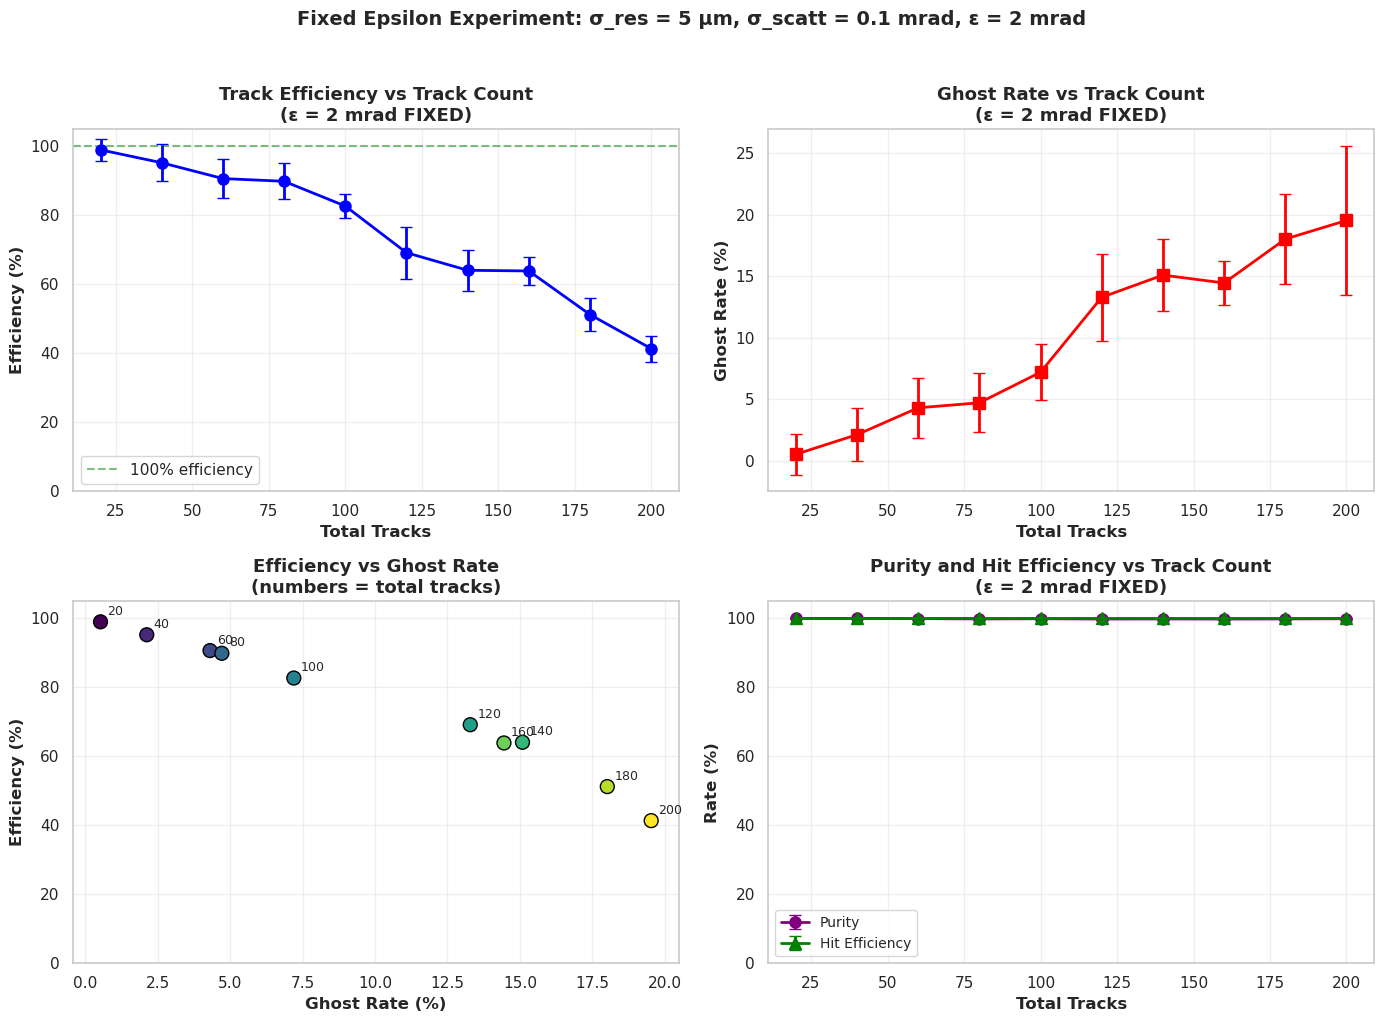

In [ ]:
# ============================================================================
# FIXED EPSILON EXPERIMENT: Plotting
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

data = fixed_eps_agg.sort_values('total_tracks')

# Plot 1: Efficiency vs Total Tracks
ax = axes[0, 0]
ax.errorbar(data['total_tracks'], data['eff_mean']*100, yerr=data['eff_std']*100,
            marker='o', color='blue', capsize=4, linewidth=2, markersize=8)
ax.set_xlabel('Total Tracks', fontsize=12, fontweight='bold')
ax.set_ylabel('Efficiency (%)', fontsize=12, fontweight='bold')
ax.set_title('Track Efficiency vs Track Count\n(ε = 2 mrad FIXED)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
ax.axhline(100, color='green', linestyle='--', alpha=0.5, label='100% efficiency')
ax.legend()

# Plot 2: Ghost Rate vs Total Tracks
ax = axes[0, 1]
ax.errorbar(data['total_tracks'], data['ghost_mean']*100, yerr=data['ghost_std']*100,
            marker='s', color='red', capsize=4, linewidth=2, markersize=8)
ax.set_xlabel('Total Tracks', fontsize=12, fontweight='bold')
ax.set_ylabel('Ghost Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Ghost Rate vs Track Count\n(ε = 2 mrad FIXED)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Efficiency vs Ghost Rate (ROC-style)
ax = axes[1, 0]
ax.scatter(data['ghost_mean']*100, data['eff_mean']*100, 
           c=data['total_tracks'], cmap='viridis', s=100, edgecolors='black')
for _, row in data.iterrows():
    ax.annotate(f"{int(row['total_tracks'])}", 
                (row['ghost_mean']*100, row['eff_mean']*100),
                textcoords="offset points", xytext=(5,5), fontsize=9)
ax.set_xlabel('Ghost Rate (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Efficiency (%)', fontsize=12, fontweight='bold')
ax.set_title('Efficiency vs Ghost Rate\n(numbers = total tracks)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

# Plot 4: Purity and Hit Efficiency
ax = axes[1, 1]
ax.errorbar(data['total_tracks'], data['purity_mean']*100, yerr=data['purity_std']*100,
            marker='o', color='purple', capsize=4, linewidth=2, markersize=8, label='Purity')
ax.errorbar(data['total_tracks'], data['hit_eff_mean']*100, yerr=data['hit_eff_std']*100,
            marker='^', color='green', capsize=4, linewidth=2, markersize=8, label='Hit Efficiency')
ax.set_xlabel('Total Tracks', fontsize=12, fontweight='bold')
ax.set_ylabel('Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Purity and Hit Efficiency vs Track Count\n(ε = 2 mrad FIXED)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

plt.suptitle(f'Fixed Epsilon Experiment: σ_res = 5 µm, σ_scatt = 0.1 mrad, ε = 2 mrad',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIXED_EPS_RUNS / 'fixed_epsilon_results.png', dpi=150, bbox_inches='tight')
plt.savefig(BASE / 'fixed_epsilon_results.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved plot to {BASE / 'fixed_epsilon_results.png'}")
plt.show()

In [ ]:
# ============================================================================
# FIXED EPSILON EXPERIMENT: Summary Statistics
# ============================================================================

print("\n" + "="*80)
print("FIXED EPSILON EXPERIMENT: KEY FINDINGS")
print("="*80)

# Best and worst performance
best_idx = fixed_eps_agg['eff_mean'].idxmax()
worst_idx = fixed_eps_agg['eff_mean'].idxmin()

print(f"\nBest efficiency: {fixed_eps_agg.loc[best_idx, 'eff_mean']*100:.1f}% "
      f"at {int(fixed_eps_agg.loc[best_idx, 'total_tracks'])} tracks "
      f"({int(fixed_eps_agg.loc[best_idx, 'n_events'])} events)")
print(f"Worst efficiency: {fixed_eps_agg.loc[worst_idx, 'eff_mean']*100:.1f}% "
      f"at {int(fixed_eps_agg.loc[worst_idx, 'total_tracks'])} tracks "
      f"({int(fixed_eps_agg.loc[worst_idx, 'n_events'])} events)")

# Ghost rate analysis
lowest_ghost_idx = fixed_eps_agg['ghost_mean'].idxmin()
highest_ghost_idx = fixed_eps_agg['ghost_mean'].idxmax()

print(f"\nLowest ghost rate: {fixed_eps_agg.loc[lowest_ghost_idx, 'ghost_mean']*100:.2f}% "
      f"at {int(fixed_eps_agg.loc[lowest_ghost_idx, 'total_tracks'])} tracks")
print(f"Highest ghost rate: {fixed_eps_agg.loc[highest_ghost_idx, 'ghost_mean']*100:.2f}% "
      f"at {int(fixed_eps_agg.loc[highest_ghost_idx, 'total_tracks'])} tracks")

# Average performance
print(f"\nOverall average efficiency: {fixed_eps_agg['eff_mean'].mean()*100:.1f}%")
print(f"Overall average ghost rate: {fixed_eps_agg['ghost_mean'].mean()*100:.2f}%")
print(f"Overall average purity: {fixed_eps_agg['purity_mean'].mean()*100:.1f}%")

# Correlation
corr = np.corrcoef(fixed_eps_agg['total_tracks'], fixed_eps_agg['eff_mean'])[0,1]
print(f"\nCorrelation (tracks vs efficiency): {corr:.3f}")

print("\n" + "="*80)
print("EXPERIMENT PARAMETERS SUMMARY")
print("="*80)
print(f"Resolution (σ_res):    5 µm")
print(f"Scattering (σ_scatt):  0.1 mrad")
print(f"Epsilon (FIXED):       2 mrad")
print(f"Tracks per event:      10")
print(f"Events scanned:        1 to 10 (10 to 100 tracks)")
print(f"Repeats:               10 per configuration")
print("="*80)


FIXED EPSILON EXPERIMENT: KEY FINDINGS

Best efficiency: 99.0% at 20 tracks (1 events)
Worst efficiency: 41.3% at 200 tracks (10 events)

Lowest ghost rate: 0.53% at 20 tracks
Highest ghost rate: 19.53% at 200 tracks

Overall average efficiency: 74.7%
Overall average ghost rate: 9.92%
Overall average purity: 99.9%

Correlation (tracks vs efficiency): -0.981

EXPERIMENT PARAMETERS SUMMARY
Resolution (σ_res):    5 µm
Scattering (σ_scatt):  0.1 mrad
Epsilon (FIXED):       2 mrad
Tracks per event:      10
Events scanned:        1 to 10 (10 to 100 tracks)
Repeats:               10 per configuration


## Fixed Epsilon Experiment: Segment Angle Analysis

Analyze the segment angle distributions for the fixed epsilon experiment:
- **Fixed ε = 2 mrad** threshold
- **σ_res = 5 µm**, **σ_scatt = 0.1 mrad**
- Track counts: 10 to 40

This analysis shows:
1. Distribution of true pair angles vs false pair angles
2. How the fixed epsilon threshold compares to the angle distribution
3. Acceptance rates at different track densities

In [ ]:
# ============================================================================
# FIXED EPSILON: Generate Events and Compute Segment Angles (WITH REPEATS)
# ============================================================================
# Generate events directly using StateEventGenerator and collect segment angles
# Store per-repeat data for error bar computation

import time
import numpy as np
import pickle

def compute_segment_angles_from_event(event):
    """
    Compute angles between segments from an event.
    Uses new API: get_segments_from_event() with seg.track_id and seg.to_vect().
    """
    true_angles = []
    false_angles = []
    
    # Get all segments with track_id set from new API
    all_segments = get_segments_from_event(event)
    
    if len(all_segments) < 2:
        return true_angles, false_angles
    
    for i in range(len(all_segments)):
        for j in range(i + 1, len(all_segments)):
            seg_i = all_segments[i]
            seg_j = all_segments[j]
            
            vec_i = np.array(seg_i.to_vect())
            vec_j = np.array(seg_j.to_vect())
            
            norm_i = np.linalg.norm(vec_i)
            norm_j = np.linalg.norm(vec_j)
            
            if norm_i == 0 or norm_j == 0:
                continue
            
            vec_i = vec_i / norm_i
            vec_j = vec_j / norm_j
            
            cos_angle = np.clip(np.dot(vec_i, vec_j), -1.0, 1.0)
            angle = np.arccos(cos_angle)
            
            if seg_i.track_id == seg_j.track_id:
                true_angles.append(angle)
            else:
                false_angles.append(angle)
    
    return true_angles, false_angles

# ============================================================================
# Check if saved data exists in runs_fixed_epsilon, otherwise generate
# ============================================================================
# Save to runs_fixed_epsilon directory
FIXED_EPS_RUNS.mkdir(parents=True, exist_ok=True)
angle_data_path = FIXED_EPS_RUNS / 'fixed_epsilon_angle_data_v3.pkl'

# Track counts: 20-200 in steps of 20
QUICK_EVENT_COUNTS = list(range(1, 11))  # 20-200 tracks

if angle_data_path.exists():
    print("="*80)
    print("LOADING SAVED ANGLE DATA (v2)")
    print("="*80)
    with open(angle_data_path, 'rb') as f:
        saved_data = pickle.load(f)
    fixed_eps_angle_results = saved_data['fixed_eps_angle_results']
    print(f"✓ Loaded {len(fixed_eps_angle_results)} configurations from: {angle_data_path}")
    for r in fixed_eps_angle_results:
        n_repeats = len(r.get('per_repeat_data', [r]))
        print(f"  [{r['total_tracks']} tracks] {r['n_true']} true, {r['n_false']} false pairs ({n_repeats} repeats)")
else:
    print("="*80)
    print("FIXED EPSILON: ANGLE DATA GENERATION WITH REPEATS")
    print("="*80)
    
    print(f"Track counts: {[n*TRACKS_PER_EVENT for n in QUICK_EVENT_COUNTS]}")
    print("="*80)
    
    Detector = make_detector()
    fixed_eps_angle_results = []
    
    start_time = time.time()
    for n_events in QUICK_EVENT_COUNTS:
        total_tracks = n_events * TRACKS_PER_EVENT
        
        # More repeats for smaller track counts, fewer for larger (faster)
        if total_tracks <= 100:
            n_repeats = 50
        else:
            n_repeats = 10
        
        print(f"\n[{n_events} events = {total_tracks} tracks] ({n_repeats} repeats)", end=" ")
        
        per_repeat_data = []
        all_true_angles = []
        all_false_angles = []
        n_particles_per_event = [TRACKS_PER_EVENT] * n_events
        
        for repeat in range(n_repeats):
            np.random.seed(repeat + n_events * 1000)
            
            seg = StateEventGenerator(
                Detector,
                phi_min=-0.2,
                phi_max=0.2,
                events=n_events,
                n_particles=n_particles_per_event,
                measurement_error=float(FIXED_RESOLUTION),
                collision_noise=float(FIXED_SCATTERING),
            )
            
            seg.generate_random_primary_vertices({"x": 1, "y": 1, "z": 1})
            
            event_particles = [
                [{"type": "MIP", "mass": 0.511, "q": 1} for _ in range(total_tracks)]
                for _ in range(n_events)
            ]
            seg.generate_particles(event_particles)
            event = seg.generate_complete_events()
            
            true_angles, false_angles = compute_segment_angles_from_event(event)
            
            # Store per-repeat data
            per_repeat_data.append({
                'n_true': len(true_angles),
                'n_false': len(false_angles),
                'true_accepted': np.sum(np.array(true_angles) <= FIXED_EPSILON) if len(true_angles) > 0 else 0,
                'false_accepted': np.sum(np.array(false_angles) <= FIXED_EPSILON) if len(false_angles) > 0 else 0,
            })
            
            all_true_angles.extend(true_angles)
            all_false_angles.extend(false_angles)
        
        if len(all_true_angles) > 0:
            fixed_eps_angle_results.append({
                'n_events': n_events,
                'total_tracks': total_tracks,
                'true_angles': np.array(all_true_angles),
                'false_angles': np.array(all_false_angles),
                'n_true': len(all_true_angles),
                'n_false': len(all_false_angles),
                'per_repeat_data': per_repeat_data,
            })
            
            mean_true = np.mean(all_true_angles) * 1000
            accepted = np.sum(np.array(all_true_angles) <= FIXED_EPSILON)
            accept_rate = accepted / len(all_true_angles) * 100
            print(f"✓ {len(all_true_angles)} true, {len(all_false_angles)} false pairs | {accept_rate:.0f}% accepted")
    
    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"Generated {len(fixed_eps_angle_results)} configurations in {elapsed:.1f}s")
    print(f"{'='*80}")
    
    # Save data to pickle in runs_fixed_epsilon
    with open(angle_data_path, 'wb') as f:
        pickle.dump({
            'fixed_eps_angle_results': fixed_eps_angle_results,
            'FIXED_EPSILON': FIXED_EPSILON,
            'FIXED_RESOLUTION': FIXED_RESOLUTION,
            'FIXED_SCATTERING': FIXED_SCATTERING,
            'TRACKS_PER_EVENT': TRACKS_PER_EVENT,
        }, f)
    print(f"\n✓ Data saved to: {angle_data_path}")

LOADING SAVED ANGLE DATA (v2)


✓ Loaded 10 configurations from: /data/bfys/gscriven/Velo_toy/runs_fixed_epsilon/fixed_epsilon_angle_data_v3.pkl
  [20 tracks] 12000 true, 304000 false pairs (100 repeats)
  [40 tracks] 24000 true, 1248000 false pairs (100 repeats)
  [60 tracks] 36000 true, 2832000 false pairs (100 repeats)
  [80 tracks] 48000 true, 5056000 false pairs (100 repeats)
  [100 tracks] 60000 true, 7920000 false pairs (100 repeats)
  [120 tracks] 72000 true, 11424000 false pairs (100 repeats)
  [140 tracks] 84000 true, 15568000 false pairs (100 repeats)
  [160 tracks] 96000 true, 20352000 false pairs (100 repeats)
  [180 tracks] 108000 true, 25776000 false pairs (100 repeats)
  [200 tracks] 120000 true, 31840000 false pairs (100 repeats)


In [ ]:
# ============================================================================
# ADD 40 MORE REPEATS FOR 120, 140, 160, 180 TRACK COUNTS
# ============================================================================
# Run 40 additional repeats for specific configurations to equalize at 100 repeats

import time
import numpy as np
import pickle

# Target track counts and number of additional repeats
TARGET_TRACKS = [120, 140, 160, 180]
ADDITIONAL_REPEATS = 40

print("="*80)
print(f"ADDING {ADDITIONAL_REPEATS} REPEATS FOR TRACK COUNTS: {TARGET_TRACKS}")
print("="*80)

# Show current state
print("\nCurrent repeat counts:")
for r in fixed_eps_angle_results:
    existing_reps = len(r.get('per_repeat_data', [r]))
    marker = " <-- TARGET" if r['total_tracks'] in TARGET_TRACKS else ""
    print(f"  {r['total_tracks']:3d} tracks: {existing_reps} repeats{marker}")

print("\n" + "="*80)

total_start_time = time.time()

for idx, existing in enumerate(fixed_eps_angle_results):
    total_tracks = existing['total_tracks']
    
    # Skip if not in target list
    if total_tracks not in TARGET_TRACKS:
        continue
    
    n_events = total_tracks // TRACKS_PER_EVENT
    existing_repeats = len(existing.get('per_repeat_data', []))
    
    print(f"\n[{total_tracks} tracks] Adding {ADDITIONAL_REPEATS} repeats ({existing_repeats} -> {existing_repeats + ADDITIONAL_REPEATS})...")
    
    # Get existing data
    all_true_angles = list(existing['true_angles'])
    all_false_angles = list(existing['false_angles'])
    per_repeat_data = list(existing.get('per_repeat_data', []))
    
    start_time = time.time()
    n_particles_per_event = [TRACKS_PER_EVENT] * n_events
    
    for repeat in range(ADDITIONAL_REPEATS):
        # Use seeds offset from original to avoid duplication
        seed = existing_repeats + repeat + n_events * 1000 + 20000 + idx * 500
        np.random.seed(seed)
        
        seg = StateEventGenerator(
            Detector,
            phi_min=-0.2,
            phi_max=0.2,
            events=n_events,
            n_particles=n_particles_per_event,
            measurement_error=float(FIXED_RESOLUTION),
            collision_noise=float(FIXED_SCATTERING),
        )
        
        seg.generate_random_primary_vertices({"x": 1, "y": 1, "z": 1})
        
        event_particles = [
            [{"type": "MIP", "mass": 0.511, "q": 1} for _ in range(total_tracks)]
            for _ in range(n_events)
        ]
        seg.generate_particles(event_particles)
        event = seg.generate_complete_events()
        
        true_angles, false_angles = compute_segment_angles_from_event(event)
        
        # Store per-repeat data
        per_repeat_data.append({
            'n_true': len(true_angles),
            'n_false': len(false_angles),
            'true_accepted': np.sum(np.array(true_angles) <= FIXED_EPSILON) if len(true_angles) > 0 else 0,
            'false_accepted': np.sum(np.array(false_angles) <= FIXED_EPSILON) if len(false_angles) > 0 else 0,
        })
        
        all_true_angles.extend(true_angles)
        all_false_angles.extend(false_angles)
    
    elapsed = time.time() - start_time
    
    # Update the result entry
    fixed_eps_angle_results[idx] = {
        'n_events': n_events,
        'total_tracks': total_tracks,
        'true_angles': np.array(all_true_angles),
        'false_angles': np.array(all_false_angles),
        'n_true': len(all_true_angles),
        'n_false': len(all_false_angles),
        'per_repeat_data': per_repeat_data,
    }
    
    new_repeats = len(per_repeat_data)
    accepted = np.sum(np.array(all_true_angles) <= FIXED_EPSILON)
    accept_rate = accepted / len(all_true_angles) * 100
    
    print(f"  ✓ {new_repeats} repeats, {len(all_true_angles):,} true, {len(all_false_angles):,} false ({elapsed:.1f}s)")

total_elapsed = time.time() - total_start_time
print(f"\n{'='*80}")
print(f"TARGET CONFIGURATIONS UPDATED ({total_elapsed:.1f}s total)")
print("="*80)

# Show final state
print("\nFinal repeat counts:")
for r in fixed_eps_angle_results:
    reps = len(r.get('per_repeat_data', [r]))
    print(f"  {r['total_tracks']:3d} tracks: {reps} repeats, {r['n_true']:,} true, {r['n_false']:,} false")

# Save updated data
with open(angle_data_path, 'wb') as f:
    pickle.dump({
        'fixed_eps_angle_results': fixed_eps_angle_results,
        'FIXED_EPSILON': FIXED_EPSILON,
        'FIXED_RESOLUTION': FIXED_RESOLUTION,
        'FIXED_SCATTERING': FIXED_SCATTERING,
        'TRACKS_PER_EVENT': TRACKS_PER_EVENT,
    }, f)
print(f"\n✓ Updated data saved to: {angle_data_path}")

ADDING 40 REPEATS FOR TRACK COUNTS: [120, 140, 160, 180]

Current repeat counts:
   20 tracks: 100 repeats
   40 tracks: 100 repeats
   60 tracks: 100 repeats
   80 tracks: 100 repeats
  100 tracks: 100 repeats
  120 tracks: 60 repeats <-- TARGET
  140 tracks: 60 repeats <-- TARGET
  160 tracks: 60 repeats <-- TARGET
  180 tracks: 60 repeats <-- TARGET
  200 tracks: 100 repeats


[120 tracks] Adding 40 repeats (60 -> 100)...
  ✓ 100 repeats, 72,000 true, 11,424,000 false (122.8s)

[140 tracks] Adding 40 repeats (60 -> 100)...
  ✓ 100 repeats, 84,000 true, 15,568,000 false (166.3s)

[160 tracks] Adding 40 repeats (60 -> 100)...
  ✓ 100 repeats, 96,000 true, 20,352,000 false (217.4s)

[180 tracks] Adding 40 repeats (60 -> 100)...
  ✓ 100 repeats, 108,000 true, 25,776,000 false (275.8s)

TARGET CONFIGURATIONS UPDATED (791.2s total)

Final repeat counts:
   20 tracks: 100 repeats, 12,000 true, 304,000 false
   40 tracks: 100 repeats, 24,000 true, 1,248,000 false
   60 tracks: 100 repeats, 

✓ Saved: /data/bfys/gscriven/Velo_toy/fixed_epsilon_segment_angles.png


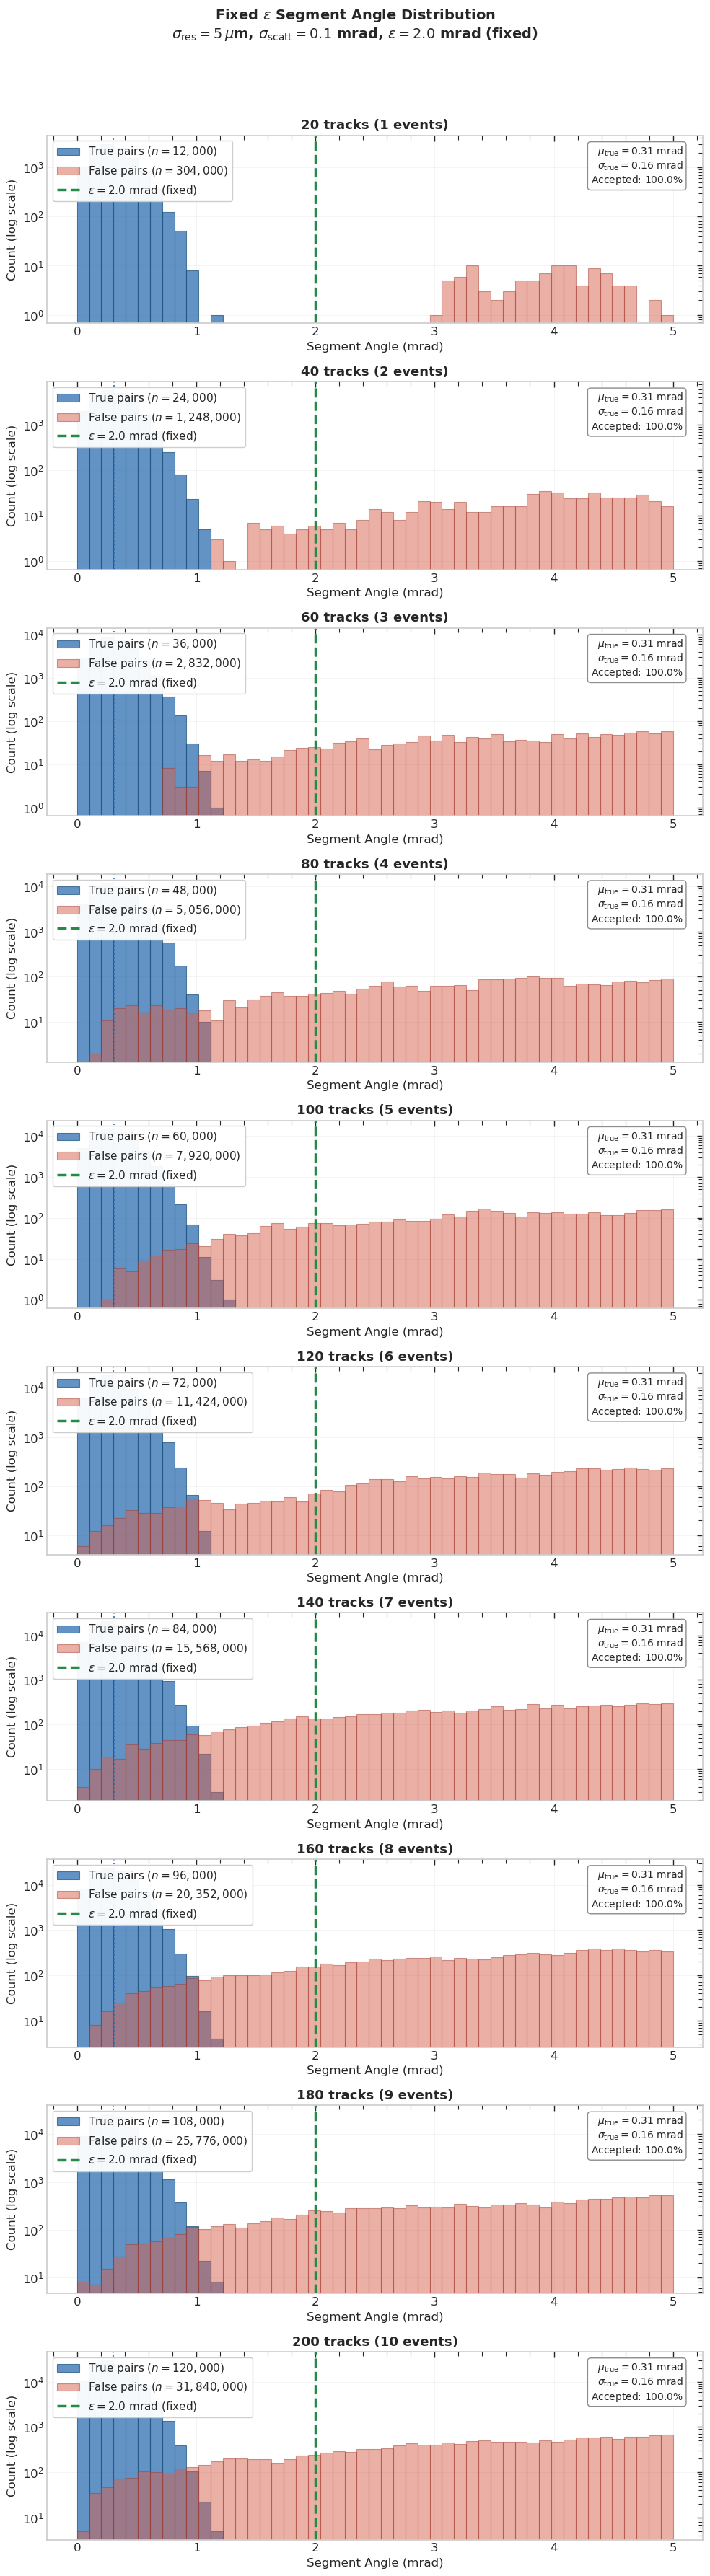

In [ ]:
# ============================================================================
# FIXED EPSILON: Segment Angle Histograms by Track Count (Paper-Ready)
# ============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl

# Paper-ready plot settings
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.minor.width': 0.8,
    'ytick.minor.width': 0.8,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

if len(fixed_eps_angle_results) > 0:
    n_configs = len(fixed_eps_angle_results)
    fig, axes = plt.subplots(n_configs, 1, figsize=(10, 3.5*n_configs))
    
    if n_configs == 1:
        axes = [axes]
    
    for idx, result in enumerate(fixed_eps_angle_results):
        ax = axes[idx]
        
        true_angles_mrad = result['true_angles'] * 1000
        false_angles_mrad = result['false_angles'] * 1000 if len(result['false_angles']) > 0 else []
        epsilon_mrad = FIXED_EPSILON * 1000
        
        # Histogram bins - use log scale for y-axis to show the full range
        max_angle = max(5, epsilon_mrad * 2)
        bins = np.linspace(0, max_angle, 50)
        
        # Plot histograms with step style for cleaner look
        if len(true_angles_mrad) > 0:
            counts_true, _, _ = ax.hist(true_angles_mrad, bins=bins, alpha=0.7, color='#2166ac', 
                   edgecolor='#1a4f7a', linewidth=0.8, label=f'True pairs ($n={result["n_true"]:,}$)')
        
        if len(false_angles_mrad) > 0:
            counts_false, _, _ = ax.hist(false_angles_mrad, bins=bins, alpha=0.5, color='#d6604d',
                   edgecolor='#a33c2f', linewidth=0.8, label=f'False pairs ($n={result["n_false"]:,}$)')
        
        # Use log scale for y-axis if there's large dynamic range
        if len(false_angles_mrad) > 0 and len(true_angles_mrad) > 0:
            max_count = max(np.max(counts_true), np.max(counts_false))
            min_nonzero = min(
                np.min(counts_true[counts_true > 0]) if np.any(counts_true > 0) else 1,
                np.min(counts_false[counts_false > 0]) if np.any(counts_false > 0) else 1
            )
            if max_count / min_nonzero > 100:
                ax.set_yscale('log')
                ax.set_ylabel('Count (log scale)', fontsize=12)
            else:
                ax.set_ylabel('Count', fontsize=12)
        
        # Mark epsilon threshold with annotation
        ax.axvline(epsilon_mrad, color='#238b45', linestyle='--', linewidth=2.5,
                  label=f'$\\varepsilon = {epsilon_mrad:.1f}$ mrad (fixed)')
        
        # Statistics annotation
        if len(true_angles_mrad) > 0:
            mean_true = np.mean(true_angles_mrad)
            std_true = np.std(true_angles_mrad)
            accepted = np.sum(result['true_angles'] <= FIXED_EPSILON)
            accept_pct = accepted / result['n_true'] * 100
            
            # Add mean line
            ax.axvline(mean_true, color='#2166ac', linestyle=':', linewidth=1.5, alpha=0.8)
            
            # Text box with statistics
            textstr = f'$\\mu_{{\\mathrm{{true}}}} = {mean_true:.2f}$ mrad\n$\\sigma_{{\\mathrm{{true}}}} = {std_true:.2f}$ mrad\nAccepted: ${accept_pct:.1f}\\%$'
            props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
            ax.text(0.97, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', horizontalalignment='right', bbox=props)
        
        ax.set_title(f'{result["total_tracks"]} tracks ({result["n_events"]} events)', 
                    fontsize=13, fontweight='bold')
        ax.set_xlabel('Segment Angle (mrad)', fontsize=12)
        ax.legend(loc='upper left', framealpha=0.95)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.minorticks_on()
        ax.tick_params(which='both', direction='in', top=True, right=True)
    
    plt.suptitle(f'Fixed $\\varepsilon$ Segment Angle Distribution\n'
                f'$\\sigma_{{\\mathrm{{res}}}} = 5\\,\\mu$m, $\\sigma_{{\\mathrm{{scatt}}}} = 0.1$ mrad, $\\varepsilon = 2.0$ mrad (fixed)', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save at high resolution
    output_path = BASE / 'fixed_epsilon_segment_angles.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✓ Saved: {output_path}")
    plt.show()
else:
    print("No angle data available to plot")

✓ Saved: /data/bfys/gscriven/Velo_toy/fixed_epsilon_angle_summary.png


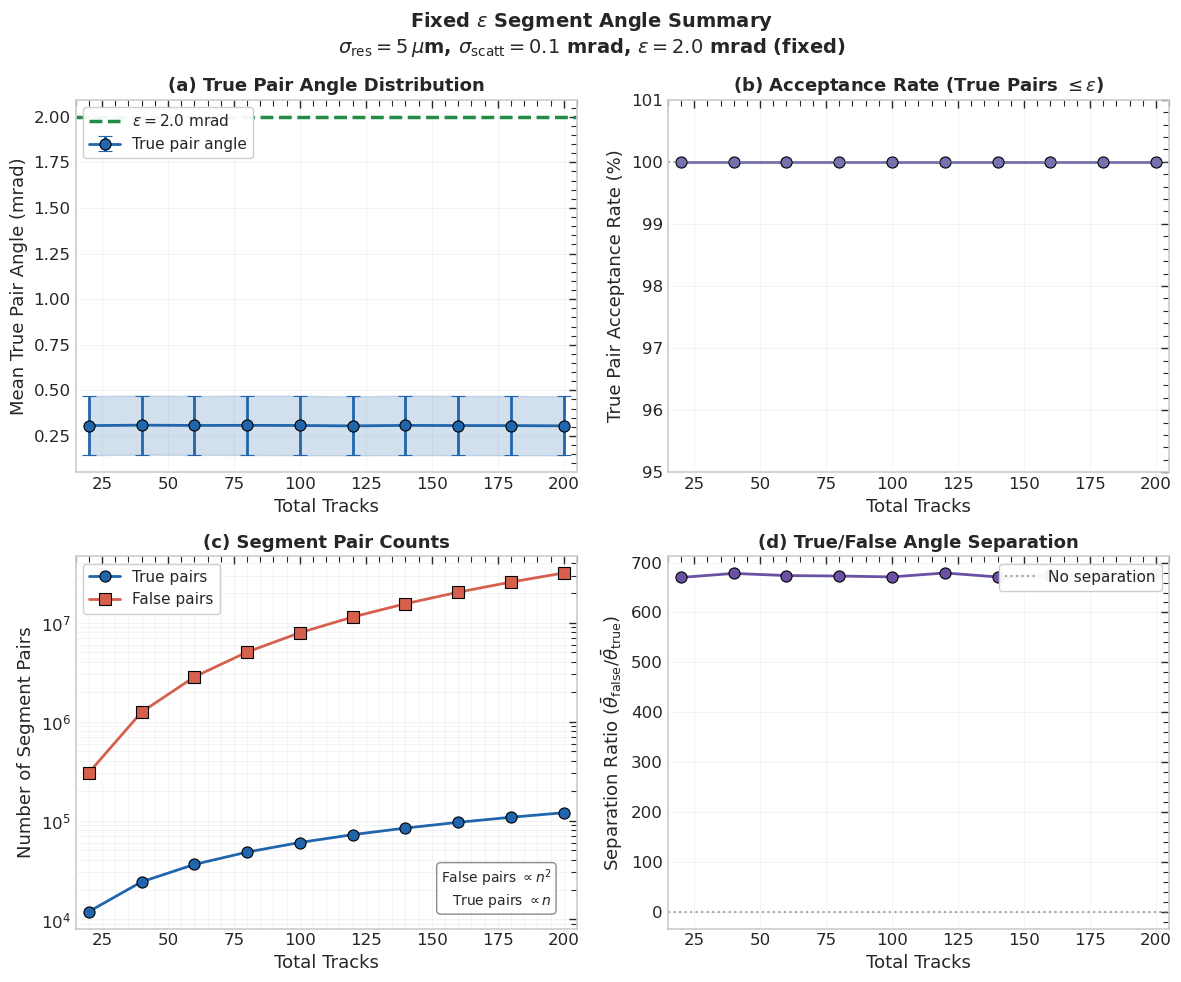


SEGMENT ANGLE SUMMARY TABLE
Tracks     True Pairs     False Pairs    Mean Angle     Std Angle      Accept %  
------------------------------------------------------------------------------------------
20         12,000         304,000        0.307 mrad     0.162 mrad     100.0%
40         24,000         1,248,000      0.309 mrad     0.162 mrad     100.0%
60         36,000         2,832,000      0.308 mrad     0.161 mrad     100.0%
80         48,000         5,056,000      0.308 mrad     0.162 mrad     100.0%
100        60,000         7,920,000      0.308 mrad     0.163 mrad     100.0%
120        72,000         11,424,000     0.305 mrad     0.161 mrad     100.0%
140        84,000         15,568,000     0.308 mrad     0.163 mrad     100.0%
160        96,000         20,352,000     0.307 mrad     0.162 mrad     100.0%
180        108,000        25,776,000     0.307 mrad     0.162 mrad     100.0%
200        120,000        31,840,000     0.306 mrad     0.162 mrad     100.0%


In [ ]:
# ============================================================================
# FIXED EPSILON: Summary Plot - Angle Statistics vs Track Count (Paper-Ready)
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Paper-ready plot settings
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

if len(fixed_eps_angle_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Color scheme for consistency
    color_true = '#2166ac'
    color_false = '#d6604d'
    color_epsilon = '#238b45'
    color_accept = '#7570b3'
    
    # Extract data
    track_counts = [r['total_tracks'] for r in fixed_eps_angle_results]
    
    mean_true_angles = []
    std_true_angles = []
    acceptance_rates = []
    separation_ratios = []
    
    for r in fixed_eps_angle_results:
        if len(r['true_angles']) > 0:
            mean_true_angles.append(np.mean(r['true_angles']) * 1000)
            std_true_angles.append(np.std(r['true_angles']) * 1000)
            accepted = np.sum(r['true_angles'] <= FIXED_EPSILON)
            acceptance_rates.append(accepted / len(r['true_angles']) * 100)
        else:
            mean_true_angles.append(np.nan)
            std_true_angles.append(np.nan)
            acceptance_rates.append(np.nan)
        
        # Separation ratio: mean false / mean true (higher = better separation)
        if len(r['true_angles']) > 0 and len(r['false_angles']) > 0:
            mean_false = np.mean(r['false_angles'])
            mean_true = np.mean(r['true_angles'])
            separation_ratios.append(mean_false / mean_true if mean_true > 0 else np.nan)
        else:
            separation_ratios.append(np.nan)
    
    epsilon_mrad = FIXED_EPSILON * 1000
    
    # -------------------------------------------------------------------------
    # Plot 1: Mean true angle vs track count with error bars
    # -------------------------------------------------------------------------
    ax1 = axes[0, 0]
    ax1.errorbar(track_counts, mean_true_angles, yerr=std_true_angles, 
                fmt='o-', color=color_true, capsize=5, capthick=1.5, 
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='True pair angle')
    ax1.axhline(epsilon_mrad, color=color_epsilon, linestyle='--', linewidth=2.5, 
               label=f'$\\varepsilon = {epsilon_mrad:.1f}$ mrad')
    ax1.fill_between(track_counts, 
                     np.array(mean_true_angles) - np.array(std_true_angles),
                     np.array(mean_true_angles) + np.array(std_true_angles),
                     alpha=0.2, color=color_true)
    ax1.set_xlabel('Total Tracks', fontsize=13)
    ax1.set_ylabel('Mean True Pair Angle (mrad)', fontsize=13)
    ax1.set_title('(a) True Pair Angle Distribution', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left', framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', top=True, right=True)
    ax1.set_xlim(min(track_counts) - 5, max(track_counts) + 5)
    
    # -------------------------------------------------------------------------
    # Plot 2: Acceptance rate vs track count
    # -------------------------------------------------------------------------
    ax2 = axes[0, 1]
    ax2.plot(track_counts, acceptance_rates, 'o-', color=color_accept, 
            linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=0.8)
    ax2.axhline(100, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
    ax2.set_xlabel('Total Tracks', fontsize=13)
    ax2.set_ylabel('True Pair Acceptance Rate (%)', fontsize=13)
    ax2.set_title('(b) Acceptance Rate (True Pairs $\\leq \\varepsilon$)', fontsize=13, fontweight='bold')
    ax2.set_ylim(95, 101)
    ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax2.minorticks_on()
    ax2.tick_params(which='both', direction='in', top=True, right=True)
    ax2.set_xlim(min(track_counts) - 5, max(track_counts) + 5)
    
    # -------------------------------------------------------------------------
    # Plot 3: Number of pairs vs track count (log scale)
    # -------------------------------------------------------------------------
    ax3 = axes[1, 0]
    n_true = [r['n_true'] for r in fixed_eps_angle_results]
    n_false = [r['n_false'] for r in fixed_eps_angle_results]
    
    ax3.semilogy(track_counts, n_true, 'o-', color=color_true, linewidth=2, 
                markersize=8, markeredgecolor='black', markeredgewidth=0.8, 
                label='True pairs')
    ax3.semilogy(track_counts, n_false, 's-', color=color_false, linewidth=2, 
                markersize=8, markeredgecolor='black', markeredgewidth=0.8, 
                label='False pairs')
    ax3.set_xlabel('Total Tracks', fontsize=13)
    ax3.set_ylabel('Number of Segment Pairs', fontsize=13)
    ax3.set_title('(c) Segment Pair Counts', fontsize=13, fontweight='bold')
    ax3.legend(loc='upper left', framealpha=0.95)
    ax3.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, which='both')
    ax3.minorticks_on()
    ax3.tick_params(which='both', direction='in', top=True, right=True)
    ax3.set_xlim(min(track_counts) - 5, max(track_counts) + 5)
    
    # Add scaling annotation
    ax3.text(0.95, 0.05, 'False pairs $\\propto n^2$\nTrue pairs $\\propto n$', 
            transform=ax3.transAxes, fontsize=10, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # -------------------------------------------------------------------------
    # Plot 4: Separation ratio vs track count
    # -------------------------------------------------------------------------
    ax4 = axes[1, 1]
    valid_sep = [(tc, sr) for tc, sr in zip(track_counts, separation_ratios) if not np.isnan(sr)]
    if valid_sep:
        tc_valid, sr_valid = zip(*valid_sep)
        ax4.plot(tc_valid, sr_valid, 'o-', color='#6a51a3', linewidth=2, 
                markersize=8, markeredgecolor='black', markeredgewidth=0.8)
    ax4.axhline(1.0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='No separation')
    ax4.set_xlabel('Total Tracks', fontsize=13)
    ax4.set_ylabel('Separation Ratio ($\\bar{\\theta}_{\\mathrm{false}} / \\bar{\\theta}_{\\mathrm{true}}$)', fontsize=13)
    ax4.set_title('(d) True/False Angle Separation', fontsize=13, fontweight='bold')
    ax4.legend(loc='upper right', framealpha=0.95)
    ax4.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax4.minorticks_on()
    ax4.tick_params(which='both', direction='in', top=True, right=True)
    ax4.set_xlim(min(track_counts) - 5, max(track_counts) + 5)
    
    plt.suptitle(f'Fixed $\\varepsilon$ Segment Angle Summary\n'
                f'$\\sigma_{{\\mathrm{{res}}}} = 5\\,\\mu$m, $\\sigma_{{\\mathrm{{scatt}}}} = 0.1$ mrad, $\\varepsilon = {epsilon_mrad:.1f}$ mrad (fixed)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    output_path = BASE / 'fixed_epsilon_angle_summary.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✓ Saved: {output_path}")
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("SEGMENT ANGLE SUMMARY TABLE")
    print("="*90)
    print(f"{'Tracks':<10} {'True Pairs':<14} {'False Pairs':<14} {'Mean Angle':<14} {'Std Angle':<14} {'Accept %':<10}")
    print("-"*90)
    for i, r in enumerate(fixed_eps_angle_results):
        print(f"{r['total_tracks']:<10} {r['n_true']:<14,} {r['n_false']:<14,} "
              f"{mean_true_angles[i]:.3f} mrad     {std_true_angles[i]:.3f} mrad     "
              f"{acceptance_rates[i]:.1f}%")
    print("="*90)
else:
    print("No angle data available")

## Segment-Level Efficiency Analysis

Compute segment-level metrics for the fixed epsilon experiment:

**Segment Efficiency** = N Found Good Segments / N Good Segments (truth)
- Measures what fraction of true segments were correctly identified

**Segment False Rate** = N Found Bad Segments / N All Found Segments
- Measures what fraction of selected segments are false (combinatorial background)

In [1]:
# ============================================================================
# SEGMENT-LEVEL EFFICIENCY: Compute from angle threshold data
# ============================================================================
# The segment-level analysis uses angle data already collected in cell above.
#
# A segment PAIR is two segments sharing a middle hit.
# True pair:  both segments belong to the same track
# False pair: segments belong to different tracks
#
# A pair is "accepted" if the angle between its segments ≤ epsilon.
#
# Definitions:
#   Segment Efficiency = N_true_accepted / N_true_pairs
#   Segment False Rate = N_false_accepted / N_all_accepted
#
# The next cell computes these from fixed_eps_angle_results directly.
print("✓ Segment efficiency definitions ready — computed in next cell")

✓ Segment efficiency definitions ready — computed in next cell


In [2]:
# ============================================================================
# SEGMENT EFFICIENCY: Direct computation from angle data (with per-repeat stats)
# ============================================================================
# Use the angle data we already collected to compute segment-level efficiency
# 
# A segment PAIR is "selected" if the angle between segments ≤ epsilon
# True pairs: pairs from same track (should be selected)
# False pairs: pairs from different tracks (should not be selected)
#
# Segment Efficiency = N_true_pairs_accepted / N_true_pairs
# Segment False Rate = N_false_pairs_accepted / N_all_pairs_accepted

print("="*80)
print("SEGMENT-LEVEL EFFICIENCY (from angle thresholding)")
print("="*80)
print(f"Epsilon threshold: {FIXED_EPSILON*1000:.1f} mrad")
print("="*80)

segment_efficiency_results = []

for result in fixed_eps_angle_results:
    true_angles = result['true_angles']
    false_angles = result['false_angles']
    
    # Count pairs accepted (angle ≤ epsilon) - aggregated
    true_accepted = np.sum(true_angles <= FIXED_EPSILON)
    false_accepted = np.sum(false_angles <= FIXED_EPSILON)
    
    n_true = len(true_angles)
    n_false = len(false_angles)
    n_all_accepted = true_accepted + false_accepted
    
    # Segment Efficiency = true pairs found / all true pairs
    seg_efficiency = true_accepted / n_true if n_true > 0 else 0.0
    
    # Segment False Rate = false pairs accepted / all pairs accepted
    seg_false_rate = false_accepted / n_all_accepted if n_all_accepted > 0 else 0.0
    
    # Extract per-repeat data if available
    per_repeat_data = result.get('per_repeat_data', None)
    
    if per_repeat_data:
        # Compute mean and std for per-repeat quantities
        n_true_per_repeat = np.array([r['n_true'] for r in per_repeat_data])
        n_false_per_repeat = np.array([r['n_false'] for r in per_repeat_data])
        true_acc_per_repeat = np.array([r['true_accepted'] for r in per_repeat_data])
        false_acc_per_repeat = np.array([r['false_accepted'] for r in per_repeat_data])
        
        n_repeats = len(per_repeat_data)
        
        # Standard errors (std / sqrt(n))
        n_true_mean = np.mean(n_true_per_repeat)
        n_true_se = np.std(n_true_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        n_false_mean = np.mean(n_false_per_repeat)
        n_false_se = np.std(n_false_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        true_acc_mean = np.mean(true_acc_per_repeat)
        true_acc_se = np.std(true_acc_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
        
        false_acc_mean = np.mean(false_acc_per_repeat)
        false_acc_se = np.std(false_acc_per_repeat) / np.sqrt(n_repeats) if n_repeats > 1 else 0
    else:
        # No per-repeat data - use aggregated values with zero errors
        n_true_mean = n_true
        n_true_se = 0
        n_false_mean = n_false
        n_false_se = 0
        true_acc_mean = true_accepted
        true_acc_se = 0
        false_acc_mean = false_accepted
        false_acc_se = 0
        n_repeats = 1
    
    segment_efficiency_results.append({
        'n_events': result['n_events'],
        'total_tracks': result['total_tracks'],
        'n_true_pairs': n_true,
        'n_false_pairs': n_false,
        'true_accepted': true_accepted,
        'false_accepted': false_accepted,
        'total_accepted': n_all_accepted,
        'seg_efficiency': seg_efficiency,
        'seg_false_rate': seg_false_rate,
        # Per-repeat statistics for error bars
        'n_true_mean': n_true_mean,
        'n_true_se': n_true_se,
        'n_false_mean': n_false_mean,
        'n_false_se': n_false_se,
        'true_acc_mean': true_acc_mean,
        'true_acc_se': true_acc_se,
        'false_acc_mean': false_acc_mean,
        'false_acc_se': false_acc_se,
        'n_repeats': n_repeats,
    })
    
    print(f"\n[{result['total_tracks']} tracks] ({n_repeats} repeats)")
    print(f"  True pairs: {n_true_mean:.0f} ± {n_true_se:.1f}, accepted: {true_acc_mean:.0f} ± {true_acc_se:.1f}")
    print(f"  False pairs: {n_false_mean:.0f} ± {n_false_se:.1f}, accepted: {false_acc_mean:.0f} ± {false_acc_se:.1f}")
    print(f"  → Segment Efficiency: {seg_efficiency*100:.1f}%")
    print(f"  → False Rate: {seg_false_rate*100:.2f}%")

print(f"\n{'='*80}")
print("SEGMENT EFFICIENCY ANALYSIS COMPLETE")
print(f"{'='*80}")

SEGMENT-LEVEL EFFICIENCY (from angle thresholding)


NameError: name 'FIXED_EPSILON' is not defined

✓ Saved: /data/bfys/gscriven/Velo_toy/fixed_epsilon_segment_efficiency.png
✓ Saved: /data/bfys/gscriven/Velo_toy/fixed_epsilon_segment_efficiency.pdf


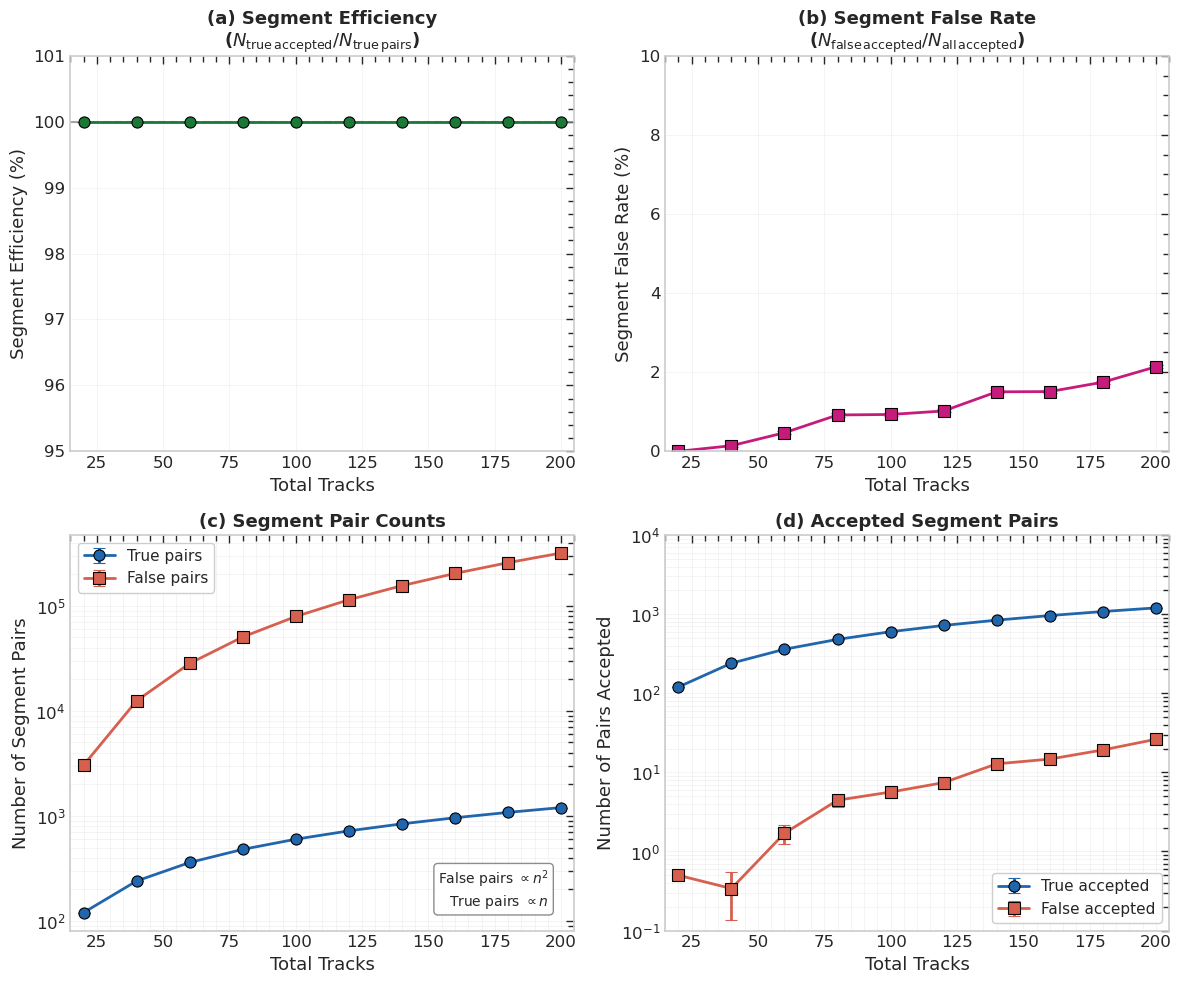


SEGMENT-LEVEL EFFICIENCY SUMMARY TABLE
Tracks     Reps   Seg Eff          False Rate       True Pairs         False Pairs        True Acc         False Acc       
----------------------------------------------------------------------------------------------------------------------------------
20         100    100.0% ± 0.00%   0.00% ± 0.00%    120 ± 0.0          3040 ± 0.0         120 ± 0.0        0 ± 0.0         
40         100    100.0% ± 0.00%   0.14% ± 0.02%    240 ± 0.0          12480 ± 0.0        240 ± 0.0        0 ± 0.2         
60         100    100.0% ± 0.00%   0.47% ± 0.04%    360 ± 0.0          28320 ± 0.0        360 ± 0.0        2 ± 0.5         
80         100    100.0% ± 0.00%   0.92% ± 0.04%    480 ± 0.0          50560 ± 0.0        480 ± 0.0        4 ± 0.8         
100        100    100.0% ± 0.00%   0.93% ± 0.04%    600 ± 0.0          79200 ± 0.0        600 ± 0.0        6 ± 1.0         
120        100    100.0% ± 0.00%   1.02% ± 0.04%    720 ± 0.0          114240 ± 0.0  

In [ ]:
# ============================================================================
# SEGMENT EFFICIENCY: Visualization (Paper-Ready with Error Bars)
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Paper-ready plot settings
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

if len(segment_efficiency_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Color scheme for consistency
    color_true = '#2166ac'
    color_false = '#d6604d'
    color_eff = '#1b7837'
    color_false_rate = '#c51b7d'
    
    track_counts = np.array([r['total_tracks'] for r in segment_efficiency_results])
    seg_eff = np.array([r['seg_efficiency'] * 100 for r in segment_efficiency_results])
    false_rate = np.array([r['seg_false_rate'] * 100 for r in segment_efficiency_results])
    n_true = np.array([r['n_true_pairs'] for r in segment_efficiency_results])
    n_false = np.array([r['n_false_pairs'] for r in segment_efficiency_results])
    true_accepted = np.array([r['true_accepted'] for r in segment_efficiency_results])
    false_accepted = np.array([r['false_accepted'] for r in segment_efficiency_results])
    total_accepted = np.array([r['total_accepted'] for r in segment_efficiency_results])
    
    # Per-repeat statistics for error bars on (c) and (d)
    n_true_mean = np.array([r['n_true_mean'] for r in segment_efficiency_results])
    n_true_se = np.array([r['n_true_se'] for r in segment_efficiency_results])
    n_false_mean = np.array([r['n_false_mean'] for r in segment_efficiency_results])
    n_false_se = np.array([r['n_false_se'] for r in segment_efficiency_results])
    true_acc_mean = np.array([r['true_acc_mean'] for r in segment_efficiency_results])
    true_acc_se = np.array([r['true_acc_se'] for r in segment_efficiency_results])
    false_acc_mean = np.array([r['false_acc_mean'] for r in segment_efficiency_results])
    false_acc_se = np.array([r['false_acc_se'] for r in segment_efficiency_results])
    
    # Compute binomial errors for efficiency and false rate
    # Segment Efficiency: true_accepted / n_true -> binomial error
    seg_eff_err = np.sqrt(seg_eff * (100 - seg_eff) / n_true) if np.all(n_true > 0) else np.zeros_like(seg_eff)
    
    # False Rate: false_accepted / total_accepted -> binomial error (handle zero accepted)
    false_rate_err = np.zeros_like(false_rate)
    for i, (fa, ta, fr) in enumerate(zip(false_accepted, total_accepted, false_rate)):
        if ta > 0:
            false_rate_err[i] = np.sqrt(fr * (100 - fr) / ta)
    
    # -------------------------------------------------------------------------
    # Plot 1: Segment Efficiency with error bars
    # -------------------------------------------------------------------------
    ax1 = axes[0, 0]
    ax1.errorbar(track_counts, seg_eff, yerr=seg_eff_err, 
                fmt='o-', color=color_eff, capsize=5, capthick=1.5,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8)
    ax1.axhline(100, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    ax1.set_xlabel('Total Tracks', fontsize=13)
    ax1.set_ylabel('Segment Efficiency (%)', fontsize=13)
    ax1.set_title('(a) Segment Efficiency\n($N_{\\mathrm{true\\,accepted}} / N_{\\mathrm{true\\,pairs}}$)', 
                 fontsize=13, fontweight='bold')
    ax1.set_ylim(95, 101)
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', top=True, right=True)
    ax1.set_xlim(min(track_counts) - 5, max(track_counts) + 5)
    
    # -------------------------------------------------------------------------
    # Plot 2: False Rate with error bars
    # -------------------------------------------------------------------------
    ax2 = axes[0, 1]
    ax2.errorbar(track_counts, false_rate, yerr=false_rate_err,
                fmt='s-', color=color_false_rate, capsize=5, capthick=1.5,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8)
    ax2.set_xlabel('Total Tracks', fontsize=13)
    ax2.set_ylabel('Segment False Rate (%)', fontsize=13)
    ax2.set_title('(b) Segment False Rate\n($N_{\\mathrm{false\\,accepted}} / N_{\\mathrm{all\\,accepted}}$)', 
                 fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax2.minorticks_on()
    ax2.tick_params(which='both', direction='in', top=True, right=True)
    ax2.set_xlim(min(track_counts) - 5, max(track_counts) + 5)
    ax2.set_ylim(0, 10)
    
    # -------------------------------------------------------------------------
    # Plot 3: Pair counts (log scale with error bars)
    # -------------------------------------------------------------------------
    ax3 = axes[1, 0]
    ax3.errorbar(track_counts, n_true_mean, yerr=n_true_se,
                fmt='o-', color=color_true, capsize=4, capthick=1.2,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='True pairs')
    ax3.errorbar(track_counts, n_false_mean, yerr=n_false_se,
                fmt='s-', color=color_false, capsize=4, capthick=1.2,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='False pairs')
    ax3.set_yscale('log')
    ax3.set_xlabel('Total Tracks', fontsize=13)
    ax3.set_ylabel('Number of Segment Pairs', fontsize=13)
    ax3.set_title('(c) Segment Pair Counts', fontsize=13, fontweight='bold')
    ax3.legend(loc='upper left', framealpha=0.95)
    ax3.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, which='both')
    ax3.minorticks_on()
    ax3.tick_params(which='both', direction='in', top=True, right=True)
    ax3.set_xlim(min(track_counts) - 5, max(track_counts) + 5)
    
    # Add scaling annotation
    ax3.text(0.95, 0.05, 'False pairs $\\propto n^2$\nTrue pairs $\\propto n$', 
            transform=ax3.transAxes, fontsize=10, ha='right', va='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # -------------------------------------------------------------------------
    # Plot 4: Accepted pairs (log scale with error bars)
    # -------------------------------------------------------------------------
    ax4 = axes[1, 1]
    # Handle zero values for log scale
    false_acc_plot = np.where(false_acc_mean > 0, false_acc_mean, 0.5)
    false_acc_se_plot = np.where(false_acc_mean > 0, false_acc_se, 0)
    
    ax4.errorbar(track_counts, true_acc_mean, yerr=true_acc_se,
                fmt='o-', color=color_true, capsize=4, capthick=1.2,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='True accepted')
    ax4.errorbar(track_counts, false_acc_plot, yerr=false_acc_se_plot,
                fmt='s-', color=color_false, capsize=4, capthick=1.2,
                linewidth=2, markersize=8, markeredgecolor='black', 
                markeredgewidth=0.8, label='False accepted')
    ax4.set_yscale('log')
    ax4.set_xlabel('Total Tracks', fontsize=13)
    ax4.set_ylabel('Number of Pairs Accepted', fontsize=13)
    ax4.set_title('(d) Accepted Segment Pairs', fontsize=13, fontweight='bold')
    ax4.legend(loc='lower right', framealpha=0.95)
    ax4.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, which='both')
    ax4.minorticks_on()
    ax4.tick_params(which='both', direction='in', top=True, right=True)
    ax4.set_xlim(min(track_counts) - 5, max(track_counts) + 5)
    ax4.set_ylim(0.1, 1e4)
    
    # # Add main figure title
    # fig.suptitle(f'Segment-Level Efficiency Analysis)', 
    #              fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save figure as PNG
    output_path = BASE / 'fixed_epsilon_segment_efficiency.png'
    fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {output_path}")
    
    # Save figure as high-resolution PDF
    pdf_path = BASE / 'fixed_epsilon_segment_efficiency.pdf'
    fig.savefig(pdf_path, format='pdf', dpi=600, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {pdf_path}")
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*130)
    print("SEGMENT-LEVEL EFFICIENCY SUMMARY TABLE")
    print("="*130)
    print(f"{'Tracks':<10} {'Reps':<6} {'Seg Eff':<16} {'False Rate':<16} {'True Pairs':<18} {'False Pairs':<18} {'True Acc':<16} {'False Acc':<16}")
    print("-"*130)
    for i, r in enumerate(segment_efficiency_results):
        eff_str = f"{r['seg_efficiency']*100:.1f}% ± {seg_eff_err[i]:.2f}%"
        fr_str = f"{r['seg_false_rate']*100:.2f}% ± {false_rate_err[i]:.2f}%"
        true_p_str = f"{r['n_true_mean']:.0f} ± {r['n_true_se']:.1f}"
        false_p_str = f"{r['n_false_mean']:.0f} ± {r['n_false_se']:.1f}"
        true_a_str = f"{r['true_acc_mean']:.0f} ± {r['true_acc_se']:.1f}"
        false_a_str = f"{r['false_acc_mean']:.0f} ± {r['false_acc_se']:.1f}"
        print(f"{r['total_tracks']:<10} {r['n_repeats']:<6} {eff_str:<16} {fr_str:<16} {true_p_str:<18} {false_p_str:<18} {true_a_str:<16} {false_a_str:<16}")
    print("="*130)

else:
    print("No segment efficiency results to plot!")